# 5강 Transformer Input Representation, Output 구현
> 4강에서 우리는 4가지 대회에 관한 설명을 들었습니다! 이제 우리는 여기서 직접 코드로 이 4가지 대회를 탐험해볼 것입니다! 모험을 떠나봅시다!



In [ ]:
import os

# 이 실습 파일이 위치하고 있는 경로!
PROJECT_PATH = "drive/MyDrive/AI 부스트캠프/강의용 코드"

# 데이터셋이 모아져있는 폴더
DATA_PATH = os.path.join(PROJECT_PATH, 'dataset')

# 대회

- 🧪 [2019 Data Science Bowl](https://www.kaggle.com/c/data-science-bowl-2019/overview)
- 📚 [Riiid Answer Correctness Prediction](https://www.kaggle.com/c/riiid-test-answer-prediction/overview)
- 💎 [Predicting Molecular Properties](https://www.kaggle.com/c/champs-scalar-coupling/overview)
- 🎯 [Mechanisms of Action (MoA) Prediction](https://www.kaggle.com/c/lish-moa/data)

**대회 라이센스**
>  
- 🧪 DSB 라이센스
    - 코드 : Open Source
    - 데이터 : Competition Use Only
- 📚 RiiiD 라이센스
    - 코드 : Non-Exclusive
    - 데이터 : Competition Use Only
- 💎 Molecular 라이센스
    - 코드 : Open Source
    - 데이터 : Competition Use and Commercial are checked (CC-BY)
- 🎯 MoA 라이센스
    - 코드 : Open Source
    - 데이터 : Competition Use, Academic Use, and Non-commercial Use


## 🧪 [2019 Data Science Bowl](https://www.kaggle.com/c/data-science-bowl-2019/overview)
**Uncover the factors to help measure how young children learn**

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/16531/logos/header.png?t=2019-10-11-20-50-18" width=700>

**살펴보면 좋은 핵심들**
>  
1. **CFG class를 통해 전체 configuration을 관리하는 방법을 살펴보자**
    - CFG만 수정하면 되므로 관리가 편리하다
    - 함수 간에 parameter를 건네줄 때 CFG에 포함시켜 건네주면 되므로 parameter수가 늘어나도 코드를 가독성 좋게 짤 수 있다
2. **데이터셋 하나로 주어지면 좋겠지만 보통은 여러개로 나뉘어져 주어진다! 이를 합치는 방법를 살펴보자!**
3. **feature engineering을 통해서 어떻게 feature를 늘리는지 살펴보자!**
4. **feature가 수치형인지 범주형인지 파악하고 이를 embedding하는 방법에 대해서 배워보자!**
    - 우리가 transformer input을 만들 때 수치형 feature와 범주형 feature를 구분해서 embedding해야 한다
5. **범주형 feature 여러개를 하나의 embedding layer로 embedding 하는 방법을 살펴보자!**

**DSB 3등 솔루션**
- [설명](https://www.kaggle.com/c/data-science-bowl-2019/discussion/127891)
- [github 코드](https://github.com/lime-robot/dsb2019)
- [kaggle 코드](https://www.kaggle.com/limerobot/dsb2019-v77-tr-dt-aug0-5-3tta)


In [ ]:
import pandas as pd

# Data Science Bowl 데이터셋 path 설정
DSB_PATH = os.path.join(DATA_PATH, 'DSB')

# 데이터셋 불러오기
train_df = pd.read_csv(os.path.join(DSB_PATH, 'train.csv'))
train_labels_df = pd.read_csv(os.path.join(DSB_PATH, 'train_labels.csv'))
specs_df = pd.read_csv(os.path.join(DSB_PATH, 'specs.csv')) 

### ⚗️ EDA (Exploratory Data Analysis)
> 간단하게 데이터를 살펴보면서 이 데이터를 어떻게 하면 Transformer input으로 바꿀 수 있을지 생각해보자!

⭐ 수치형? 범주형? ⭐
> 데이터를 보면서 각 feature가 수치형인지 범주형인지 신경써서 살펴보자!

In [ ]:
train_df.sample(5)

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
972,cf82af56,f11eb823348bfa23,2019-09-06T18:08:45.447Z,"{""coordinates"":{""x"":1676,""y"":315,""stage_width""...",0001e90f,611,4070,473556,Scrub-A-Dub,Game,MAGMAPEAK
7945,76babcde,d78d2fa8766987f0,2019-09-11T19:16:25.999Z,"{""coordinates"":{""x"":418,""y"":142,""stage_width"":...",0009a5a9,156,4070,1609720,Dino Dive,Game,MAGMAPEAK
7908,c0415e5c,d78d2fa8766987f0,2019-09-11T19:15:43.581Z,"{""size"":1,""dinosaur"":""teri"",""water_level"":1,""c...",0009a5a9,119,4020,1567316,Dino Dive,Game,MAGMAPEAK
2926,26fd2d99,1623f262016185e4,2019-08-06T05:42:41.299Z,"{""round_target"":{""size"":3,""type"":""Tub"",""animal...",0006a69f,63,2020,80477,Scrub-A-Dub,Game,MAGMAPEAK
1658,2b9272f4,0336db4dee65ad4b,2019-08-06T05:01:33.003Z,"{""description"":""Everybody's got a tub that's j...",0006a69f,16,3121,19711,Scrub-A-Dub,Game,MAGMAPEAK


In [ ]:
train_labels_df.sample(5)

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
2213,6c8555b7ed49ed5d,1bfc9ff2,Mushroom Sorter (Assessment),1,0,1.000000,3
6399,1b4949aeea5fc61e,54b76deb,Cauldron Filler (Assessment),1,0,1.000000,3
1663,d548ac0d361aa52f,14e3bbbe,Bird Measurer (Assessment),1,2,0.333333,1
1935,0e631a8f36ed058e,19bf1284,Cart Balancer (Assessment),1,0,1.000000,3
10742,f898d5cf892faeeb,96979008,Cauldron Filler (Assessment),0,6,0.000000,0


In [ ]:
specs_df.sample(5)

,event_id,info,args
90,28f975ea,This event occurs when the player clicks on on...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
224,6077cc36,This event occurs when the player hovers the m...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
325,c7128948,This event occurs when the player drags a mush...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
175,4bb2f698,This event occurs when the player clicks on so...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
41,65a38bf7,The start round event is triggered at the star...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."


In [ ]:
import json

json.loads(specs_df.iloc[0].args)

[{'info': 'millisecond count since start of game',
  'name': 'game_time',
  'type': 'int'},
 {'info': 'number of the current round when the event takes place or 0 if no round',
  'name': 'round',
  'type': 'int'},
 {'info': 'number of the current level when the event takes place or 0 if no level',
  'name': 'level',
  'type': 'int'},
 {'info': 'the text or description of the instruction',
  'name': 'description',
  'type': 'string'},
 {'info': 'a unique identifier for this piece of instruction',
  'name': 'identifier',
  'type': 'string'},
 {'info': "the type of media that has just played:\n'audio' || 'animation' || 'other'",
  'name': 'media_type',
  'type': 'string'},
 {'info': 'the duration of the media playback in milliseconds',
  'name': 'duration',
  'type': 'int'},
 {'info': 'session event counter', 'name': 'event_count', 'type': 'int'},
 {'info': 'event class identifier', 'name': 'event_code', 'type': 'int'}]

가볍게 데이터를 훑어보면 주로 범주형 데이터 위주로 이루어져 있으며 수치형 데이터가 한 두개 섞여있다. 범주형 데이터는 문자 혹은 숫자로 다양하게 이루어져있는데 이를 추후 임베딩(Embedding)하기 위해서는 숫자로 변환이 필요해보인다.

### ⚗️ 전처리 (Preprocessing)
> train과 관련된 데이터셋이 3개로 나뉘어져 주어졌다! 이를 합치는 것은 물론 데이터의 품질을 개선시키고 훈련에 바로 사용할 수 없는 feature들을 어떻게 훈련에 사용할 수 있게 바꿀 수 있을지 생각해보자!


#### 🟢 Bird Measurer의 event code 수정하기!
> 대회의 데이터 설명을 보면 다음과 같은 설명이 있다.

**[2019 Data Science Bowl - Data Description](https://www.kaggle.com/c/data-science-bowl-2019/data)**
> The file `train_labels.csv` has been provided to show how these groups would be computed on the assessments in the training set. **Assessment attempts are captured in event_code 4100 for all assessments except for Bird Measurer, which uses event_code 4110.** If the attempt was correct, it contains "correct":true.

우리는 우리는 **Assessment attempts**가 `Bird Measurer`를 제외하고 모두 **4100**으로 되어있음을 알 수 있다. `Bird Measurer`는 혼자 **4110**을 사용한다. 이를 통일시켜주자! 그리고 `Bird Measurer`에서 이미 **4100**를 사용하고 있는 데이터의 경우에 아무도 안사용하는 event code인 **5110**으로 바꿔준다.

⭐ **데이터 품질(Data Quality)**에 신경쓰자! ⭐
> 위의 경우는 **정확도(accuracy)**를 위해 수정하는 경우다! 데이터의 품질이 나쁘면 아무리 좋은 input과 output을 만들어도 데이터에 섞인 노이즈(noise)때문에 성능이 하락할 수 있다! 데이터의 품질에 꼭 신경쓰자!

In [ ]:
train_df[(train_df['title']=='Bird Measurer (Assessment)') & (train_df['event_code']==4110)].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15 entries, 2709 to 8054
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   event_id         15 non-null     object
 1   game_session     15 non-null     object
 2   timestamp        15 non-null     object
 3   event_data       15 non-null     object
 4   installation_id  15 non-null     object
 5   event_count      15 non-null     int64 
 6   event_code       15 non-null     int64 
 7   game_time        15 non-null     int64 
 8   title            15 non-null     object
 9   type             15 non-null     object
 10  world            15 non-null     object
dtypes: int64(3), object(8)
memory usage: 1.4+ KB


In [ ]:
# 이미 4100을 차지하던 데이터들이 있다!
train_df[(train_df['title']=='Bird Measurer (Assessment)') & (train_df['event_code']==4100)]

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
4153,070a5291,a9ef3ecb3d1acc6a,2019-08-06T20:50:33.283Z,"{""correct"":true,""hats"":[4,8,5],""event_count"":3...",0006a69f,30,4100,34209,Bird Measurer (Assessment),Assessment,TREETOPCITY
7414,070a5291,957406a905d59afd,2019-10-01T01:00:04.842Z,"{""correct"":false,""hats"":[5,4,8],""event_count"":...",0006c192,54,4100,54682,Bird Measurer (Assessment),Assessment,TREETOPCITY
8078,070a5291,ae691ec5ad5652cf,2019-09-22T16:33:08.061Z,"{""correct"":true,""hats"":[4,8,5],""event_count"":3...",00129856,38,4100,37535,Bird Measurer (Assessment),Assessment,TREETOPCITY


In [ ]:
# 현재 5110은 어떠한 데이터도 사용하지 않는 event code인만큼 이곳으로 변환하자!
train_df[(train_df['title']=='Bird Measurer (Assessment)') & (train_df['event_code']==5110)]

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world


In [ ]:
def replace_4110_4100(df):
    df = df.copy()
    rep_code4110_bool = (df['title']=='Bird Measurer (Assessment)') & (df['event_code']==4110)
    rep_code4100_bool = (df['title']=='Bird Measurer (Assessment)') & (df['event_code']==4100)
    df.loc[rep_code4110_bool, 'event_code'] = 4100
    df.loc[rep_code4100_bool, 'event_code'] = 5110

    return df

# 변환하자!
train_df = replace_4110_4100(train_df)

# 올바르게 수정되었다 😀 
train_df[(train_df['title']=='Bird Measurer (Assessment)') & (train_df['event_code']==4100)]

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
2709,17113b36,77b8ee947eb84b4e,2019-08-06T05:35:54.898Z,"{""correct"":false,""caterpillars"":[11,8,3],""even...",0006a69f,29,4100,35771,Bird Measurer (Assessment),Assessment,TREETOPCITY
2715,17113b36,77b8ee947eb84b4e,2019-08-06T05:36:01.927Z,"{""correct"":false,""caterpillars"":[11,8,11],""eve...",0006a69f,35,4100,42805,Bird Measurer (Assessment),Assessment,TREETOPCITY
2720,17113b36,77b8ee947eb84b4e,2019-08-06T05:36:06.512Z,"{""correct"":false,""caterpillars"":[11,8,5],""even...",0006a69f,40,4100,47388,Bird Measurer (Assessment),Assessment,TREETOPCITY
2725,17113b36,77b8ee947eb84b4e,2019-08-06T05:36:09.739Z,"{""correct"":false,""caterpillars"":[11,8,7],""even...",0006a69f,45,4100,50605,Bird Measurer (Assessment),Assessment,TREETOPCITY
2730,17113b36,77b8ee947eb84b4e,2019-08-06T05:36:13.951Z,"{""correct"":false,""caterpillars"":[11,8,4],""even...",0006a69f,50,4100,54822,Bird Measurer (Assessment),Assessment,TREETOPCITY
2733,17113b36,77b8ee947eb84b4e,2019-08-06T05:36:17.407Z,"{""correct"":false,""caterpillars"":[11,8,4],""even...",0006a69f,53,4100,58280,Bird Measurer (Assessment),Assessment,TREETOPCITY
2738,17113b36,77b8ee947eb84b4e,2019-08-06T05:36:21.390Z,"{""correct"":false,""caterpillars"":[11,8,2],""even...",0006a69f,58,4100,62256,Bird Measurer (Assessment),Assessment,TREETOPCITY
2743,17113b36,77b8ee947eb84b4e,2019-08-06T05:36:26.296Z,"{""correct"":false,""caterpillars"":[11,8,1],""even...",0006a69f,63,4100,67164,Bird Measurer (Assessment),Assessment,TREETOPCITY
2750,17113b36,77b8ee947eb84b4e,2019-08-06T05:36:32.187Z,"{""correct"":false,""caterpillars"":[11,8,1],""even...",0006a69f,70,4100,73056,Bird Measurer (Assessment),Assessment,TREETOPCITY
2756,17113b36,77b8ee947eb84b4e,2019-08-06T05:36:38.140Z,"{""correct"":false,""caterpillars"":[5,8,1],""event...",0006a69f,76,4100,79006,Bird Measurer (Assessment),Assessment,TREETOPCITY


#### 🟢 JSON으로 되어있는 event_data에서 정보 가져오기!
> `event_data`는 각 `event_code`에 대한 정보를 JSON으로 가지고 있다! 이를 feature로 만들자!

⭐ Pandas JSON feature 다루기 ⭐
- 아래 코드를 통해 JSON안에 담겨있는 정보를 어떻게 가져오는지 살펴보자!
- [pandas.Series.str.contains](https://pandas.pydata.org/docs/reference/api/pandas.Series.str.contains.html)

In [ ]:
# event_data에 어떤 데이터가 담겨있는지 살펴보자
train_df.event_data[10]

'{"coordinates":{"x":807,"y":619,"stage_width":1015,"stage_height":762},"event_count":9,"game_time":12672,"event_code":4070}'

In [ ]:
# str.contain을 통해 해당 string안에 correct 문자열이 있는지 살펴볼 수 있다!
col_bool = train_df['event_data'].str.contains('correct')
train_df['event_data'][col_bool][9814]

'{"source":"resources","bowl_id":1,"position":1,"scale_contents":["empty","empty"],"correct":true,"coordinates":{"x":821,"y":422,"stage_width":1014,"stage_height":541},"round":5,"event_count":200,"game_time":156709,"event_code":4020}'

In [ ]:
import json
import numpy as np

def extract_data_from_event_code(df, columns=['correct', 'round']):
    df = df.copy()
    for col in columns:
        col_bool = df['event_data'].str.contains(col)
        df[col] = np.nan
        df.loc[col_bool, col] = df['event_data'][col_bool].apply(lambda x: json.loads(x).get(col)).astype(float)

    return df

train_df = extract_data_from_event_code(train_df)

#### 🟢 특성 공학 (Feature Engineering)
> 우리의 학습을 더욱 쉽게 하기 위한 새로운 feature들을 생성하자! 주로 수치형 feature를 생성한다

- game_time 시간 단위를 초로 변경하기
- game_session위주로 데이터를 aggregation하기
- `Game` type과 `4020, 4025` event_code를 위한 추가적인 train label 데이터 생성
- `Assessment` type과 `4100` event_code를 위한 추가적인 train label 데이터 생성

##### game_time 시간 단위를 초로 변경하기
> 현재 milisecond로 되어있는 시간 `game_time`을 second로 바꾸자!

In [ ]:
train_df['game_time'].sample(3)

1723     82548
8883     17647
7228    264906
Name: game_time, dtype: int64

In [ ]:
train_df['game_time'] = train_df['game_time'] // 1000

##### game_session위주로 데이터를 aggregation하기
> `game_session`을 기준으로 다른 feature들의 정보들을 aggregate하여 새로운 feature를 만들어보자! 이를 통해 row별로 퍼져있던 game_session정보들을 하나로 모을 수가 있다!

1. game_session의 event_code별 데이터 갯수
2. game_session의 event_id별 데이터 갯수
3. game_session의 event_code별 정답률
4. game_session의 event_code별 최대 round 횟수

- [pandas.crosstab](https://pandas.pydata.org/docs/reference/api/pandas.crosstab.html)
- [pandas.pivot_table](https://pandas.pydata.org/docs/reference/api/pandas.pivot_table.html)

In [ ]:
train_df['num_incorrect'] = np.where(train_df['correct']==0, 1, np.nan)
train_df['num_correct'] = np.where(train_df['correct']==1, 1, np.nan)

In [ ]:
# game_session의 각 event_code 데이터 갯수
pd.crosstab(train_df['game_session'], train_df['event_code']).head(3)

event_code,2000,2010,2020,2025,2030,2035,2040,2050,2060,2070,2075,2080,2081,2083,3010,3020,3021,3110,3120,3121,4010,4020,4021,4022,4025,4030,4031,4035,4040,4045,4070,4080,4090,4095,4100,4110,4220,4230,4235,5000,5010,5110
game_session,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
01113cfb10b0de3a,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
02037d41f6e9cdb8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
023233ed83f0f606,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# game_session의 각 event_code별 correct 횟수
pd.pivot_table(train_df[(~train_df['correct'].isna())], index='game_session', columns='event_code', values='num_correct', aggfunc='sum').head(3)

event_code,4020,4025,4100,5110
game_session,,,,
0336db4dee65ad4b,15.0,NaN,NaN,NaN
07bacda7f9437b38,10.0,NaN,NaN,NaN
1623f262016185e4,6.0,NaN,NaN,NaN


In [ ]:
def get_agged_session(df):
    df = df.copy()

    #=================== feature engineering! =============================
    # game_session의 각 event_code / event_id 데이터 갯수
    event_code = pd.crosstab(df['game_session'], df['event_code'])
    event_id = pd.crosstab(df['game_session'], df['event_id'])

    # game_session의 각 event_code별 correct 및 incorrect 횟수        
    event_num_correct = pd.pivot_table(df[(~df['correct'].isna())], index='game_session', columns='event_code', values='num_correct', aggfunc='sum')
    event_num_incorrect = pd.pivot_table(df[(~df['correct'].isna())], index='game_session', columns='event_code', values='num_incorrect', aggfunc='sum')

    # game_session의 event_code별 정답률
    event_accuracy = event_num_correct / (event_num_correct + event_num_incorrect[event_num_correct.columns])
    event_accuracy = event_accuracy.add_prefix('accuracy_')    
    
    # game_session의 event_code별 최대 round 값
    event_round = pd.pivot_table(df[~df['correct'].isna()], index='game_session', columns='event_code', values='round', aggfunc='max')
    event_round = event_round.add_prefix('round_')
    
    # 각 game_session 사이의 game_time의 차이, 즉 game_session별 게임 플레이 시간
    df['elapsed_time'] = df[['game_session', 'game_time']].groupby('game_session')['game_time'].diff()

    # game_session별 평균 / 최대 게임 플레이 시간
    game_time = df.groupby('game_session', as_index=False)['elapsed_time'].agg(['mean', 'max']).reset_index()
    game_time.columns = ['game_session', 'mean_game_time', 'max_game_time']    
    df = df.merge(game_time, on='game_session', how='left')     

    # 게임 플레이 시간은 삭제
    del df['elapsed_time']
    # ========================================================================

    # 지금까지 만든 feature들을 모두 concat    
    session_extra_df = pd.concat([event_code, event_id, event_accuracy, event_round], 1)
    session_extra_df.index.name = 'game_session'
    session_extra_df.reset_index(inplace=True)
    
    # 입력으로 주어졌던 기존 train_df에서 중복되는 game_session정보는 마지막 제외하고 전부 삭제
    # 이후에 feature engineering으로 만든 DataFrame과 merge한다
    session_df = df.drop_duplicates('game_session', keep='last').reset_index(drop=True)
    session_df['row_id'] = session_df.index
    session_df = session_df.merge(session_extra_df, how='left', on='game_session')

    return session_df

In [ ]:
# aggregation 데이터 포함
agged_train_df = get_agged_session(train_df)

# aggregation 정보를 만든 후에 필요없는 데이터 삭제
agged_train_df = agged_train_df.drop(['correct', 'round', 'num_correct', 'num_incorrect'], axis=1)

print(f"기존 train_df의 shape : {train_df.shape}")
print(f"FE 이후 train_df의 shape : {agged_train_df.shape}")

기존 train_df의 shape : (10000, 15)
FE 이후 train_df의 shape : (201, 326)


##### `Game` type과 `4020, 4025` event_code를 위한 추가적인 train label 데이터 생성
> `train_labels_df`와 동일한 형태의 데이터를 추가로 생성한다!

In [ ]:
# 기존 label 데이터의 형태를 한번 살펴보자!
train_labels_df.sample(5)

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
1657,a1081116ffaf23a6,14e3bbbe,Cart Balancer (Assessment),1,0,1.0,3
11037,f862e807e0054c39,9a6ffb62,Bird Measurer (Assessment),1,1,0.5,2
16614,afb18be12206ad26,f10d8174,Cart Balancer (Assessment),1,0,1.0,3
1215,82fa7cb16636b9d9,0f35f808,Mushroom Sorter (Assessment),1,0,1.0,3
3166,3f80772072daff09,2a6efccc,Cart Balancer (Assessment),1,0,1.0,3


In [ ]:
def gen_game_label(df):
    df = df.copy()

    num_corrects = []

    # inst_id는 installation_id를 가리킨다
    for inst_id, one_df in df.groupby('installation_id'):

        # 게임이나 비디오의 타입. 4가지 타입이 있으며 그 중에 Game만 가져온다
        one_df = one_df[(one_df['type'] == 'Game') & (one_df['event_code'].isin([4020, 4025]))]

        for game_session, title_df in one_df.groupby('game_session'):

            # installation_id별 game_session별 correct / incorrect 횟수를 센다  
            num_correct = title_df['event_data'].str.contains('"correct":true').sum()
            num_incorrect = title_df['event_data'].str.contains('"correct":false').sum()            
            num_corrects.append([inst_id, game_session, num_correct, num_incorrect])

    # installation_id별 game_session별 정확도를 계산
    label_df = pd.DataFrame(num_corrects, columns=['installation_id', 'game_session', 'num_correct', 'num_incorrect'])
    label_df['accuracy'] = label_df['num_correct'] / (label_df['num_correct'] + label_df['num_incorrect'])

    # 정확도를 기반으로 그룹을 나눈다!
    label_df['accuracy_group'] = 3
    label_df.loc[label_df['accuracy']==0.5, 'accuracy_group'] = 2
    label_df.loc[label_df['accuracy']<0.5, 'accuracy_group'] = 1
    label_df.loc[label_df['accuracy']==0, 'accuracy_group'] = 0

    return label_df

train_game_label_df = gen_game_label(train_df)
train_game_label_df.sample(5)

,installation_id,game_session,num_correct,num_incorrect,accuracy,accuracy_group
27,0016b7cc,fb13c8a7665bd25c,5,3,0.625000,3
10,0006a69f,744663d06c3d0b65,7,2,0.777778,3
25,0011edc8,55306b4a2ccc0e8b,6,0,1.000000,3
12,0006a69f,8043825259dc7ddd,13,6,0.684211,3
20,0006c192,1c691f67ef07d047,12,10,0.545455,3


##### `Assessment` type과 `4100` event_code를 위한 추가적인 train label 데이터 생성
> 위와 동일

In [ ]:
def gen_label(df):
    df = df.copy()

    num_corrects = []
    
    # inst_id는 installation_id를 가리킨다
    for inst_id, one_df in df.groupby('installation_id'):

        one_df = one_df[(one_df['type'] == 'Assessment') & (one_df['event_code'] == 4100)]
        
        for game_session, title_df in one_df.groupby('game_session'):

            # installation_id별 game_session별 correct / incorrect 횟수를 센다  
            num_correct = title_df['event_data'].str.contains('"correct":true').sum()
            num_incorrect = title_df['event_data'].str.contains('"correct":false').sum()            
            num_corrects.append([inst_id, game_session, num_correct, num_incorrect])

    # installation_id별 game_session별 정확도를 계산
    label_df = pd.DataFrame(num_corrects, columns=['installation_id', 'game_session', 'num_correct', 'num_incorrect'])
    label_df['accuracy'] = label_df['num_correct'] / (label_df['num_correct'] + label_df['num_incorrect'])

    # 정확도를 기반으로 그룹을 나눈다!
    label_df['accuracy_group'] = 3
    label_df.loc[label_df['accuracy']==0.5, 'accuracy_group'] = 2
    label_df.loc[label_df['accuracy']<0.5, 'accuracy_group'] = 1
    label_df.loc[label_df['accuracy']==0, 'accuracy_group'] = 0 
    
    return label_df

train_label_df = gen_label(train_df)
train_label_df.sample(5)

,installation_id,game_session,num_correct,num_incorrect,accuracy,accuracy_group
2,0006a69f,901acc108f55a5a1,1,0,1.0,3
3,0006a69f,9501794defd84e4d,1,1,0.5,2
4,0006a69f,a9ef3ecb3d1acc6a,1,0,1.0,3
5,0006c192,197a373a77101924,1,0,1.0,3
6,0006c192,957406a905d59afd,1,1,0.5,2


#### 🟢 기존 데이터셋에 생성한 label 데이터를 merge
> 각 game_session과 installation_id별로 feature를 추가한다

In [ ]:
agged_train_df_ = agged_train_df.merge(train_label_df, on=['game_session', 'installation_id'], how='left')
agged_train_df_ = agged_train_df_.merge(train_game_label_df, on=['game_session', 'installation_id'], how='left', suffixes=('', '_game'))

In [ ]:
print(f"merge전 train_df의 shape : {agged_train_df.shape}")
print(f"merge후 train_df의 shape : {agged_train_df_.shape}")

merge전 train_df의 shape : (201, 326)
merge후 train_df의 shape : (201, 334)


In [ ]:
# shape을 확인했으니 이제 덮어쓴다 ;)
agged_train_df = agged_train_df_

#### 🟢 데이터셋으로 사용될 각 sequence들의 indices목록 생성
> 우리는 transformer input으로 sequence 데이터를 주어야 하기에 현재 pandas DataFrame을 sequence 데이터로 바꾸어야 한다. 이 sequence 데이터로 변환하는 것은 추후 Dataset이 수행할 것이고 **우리는 각 sequence 데이터가 이 pandas DataFrame의 어떤 indices의 데이터들을 결합해서 만들 것인지 목록을 생성**해야 한다.
<br><br>
각 sequence들은 installation_id별로 생성되기 때문에, installation_id를 기준으로 pandas DataFrame을 그룹화 하여 이 안에서 indices 목록 정보를 생성한다.

- train_samples : `Assessment` type 기준
- train_game_samples : `Game` type 기준

⭐ Transformer용 input으로 변환 준비 ⭐
> 데이터셋이 pandas로 주어질때 이를 transformer로 입력시키기 위해 sequence 데이터로 변환하는 과정은 매우 중요하다! 우리는 여기서 sequence 데이터로 직접 변환하지 않지만 변환하기 위해서 필요한 sequence들의 indices 정보를 준비한다.

In [ ]:
# 0001e90f를 기준으로 하는 한개의 sequence data 예시다
agged_train_df[agged_train_df.installation_id == '0001e90f']

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,mean_game_time,max_game_time,row_id,2000,2010,2020,2025,2030,2035,2040,2050,2060,2070,2075,2080,2081,2083,3010,3020,3021,3110,3120,3121,4010,4020,4021,4022,4025,4030,...,de26c3a6,df4940d3,e04fb33d,e37a2b78,e3ff61fb,e5734469,e64e2cfd,e694a35b,e720d930,e79f3763,e7e44842,e9c52111,ea321fb1,ec138c1c,ecc36b7f,f28c589a,f50fc6c1,f56e0afc,f5b8c21a,f6947f54,f71c4741,f7e47413,f806dc10,f93fc684,fbaf3456,fcfdffb6,accuracy_4020,accuracy_4025,accuracy_4100,accuracy_5110,round_4020,round_4100,num_correct,num_incorrect,accuracy,accuracy_group,num_correct_game,num_incorrect_game,accuracy_game,accuracy_group_game
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE,NaN,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK,NaN,NaN,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,c58186bf,0848ef14a8dc6892,2019-09-06T17:58:10.609Z,"{""size"":0,""coordinates"":{""x"":272,""y"":733,""stag...",0001e90f,267,4035,194,Sandcastle Builder (Activity),Activity,MAGMAPEAK,0.729323,7.0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,22,0,0,22,0,0,0,7,15,0,0,68,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1bb5fbdb,a1ec58f109218255,2019-09-06T17:59:39.746Z,"{""description"":""So cool!"",""identifier"":""Dot_So...",0001e90f,93,3110,71,Sandcastle Builder (Activity),Activity,MAGMAPEAK,0.771739,3.0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,18,0,0,18,0,0,0,5,11,0,0,20,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5a848010,f11eb823348bfa23,2019-09-06T18:10:22.289Z,"{""movie_id"":""scrubadub_outro"",""duration"":13900...",0001e90f,741,2080,570,Scrub-A-Dub,Game,MAGMAPEAK,0.770270,14.0,4,1,0,57,0,57,0,15,15,0,0,0,10,0,9,66,30,15,66,30,15,1,87,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,66,66,0,0,0,0,0.655172,NaN,NaN,NaN,57.0,NaN,NaN,NaN,NaN,NaN,57.0,30.0,0.655172,3.0
5,27253bdc,091587ed87b9637c,2019-09-06T18:10:51.183Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 2,Clip,MAGMAPEAK,NaN,NaN,5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,f806dc10,07bacda7f9437b38,2019-09-06T18:15:38.107Z,"{""shells"":[2,3,1],""holes"":[3,2],""round"":4,""eve...",0001e90f,142,2020,249,Dino Drink,Game,MAGMAPEAK,1.765957,15.0,6,1,0,4,0,3,0,0,0,1,1,0,0,0,0,8,2,11,7,2,11,1,12,0,0,0,14,...,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0.833333,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,10.0,2.0,0.833333,3.0
7,1bb5fbdb,ca8b415f34d12873,2019-09-06T18:17:51.703Z,"{""description"":""So cool!"",""identifier"":""Dot_So...",0001e90f,109,3110,86,Sandcastle Builder (Activity),Activity,MAGMAPEAK,0.796296,4.0,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,22,0,0,22,0,0,0,8,10,0,0,25,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,27253bdc,3fce4f09769ff0b7,2019-09-06T18:18:11.250Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Tree Top City - Level 1,Clip,TREETOPCITY,NaN,NaN,8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,27253bdc,04168b61c0650977,2019-09-06T18:18:42.392Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Ordering Spheres,Clip,TREETOPCITY,NaN,NaN,9,1,

##### train_samples : Assessment type 기준

In [ ]:
def get_train_sample_indices(df):
    df = df.copy()
    
    sample_indices = []
    inst_indices = []

    # installation_id를 기준으로 그룹을 형성
    df_groups = df.groupby('installation_id').groups
    
    for inst_idx, indices in enumerate(df_groups.values()):
        
        # 각 installation_id의 dataFrame
        one_df = df.iloc[indices].reset_index(drop=True)
        
        # assessment인 type과 accuracy_group이 nan이 아닌 모든 index
        assessment_start_indices = one_df[(one_df['type'] == 'Assessment')
                                           & (one_df['accuracy_group'] >= 0)].index

        for num, start_index in enumerate(assessment_start_indices):
        
            # 조건을 충족하는 각 index 이전의 모든 indice를 포함
            # 여기서 저장되는 각 indices는 하나의 sequence 데이터를 형성한다!
            sample_indices.append(one_df.iloc[:start_index + 1]['row_id'].tolist())
            inst_indices.append(inst_idx)

    return sample_indices, inst_indices

# 각 installation_id 그룹 정보와 해당 그룹에서의 sequence indices 정보 
train_samples, train_groups = get_train_sample_indices(agged_train_df)

print(f"Assessment type 기준의 총 sequence 데이터의 갯수 : {len(train_samples)}")

Assessment type 기준의 총 sequence 데이터의 갯수 : 9


##### train_game_samples : Game type 기준

In [ ]:
def get_train_game_sample_indices(df):
    df = df.copy()

    sample_indices = []
    inst_indiecs = []

    # installation_id를 기준으로 그룹을 형성
    df_groups = df.groupby('installation_id').groups

    for inst_idx, indices in enumerate(df_groups.values()):

        # 각 installation_id의 dataFrame
        one_df = df.iloc[indices].reset_index(drop=True)

        # Game type과 accuracy_group이 nan이 아닌 모든 index
        assessment_start_indices = one_df[(one_df['type'] == 'Game')
                                           & (one_df['accuracy_group_game'] >= 0)].index

        for num, start_index in enumerate(assessment_start_indices):

            # 조건을 충족하는 각 index 이전의 모든 indice를 포함
            # 여기서 저장되는 각 indices는 하나의 sequence 데이터를 형성한다!
            sample_indices.append( one_df.iloc[:start_index+1]['row_id'].tolist() )
            inst_indiecs.append(inst_idx)

    return sample_indices, inst_indiecs

# 각 installation_id 그룹 정보와 해당 그룹에서의 sequence indices 정보 
train_game_samples, train_game_groups = get_train_game_sample_indices(agged_train_df)

print(f"Game type 기준의 총 sequence 데이터의 갯수 : {len(train_game_samples)}")

Game type 기준의 총 sequence 데이터의 갯수 : 28


#### 🟢 train_df의 NaN값 채우기
> 0으로 채우자!

In [ ]:
agged_train_df = agged_train_df.fillna(0)

#### 🟢 Category to index 생성 및 mapping
> 데이터셋을 embedding하기 위해서는 범주형(category) feature들을 숫자로 변환할 필요가 있다. 이를 위해서 우리는 각 범주형 feature마다 `cate2idx`을 만들고 mapping을 할 것이다.

⭐ 수많은 feature들을 embedding하는 방법 ⭐
> 범주형 feature가 1개 2개면 각각의 feature마다 embedding layer를 사용하는 것이 좋다. 하지만 해당 데이터셋처럼 범주형 feature가 많아질 경우(비록 여기서는 3개만 사용하긴 했지만) embedding layer를 하나만 사용해서 전체 범주형 feature를 embedding할 수 있다. **offset**을 사용해서 **각 feature들이 서로 겹치는 index를 가지지 않게 값을 할당하는 방법이다.** 다음 코드에서 이를 확인해보자.

In [ ]:

# 범주형과 수치형 column의 이름
cate_cols = ['title', 'type', 'world']
cont_cols = ['event_count', 'game_time', 'max_game_time']

# feature engineering을 통해서 생성한 column들의 이름
extra_cont_cols = list(agged_train_df.columns[15:-4]) # except 2000

mappers_dict = {}

# nan 값이 0이므로 위해 offset은 1에서 출발한다
cate_offset = 1

for col in cate_cols:

    # 각 column마다 mapper를 만든다
    cate2idx = {}
    for v in agged_train_df[col].unique():

        # np.nan != np.nan은 True가 나온다
        # nan 및 None은 넘기는 코드
        if (v != v) | (v == None):
            continue 

        # nan을 고려하여 offset을 추가한다
        cate2idx[v] = len(cate2idx) + cate_offset

    mappers_dict[col] = cate2idx

    # mapping
    agged_train_df[col] = agged_train_df[col].map(cate2idx).fillna(0).astype(int)

    # 하나의 embedding layer를 사용할 것이므로 다른 feature들이 사용한 index값을
    # 제외하기 위해 offset값을 지속적으로 추가한다
    cate_offset += len(cate2idx)


In [ ]:
# 각 범주형 feature들의 index값들이 잘 저장되어 있다
mappers_dict

{'title': {'12 Monkeys': 14,
  'Air Show': 19,
  'All Star Sorting': 11,
  'Balancing Act': 32,
  'Bird Measurer (Assessment)': 25,
  'Bottle Filler (Activity)': 27,
  'Bubble Bath': 26,
  'Bug Measurer (Activity)': 24,
  'Cauldron Filler (Assessment)': 31,
  'Chicken Balancer (Activity)': 35,
  'Chow Time': 30,
  'Costume Box': 12,
  'Crystal Caves - Level 1': 29,
  'Crystal Caves - Level 2': 33,
  'Crystal Caves - Level 3': 34,
  'Crystals Rule': 22,
  'Dino Dive': 28,
  'Dino Drink': 6,
  'Fireworks (Activity)': 13,
  'Flower Waterer (Activity)': 16,
  'Happy Camel': 38,
  'Lifting Heavy Things': 36,
  'Magma Peak - Level 1': 2,
  'Magma Peak - Level 2': 5,
  'Mushroom Sorter (Assessment)': 18,
  'Ordering Spheres': 8,
  'Pan Balance': 37,
  "Pirate's Tale": 17,
  'Rulers': 23,
  'Sandcastle Builder (Activity)': 3,
  'Scrub-A-Dub': 4,
  'Slop Problem': 10,
  'Treasure Map': 20,
  'Tree Top City - Level 1': 7,
  'Tree Top City - Level 2': 15,
  'Tree Top City - Level 3': 21,
  'Water

#### 🟢 전처리가 끝나고 우리에게 남은 것
> 긴 전처리 과정이 끝나고 3개의 pandas DataFrame에서 출발하여 우리는 훈련에 필요한 데이터들을 얻었다. 이는 다음과 같다.

- `train_df` : 핵심 훈련 데이터. feature engineering을 통해 데이터가 간결해졌다.
- `mappers_dict` : 각 범주형 feature를 embedding이 가능하도록 index로 바꿔주는 dictionary

**column 이름**
- `cate_offset` : 범주형 feature들의 값들의 총 갯수
- `cate_cols` : 범주형 feature들의 column 이름
- `cont_cols` : 수치형 feature들의 column 이름
- `extra_cont_cols` : feature engineering을 통해 생성된 수치형 feature들의 column 이름

**훈련 데이터셋 sequence 정보**
- `train_samples` : 훈련셋의 [ Assessment type ] 기준 sequence 데이터들의 `agged_train_df`에서의 indices
- `train_game_samples` : 훈련셋의 [ Game type ] 기준 sequence 데이터들의 `agged_train_df`에서의 indices
- `train_groups` : 훈련셋의 [ Assessment type ] 기준 sequence 데이터들의 `installation_id`
- `train_game_groups` : 훈련셋의 [ Game type ] 기준 sequence 데이터들의 `installation_id`

In [ ]:
train_df = agged_train_df

In [ ]:
print(f"훈련 데이터셋 shape : {train_df.shape}")
print(f"category 값들의 총 갯수 : {cate_offset}")
print(f"category feature들의 column 이름 : {cate_cols}")
print(f"continuous feature들의 column 이름 : {cont_cols}")

훈련 데이터셋 shape : (201, 334)
category 값들의 총 갯수 : 47
category feature들의 column 이름 : ['title', 'type', 'world']
continuous feature들의 column 이름 : ['event_count', 'game_time', 'max_game_time']


In [ ]:
print(f"feature engineering을 통해 생성된 feature들의 column 이름 : {extra_cont_cols}")

feature engineering을 통해 생성된 feature들의 column 이름 : [2010, 2020, 2025, 2030, 2035, 2040, 2050, 2060, 2070, 2075, 2080, 2081, 2083, 3010, 3020, 3021, 3110, 3120, 3121, 4010, 4020, 4021, 4022, 4025, 4030, 4031, 4035, 4040, 4045, 4070, 4080, 4090, 4095, 4100, 4110, 4220, 4230, 4235, 5000, 5010, 5110, '0086365d', '00c73085', '022b4259', '02a42007', '0330ab6a', '0413e89d', '06372577', '070a5291', '08fd73f3', '0a08139c', '0d1da71f', '1325467d', '1340b8d7', '1375ccb7', '14de4c5d', '1575e76c', '15a43e5b', '15ba1109', '15eb4a7d', '160654fd', '16dffff1', '17113b36', '1996c610', '1af8be29', '1bb5fbdb', '1beb320a', '1cc7cfca', '1cf54632', '1f19558b', '2230fab4', '25fa8af4', '26fd2d99', '27253bdc', '28520915', '28a4eb9a', '28ed704e', '28f975ea', '29bdd9ba', '2b9272f4', '2c4e6db0', '2dc29e21', '2dcad279', '2fb91ec1', '30614231', '3323d7e9', '3393b68b', '363c86c9', '363d3849', '36fa3ebe', '37937459', '37c53127', '37db1c2f', '37ee8496', '392e14df', '3babcb9b', '3bb91ced', '3bb91dda', '3bf1cf26', '3bfd1a

In [ ]:
print(f"category feature들의 index : {mappers_dict}")

category feature들의 index : {'title': {'Welcome to Lost Lagoon!': 1, 'Magma Peak - Level 1': 2, 'Sandcastle Builder (Activity)': 3, 'Scrub-A-Dub': 4, 'Magma Peak - Level 2': 5, 'Dino Drink': 6, 'Tree Top City - Level 1': 7, 'Ordering Spheres': 8, 'Watering Hole (Activity)': 9, 'Slop Problem': 10, 'All Star Sorting': 11, 'Costume Box': 12, 'Fireworks (Activity)': 13, '12 Monkeys': 14, 'Tree Top City - Level 2': 15, 'Flower Waterer (Activity)': 16, "Pirate's Tale": 17, 'Mushroom Sorter (Assessment)': 18, 'Air Show': 19, 'Treasure Map': 20, 'Tree Top City - Level 3': 21, 'Crystals Rule': 22, 'Rulers': 23, 'Bug Measurer (Activity)': 24, 'Bird Measurer (Assessment)': 25, 'Bubble Bath': 26, 'Bottle Filler (Activity)': 27, 'Dino Dive': 28, 'Crystal Caves - Level 1': 29, 'Chow Time': 30, 'Cauldron Filler (Assessment)': 31, 'Balancing Act': 32, 'Crystal Caves - Level 2': 33, 'Crystal Caves - Level 3': 34, 'Chicken Balancer (Activity)': 35, 'Lifting Heavy Things': 36, 'Pan Balance': 37, 'Happy Ca

In [ ]:
print(f"train [ Assessment type ] 기준 sequence 데이터들의 indices : {train_samples}")
print(f"train [ Game type ] 기준 sequence 데이터들의 indices : {train_game_samples}")

train [ Assessment type ] 기준 sequence 데이터들의 indices : [[15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33], [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40], [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41], [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62], [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71], [95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120], [95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,

In [ ]:
print(f"train [ Assessment type ] 기준 sequence 데이터들의 installation_id : {train_groups}")
print(f"train [ Game type ] 기준 sequence 데이터들의 installation_id : {train_game_groups}")

train [ Assessment type ] 기준 sequence 데이터들의 installation_id : [2, 2, 2, 2, 2, 3, 3, 3, 6]
train [ Game type ] 기준 sequence 데이터들의 installation_id : [0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 5, 7, 7]


### ⚗️ CFG (Configuration) class
> 모든 설정 값을 관리하는 CFG 클래스다. 이를 통해 다양한 실험을 손쉽게 관리가능하다. 우리는 input, output에 목적을 두고 있는만큼 모델과 데이터셋에 관련된 configuration 값들만을 사용한다. 

In [ ]:
class CFG:
    seed=7
    device='cpu'

    batch_size=16

    dropout=0.2
    emb_size=100
    hidden_size=128
    nlayers=2
    nheads=8
  
    seq_len=32
    target_size=3


In [ ]:
CFG.total_cate_size = cate_offset
CFG.cate_cols = cate_cols
CFG.cont_cols = cont_cols + extra_cont_cols   

### ⚗️ 데이터셋 및 데이터 로더 (Dataset and DataLoader)
> 전처리에서 생성한 데이터들을 토대로 훈련에 바로 사용할 수 있는 데이터셋을 만들자. 우리는 여기서 범주형, 수치형 데이터로 나눠 출력한다! 아래를 살펴보면서 이렇게 출력된 데이터를 어떻게 embedding할 수 있을지 잠시 고민해보자!

In [ ]:
import sys
import math
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import random

TARGET = ['accuracy_group', 'num_correct', 'num_incorrect']
GAME_TARGET = ['accuracy_group_game', 'num_correct_game', 'num_incorrect_game']

class BowlDataset(Dataset):
    def __init__(self, cfg, df, sample_indices, padding_front=True):
        self.cfg = cfg
        self.df = df.copy()    
        self.sample_indices = sample_indices
        self.seq_len = self.cfg.seq_len
        self.padding_front = padding_front
         
        self.cate_cols = self.cfg.cate_cols
        self.cont_cols = self.cfg.cont_cols
        
        self.cate_df = self.df[self.cate_cols]
        self.cont_df = np.log1p(self.df[self.cont_cols])

        if 'accuracy_group' in self.df:
            self.df.loc[self.df['num_incorrect'] == 1, 'num_incorrect'] = 0.5
            self.df.loc[self.df['num_incorrect'] > 1, 'num_incorrect'] = 1.0            
            self.df.loc[self.df['num_correct'] > 1, 'num_correct'] = 1.0
            self.target_df = self.df[TARGET]
        else:
            self.target_df = None
            
        if 'accuracy_group_game' in self.df:
            self.df.loc[self.df['num_incorrect_game'] == 1, 'num_incorrect_game'] = 0.5
            self.df.loc[self.df['num_incorrect_game'] > 1, 'num_incorrect_game'] = 1.0            
            self.df.loc[self.df['num_correct_game'] > 1, 'num_correct_game'] = 1.0
            self.target_game_df = self.df[GAME_TARGET]
        else:
            self.target_game_df = None
        
    def __getitem__(self, idx):

        indices = self.sample_indices[idx]
        seq_len = min(self.seq_len, len(indices))
        
        # ==================== 범주형 (Category) ====================
        tmp_cate_x = torch.LongTensor(self.cate_df.iloc[indices].values)
        cate_x = torch.LongTensor(self.seq_len, len(self.cate_cols)).zero_()

        if self.padding_front:
            cate_x[-seq_len:] = tmp_cate_x[-seq_len:]
        else:
            cate_x[:seq_len] = tmp_cate_x[-seq_len:]
        
        # ==================== 연속형 (Continous) ====================
        tmp_cont_x = torch.FloatTensor(self.cont_df.iloc[indices].values)
        tmp_cont_x[-1] = 0
        cont_x = torch.FloatTensor(self.seq_len, len(self.cont_cols)).zero_()

        # padding을 앞 혹은 뒤에 줄것인지 결정
        if self.padding_front:            
            cont_x[-seq_len:] = tmp_cont_x[-seq_len:]
        else:
            cont_x[:seq_len] = tmp_cont_x[-seq_len:]

        # ==================== 마스크 (Mask) ====================      
        mask = torch.ByteTensor(self.seq_len).zero_()
        if self.padding_front:
            mask[-seq_len:] = 1
        else:
            mask[:seq_len] = 1
        
        # ==================== 타겟 (Target) ==================== 
        if self.target_df is not None:
            target = torch.FloatTensor(self.target_df.iloc[indices[-1]].values)
            if target.sum() == 0:                
                target = torch.FloatTensor(self.target_game_df.iloc[indices[-1]].values)            
        else:
            target = 0
        
        return cate_x, cont_x, mask, target

    def __len__(self):
        return len(self.sample_indices)

In [ ]:
train_db = BowlDataset(CFG, train_df, train_samples)
train_loader = DataLoader(train_db, batch_size=CFG.batch_size,
                          shuffle=True, pin_memory=True)

In [ ]:
# sequence 데이터 하나의 shape을 살펴보자
for cate_x, cont_x, mask, target in train_db:
    print(f"category size : {cate_x.size()}")
    print(f"continous size : {cont_x.size()}")
    print(f"mask size : {mask.size()}")
    print(f"target size : {target.size()}")
    break

category size : torch.Size([32, 3])
continous size : torch.Size([32, 318])
mask size : torch.Size([32])
target size : torch.Size([3])


In [ ]:
# 배치 단위로 주어지는 데이터를 살펴보자
for cate_x, cont_x, mask, target in train_loader:
    print(f"category size : {cate_x.size()}")
    print(f"continous size : {cont_x.size()}")
    print(f"mask size : {mask.size()}")
    print(f"target size : {target.size()}")
    break

category size : torch.Size([9, 32, 3])
continous size : torch.Size([9, 32, 318])
mask size : torch.Size([9, 32])
target size : torch.Size([9, 3])


In [ ]:
# cate_x가 어떤식으로 출력되는지 확인해보자!
for cate_x, cont_x, mask, target in train_db:
    print(cate_x)
    break

tensor([[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 1, 39, 43],
        [ 2, 39, 44],
        [ 3, 40, 44],
        [10, 39, 44],
        [ 4, 41, 44],
        [ 1, 39, 43],
        [ 7, 39, 45],
        [ 8, 39, 45],
        [11, 41, 45],
        [11, 41, 45],
        [11, 41, 45],
        [12, 39, 45],
        [12, 39, 45],
        [13, 40, 45],
        [14, 39, 45],
        [15, 39, 45],
        [16, 40, 45],
        [17, 39, 45],
        [18, 42, 45]])


### ⚗️ Transformer Input / Output 구현
> transformer에 입력시킬 input을 구현하고 transformer를 거친 output을 우리가 원하는 최종 출력값으로 바꾼다.


In [ ]:
import torch.nn as nn

# 입력값
for cate_x, cont_x, mask, target in train_loader:
    print(f"category size : {cate_x.size()}")
    print(f"continous size : {cont_x.size()}")
    print(f"mask size : {mask.size()}\n")
    break

category size : torch.Size([9, 32, 3])
continous size : torch.Size([9, 32, 318])
mask size : torch.Size([9, 32])



#### 🟢 Category Embedding
> 범주형 feature를 임베딩하는 과정을 살펴보자!


In [ ]:
cate_x.size()

torch.Size([9, 32, 3])

In [ ]:
# 임베딩 크기
CFG.emb_size

100

In [ ]:
batch_size = cate_x.size(0)

# 범주형 하나당 100개로 임베딩된다!
# [9, 32, 3] -> [9, 32, 3, 100]
cate_emb = nn.Embedding(CFG.total_cate_size, CFG.emb_size, padding_idx=0)
cate_embed_x = cate_emb(cate_x)

cate_embed_x.size()

torch.Size([9, 32, 3, 100])

In [ ]:
# transformer input은 3차원이고 마지막 차원은 hidden 값이다.
# sequence의 각 위치에 카테고리별로 임베딩되어있는 것을 하나로 합치자!
# [9, 32, 3, 100] -> [9, 32, 300]
cate_embed_x = cate_embed_x.view(batch_size, CFG.seq_len, -1)
cate_embed_x.size()

torch.Size([9, 32, 300])

In [ ]:
# 이후에 우리가 원하는 hidden_size의 절반으로 projection한다!
# 이렇게 하는 이유는 반은 category로 반은 continous으로 hidden 값을 채우기 위해서이다
cate_col_size = len(CFG.cate_cols)

# [9, 32, 300] -> [9, 32, 64]
cate_proj = nn.Sequential(nn.Linear(CFG.emb_size * cate_col_size, CFG.hidden_size//2),
                          nn.LayerNorm(CFG.hidden_size//2))     
cate_embed_x = cate_proj(cate_embed_x)
cate_embed_x.size()

torch.Size([9, 32, 64])

#### 🟢 Continuous Embedding
> 수치형 feature를 임베딩하는 과정을 살펴보자!


In [ ]:
cont_x.size()

torch.Size([9, 32, 318])

In [ ]:
cont_col_size = len(CFG.cont_cols)

# 범주형과는 다르게 embedding없이 바로 projection을 통해 원하는 사이즈로 줄인다
# 여기서는 embedding이라고 부른다
# [9, 32, 318] -> [9, 32, 64]
cont_emb = nn.Sequential(nn.Linear(cont_col_size, CFG.hidden_size//2),
                         nn.LayerNorm(CFG.hidden_size//2))
cont_embed_x = cont_emb(cont_x)
cont_embed_x.size()

torch.Size([9, 32, 64])

#### 🟢 범주형 / 수치형 embedding tensor concat
> Transformer에 입력값으로 주려면 범주형 / 수치형으로 embedding된 2개의 tensor를 하나로 합쳐야 한다. 이를 통해 우리는 많은 feature들이 포함된 데이터를 성공적으로 하나의 입력값으로 만들 수 있다!

In [ ]:
cate_embed_x.size(), cont_embed_x.size()

(torch.Size([9, 32, 64]), torch.Size([9, 32, 64]))

In [ ]:
seq_emb = torch.cat([cate_embed_x, cont_embed_x], 2)
seq_emb.size()

torch.Size([9, 32, 128])

#### 🟢 Encoder
> 이제 완성된 입력값을 모델에 넣어보자!

![dsb_model](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F1658108%2F6a4d5317015ad5235b526b46d1327fee%2Fdsb20192.png?generation=1582589525333424&alt=media)

In [ ]:
!pip install -q transformers

In [ ]:
try:
    from transformers.modeling_bert import BertConfig, BertEncoder, BertModel    
except:
    from transformers.models.bert.modeling_bert import BertConfig, BertEncoder, BertModel   

config = BertConfig(3, # not used
                    hidden_size=CFG.hidden_size,
                    num_hidden_layers=CFG.nlayers,
                    num_attention_heads=CFG.nheads,
                    intermediate_size=CFG.hidden_size,
                    hidden_dropout_prob=CFG.dropout,
                    attention_probs_dropout_prob=CFG.dropout)

encoder = BertEncoder(config)   

In [ ]:
# Bert Encoder를 거친 tensor의 크기는 동일하게 나온다
# [9, 32, 128] -> [9, 32, 128]
encoded_layers = encoder(seq_emb)
sequence_output = encoded_layers[-1]
sequence_output.size()

torch.Size([9, 32, 128])

In [ ]:
# 우리가 필요한건 Bert의 마지막 query다
# [9, 32, 128] -> [9, 128]
sequence_output = sequence_output[:, -1]
sequence_output.size()

torch.Size([9, 128])

#### 🟢 분류 단계
> 이제 우리는 최종 분류를 해야한다! 이걸 위해서 우리는 출력의 크기를 클래스 숫자인 3으로 변환한다!

In [ ]:
def get_reg():
    return nn.Sequential(nn.Linear(CFG.hidden_size, CFG.hidden_size),
                         nn.LayerNorm(CFG.hidden_size),
                         nn.Dropout(CFG.dropout),
                         nn.ReLU(),
                         nn.Linear(CFG.hidden_size, CFG.hidden_size),
                         nn.LayerNorm(CFG.hidden_size),
                         nn.Dropout(CFG.dropout),
                         nn.ReLU(),
                         nn.Linear(CFG.hidden_size, CFG.target_size))

reg_layer = get_reg()

In [ ]:
# 😍 우리는 원하는 결과값을 얻었다 😍
# [9, 128] -> [9, 3]
pred_y = reg_layer(sequence_output)
pred_y.size()

torch.Size([9, 3])

#### 🟢 클래스로 만들자!
> 우리는 위에서 단계별로 입력값의 변화를 살펴보았다. 이제 이를 하나의 모델로 구축하자.

In [ ]:
!pip install -q transformers

     |████████████████████████████████| 2.0MB 5.4MB/s 
     |████████████████████████████████| 3.2MB 24.2MB/s 
     |████████████████████████████████| 870kB 39.9MB/s 


In [ ]:
import torch.nn as nn

try:
    from transformers.modeling_bert import BertConfig, BertEncoder, BertModel    
except:
    from transformers.models.bert.modeling_bert import BertConfig, BertEncoder, BertModel   

class TransformerModel(nn.Module):
    def __init__(self, cfg):
        super(TransformerModel, self).__init__()
        self.cfg = cfg

        cate_col_size = len(cfg.cate_cols)
        cont_col_size = len(cfg.cont_cols)

        self.cate_emb = nn.Embedding(cfg.total_cate_size, cfg.emb_size, padding_idx=0)
        self.cate_proj = nn.Sequential(
            nn.Linear(cfg.emb_size*cate_col_size, cfg.hidden_size//2),
            nn.LayerNorm(cfg.hidden_size//2),
        )        
        self.cont_emb = nn.Sequential(                
            nn.Linear(cont_col_size, cfg.hidden_size//2),
            nn.LayerNorm(cfg.hidden_size//2),
        )
        
        self.config = BertConfig( 
            3, # not used
            hidden_size=cfg.hidden_size,
            num_hidden_layers=cfg.nlayers,
            num_attention_heads=cfg.nheads,
            intermediate_size=cfg.hidden_size,
            hidden_dropout_prob=cfg.dropout,
            attention_probs_dropout_prob=cfg.dropout,
        )
        self.encoder = BertEncoder(self.config)        
        
        def get_reg():
            return nn.Sequential(
            nn.Linear(cfg.hidden_size, cfg.hidden_size),
            nn.LayerNorm(cfg.hidden_size),
            nn.Dropout(cfg.dropout),
            nn.ReLU(),
            nn.Linear(cfg.hidden_size, cfg.hidden_size),
            nn.LayerNorm(cfg.hidden_size),
            nn.Dropout(cfg.dropout),
            nn.ReLU(),
            nn.Linear(cfg.hidden_size, cfg.target_size),            
        )        
        self.reg_layer = get_reg()
        
    def forward(self, cate_x, cont_x, mask):        
        batch_size = cate_x.size(0)
        
        cate_emb = self.cate_emb(cate_x).view(batch_size, self.cfg.seq_len, -1)
        cate_emb = self.cate_proj(cate_emb)     
        cont_emb = self.cont_emb(cont_x)
        
        seq_emb = torch.cat([cate_emb, cont_emb], 2)
        
        extended_attention_mask = mask.unsqueeze(1).unsqueeze(2)
        extended_attention_mask = extended_attention_mask.to(dtype=next(self.parameters()).dtype) # fp16 compatibility
        extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0
        head_mask = [None] * self.config.num_hidden_layers
        
        encoded_layers = self.encoder(seq_emb, extended_attention_mask, head_mask=head_mask)
        sequence_output = encoded_layers[-1]
        sequence_output = sequence_output[:, -1]
        
        pred_y = self.reg_layer(sequence_output)

        return pred_y


In [ ]:
# 모델 생성
model = TransformerModel(CFG)

for cate_x, cont_x, mask, target in train_loader:
    print(f"category size : {cate_x.size()}")
    print(f"continous size : {cont_x.size()}")
    print(f"mask size : {mask.size()}\n")

    output = model(cate_x, cont_x, mask)
    
    print(f"output size : {output.size()}")
    print(f"target size : {target.size()}")
    break

category size : torch.Size([9, 32, 3])
continous size : torch.Size([9, 32, 318])
mask size : torch.Size([9, 32])

output size : torch.Size([9, 3])
target size : torch.Size([9, 3])


## 📚 [Riiid Answer Correctness Prediction](https://www.kaggle.com/c/riiid-test-answer-prediction/overview)
**Track knowledge states of 1M+ students in the wild**

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/21651/logos/header.png?t=2020-09-09-03-03-31" width=700>

**살펴보면 좋은 핵심들**
> 2019 DSB에서 살펴본 것과 동일한 맥락으로 흘러간다. 이런 흐름이 어떻게 새로운 데이터셋에서 적용되는지 살펴보자
1. **메모리 관리 전략**
    - 데이터셋이 클 경우 메모리 관리는 중요하다! 어떻게 메모리를 관리하는지 살펴보자
    - `clip(0, 255)`
    - sequence길이를 절반으로 줄여 활용하기
2. **새로운 feature engineering 전략**
    - `prior` feature 알아두면 요긴하게 사용할 수 있다!
3. **Data Augmentation**
    - 명시는 별도로 되어있지 않지만 하나의 sequence를 이용해 데이터를 더욱 증가시킬 수 있다. **`DKT`만의 독특한 augmentation전략을 살펴보자!**

**Riiid 7등 솔루션**
- 별도 제공되는 링크 없음

In [ ]:
import pandas as pd

# RiiiD 데이터셋 path 설정
RIIID_PATH = os.path.join(DATA_PATH, 'RIIID')

# 데이터셋 불러오기
train_df = pd.read_csv(os.path.join(RIIID_PATH, 'train.csv'))
lectures_df = pd.read_csv(os.path.join(RIIID_PATH, 'lectures.csv'))
questions_df = pd.read_csv(os.path.join(RIIID_PATH, 'questions.csv'))

### 📗 EDA (Exploratory Data Analysis)
> 간단하게 데이터를 살펴보면서 이 데이터를 어떻게 하면 Transformer input으로 바꿀 수 있을지 생각해보자!

In [ ]:
train_df.sample(5)

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
6536,6536,9319245375,24418,1028,0,3544,0,1,14000.0,True
6859,6859,10187826078,24418,8358,0,3812,3,1,26000.0,True
5539,5539,8188923754,24418,258,0,2847,1,1,17000.0,True
1254,1254,15831467904,13134,2734,0,513,0,1,26666.0,True
6020,6020,8631381510,24418,738,0,3216,0,0,16000.0,True


In [ ]:
lectures_df.sample(5)

,lecture_id,tag,part,type_of
373,29722,184,7,solving question
191,16013,74,4,concept
212,17329,51,1,concept
270,22034,64,5,concept
400,31657,75,5,concept


In [ ]:
questions_df.sample(5)

,question_id,bundle_id,correct_answer,part,tags
347,347,347,1,2,62 90 100 38 29
10974,10974,10971,0,6,128
11091,11091,11091,3,6,168
8301,8301,8301,0,5,73
1113,1113,1113,3,2,148 32 29 102


가볍게 데이터를 훑어보면 주로 범주형 데이터 위주로 이루어져 있으며 수치형 데이터가 한 두개 섞여있다. 범주형 데이터는 문자 혹은 숫자로 다양하게 이루어져있는데 이를 추후 임베딩(Embedding)하기 위해서는 숫자로 변환이 필요해보인다.

### 📗 전처리 (Preprocessing)
> train과 관련된 데이터셋이 3개로 나뉘어져 주어졌다! 이를 합치는 것은 물론 데이터의 품질을 개선시키고 훈련에 바로 사용할 수 없는 feature들을 어떻게 훈련에 사용할 수 있게 바꿀 수 있을지 생각해보자!

#### 🟡 데이터셋으로 사용될 각 sequence들의 indices목록 생성
> 우리는 transformer input으로 sequence 데이터를 주어야 하기에 현재 pandas DataFrame을 sequence 데이터로 바꾸어야 한다. 이 sequence 데이터로 변환하는 것은 추후 Dataset이 수행할 것이고 **우리는 각 sequence 데이터가 이 pandas DataFrame의 어떤 indices의 데이터들을 결합해서 만들 것인지 목록을 생성**해야 한다.

In [ ]:
# 문제 푸는 데이터들의 index
question_bool = train_df['content_type_id'] == 0

# 학습 과정에서 학습 샘플을 생성하기 위해서 필요한 유저별 row_ids를 저장
question_row_ids_by_user_id = train_df[question_bool].groupby('user_id').apply(lambda x: x['row_id'].values)
question_row_ids_by_user_id.reset_index().sample(5)

,user_id,0
5,8701,"[336, 337, 338, 339, 340, 341, 342, 343, 344, ..."
6,12741,"[353, 354, 355, 356, 357, 358, 359, 360, 361, ..."
1,124,"[46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 5..."
12,44331,"[8511, 8512, 8513, 8514, 8515, 8516, 8517, 851..."
11,40828,"[8418, 8419, 8420, 8421, 8422, 8423, 8424, 842..."


In [ ]:
# 학습 과정에서 학습 샘플을 생성하기 위해서 필요한 유저별 시작 row_id를 저장
start_row_id_by_user_id = train_df.groupby('user_id').apply(lambda x: x['row_id'].values[0])
start_row_id_by_user_id.reset_index().sample(5)

,user_id,0
2,2746,76
10,32421,8388
4,8623,224
13,45001,8805
7,13134,624


#### 🟡 questions_df / lectures_df wrangling
> 데이터셋을 우리가 원하는 형태의 데이터셋으로 바꿔가는 wrangling은 언제나 필수적인 요소다.우리는 여기서 데이터셋을 다듬고 `questions_df`와 `lectures_df`를 하나로 합칠 것이다.

- column 이름 변경
- NaN 값 채우기
- 데이터 타입 변경
- 필요없는 column 삭제
- 새로운 feature 생성
- 데이터셋 합치기

In [ ]:
# column 이름 변경
questions_df = questions_df.rename({'question_id':'content_id'}, axis=1)
lectures_df = lectures_df.rename({'lecture_id':'content_id', 'tag':'tags'}, axis=1)

# NaN값 채우기
questions_df['tags'] = questions_df['tags'].fillna('')        

# 데이터 타입 변경
lectures_df['tags'] = lectures_df['tags'].astype(str)

# 필요없는 column 삭제
questions_df = questions_df.drop('bundle_id', axis=1)

# 새로운 feature 생성
questions_df['content_type_id'] = 0
lectures_df['content_type_id'] = 1

# 데이터셋 합치기
question_lectures_df = pd.concat([questions_df, lectures_df])

In [ ]:
questions_df.head(3)

,content_id,correct_answer,part,tags,content_type_id
0,0,0,1,51 131 162 38,0
1,1,1,1,131 36 81,0
2,2,0,1,131 101 162 92,0


In [ ]:
lectures_df.head(3)

,content_id,tags,part,type_of,content_type_id
0,89,159,5,concept,1
1,100,70,1,concept,1
2,185,45,6,concept,1


In [ ]:
# 합쳐진 데이터셋 확인
question_lectures_df.head(3)

,content_id,correct_answer,part,tags,content_type_id,type_of
0,0,0.0,1,51 131 162 38,0,NaN
1,1,1.0,1,131 36 81,0,NaN
2,2,0.0,1,131 101 162 92,0,NaN


#### 🟡 데이터셋 합치기
> 위에서 만든 `questions_lectures_df`를 `train_df`에 합치자!

In [ ]:
train_df = train_df.merge(question_lectures_df, how='left', on=['content_id', 'content_type_id']) 

In [ ]:
train_df.sample(3)

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,correct_answer,part,tags,type_of
403,403,3083314772,12741,4074,0,27,2,0,161000.0,True,3.0,5,179,NaN
8042,8042,13211940103,24418,4170,0,4664,0,1,14000.0,True,0.0,5,79,NaN
4506,4506,6353701151,24418,7871,0,2122,1,1,12000.0,True,1.0,1,131 5 38,NaN


#### 🟡 Category to index 생성 및 mapping
> 데이터셋을 embedding하기 위해서는 범주형(category) feature들을 숫자로 변환할 필요가 있다. 이를 위해서 우리는 각 범주형 feature마다 `cate2idx`을 만들고 mapping을 할 것이다.

In [ ]:
cate2id_dict = {}

# 0은 nan이 사용한다
offset = 1

# type2id
type2id = dict([(v, i+offset) for i, v in enumerate(lectures_df['type_of'].unique())])
cate2id_dict['type2id'] = type2id
offset += len(type2id)

# part2id
part2id = dict([(v, i+offset) for i, v in enumerate(lectures_df['part'].unique())])
cate2id_dict['part2id'] = part2id
offset += len(part2id)
        
# tags2id
tags2id = dict([(v, i+offset) for i, v in enumerate(pd.concat([questions_df['tags'], lectures_df['tags']]).unique())])
cate2id_dict['tags2id'] = tags2id
offset += len(tags2id)

# lec_content2id
lec_content2id = dict([(v, i+offset) for i, v in enumerate(lectures_df['content_id'].unique())])
cate2id_dict['lec_content2id'] = lec_content2id
offset += len(lec_content2id)

# qu_content2id
qu_content2id = dict([(v, i+offset) for i, v in enumerate(questions_df['content_id'].unique())])
cate2id_dict['qu_content2id'] = qu_content2id
offset += len(qu_content2id)

In [ ]:
cate2id_dict.keys()

dict_keys(['type2id', 'part2id', 'tags2id', 'lec_content2id', 'qu_content2id'])

In [ ]:
cate2id_dict['part2id']

{1: 6, 2: 8, 3: 10, 4: 11, 5: 5, 6: 7, 7: 9}

In [ ]:
import numpy as np

# mapping
question_bool = train_df['content_type_id'] == 0
train_df.loc[question_bool, 'content_id'] = train_df.loc[question_bool, 'content_id'].map(qu_content2id)
train_df.loc[~question_bool, 'content_id'] = train_df.loc[~question_bool, 'content_id'].map(lec_content2id)

train_df['type_of'] = train_df['type_of'].map(type2id)
train_df['part'] = train_df['part'].map(part2id)
train_df['tags'] = train_df['tags'].map(tags2id)
train_df['type_of'] = train_df['type_of'].fillna(0).astype(np.int32)

In [ ]:
train_df.sample(3)

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,correct_answer,part,tags,type_of
8068,8068,13213443523,24418,3903,0,4674,2,1,21000.0,True,2.0,10,569,0
5301,5301,7683208547,24418,2246,0,2666,0,1,16000.0,True,0.0,8,139,0
6687,6687,9756279003,24418,5636,0,3668,1,1,27000.0,True,1.0,5,1016,0


#### 🟡 특성 공학 (Feature Engineering)
> 우리의 학습을 더욱 쉽게 하기 위한 새로운 feature들을 생성하자! 주로 수치형 feature를 생성한다

- `correct_answer` NaN값 채우기
- `timestamp` 시간 단위 초로 변경하기
- `lag_time` 생성
- `prior_questions` 관련 column 처리
- `정확도 (accuracy)` feature 생성
- `상대적 (relative)` feature 생성
- `과거 (prior)` feature 생성
- `바로전 (previous)` feature 생성

##### `correct_answer` NaN값 채우기
> feature engineering에 속하지는 않지만 겸사겸사 진행한다

In [ ]:
# 237개의 nan값이 존재한다
train_df['correct_answer'].isna().sum()

237

In [ ]:
train_df['correct_answer'] = train_df['correct_answer'].fillna(-1).astype(np.int16)

##### `timestamp` 시간 단위 초로 변경하기

In [ ]:
train_df['timestamp'] = (train_df['timestamp'] / 1e03).astype(np.int32)
train_df['timestamp'][10]

255

##### `lag_time` 생성

In [ ]:
train_df['lag_time'] = train_df['timestamp'].diff().fillna(0)
train_df['lag_time'][:3]

0     0.0
1    56.0
2    62.0
Name: lag_time, dtype: float64

##### `prior_questions` 관련 column 처리
- `prior_question_elapsed_time` : nan값 채우기와 시간 단위 초로 변경
- `prior_question_had_explanation` : nan값 채우기

In [ ]:
train_df['prior_question_elapsed_time'] = train_df['prior_question_elapsed_time'].fillna(0) / 1e03
train_df['prior_question_had_explanation'] = train_df['prior_question_had_explanation'].fillna(0).astype(np.int32)

##### `정확도 (accuracy)` feature 생성
- content_id
- part
- tags

In [ ]:
content_df = train_df[train_df['content_type_id'] == 0]

accuracy_by_content_id = content_df.groupby('content_id')['answered_correctly'].mean()
accuracy_by_part = content_df.groupby('part')['answered_correctly'].mean()
accuracy_by_tags = content_df.groupby('tags')['answered_correctly'].mean()

In [ ]:
accuracy_by_part[:3]

part
5    0.640435
6    0.754146
7    0.640719
Name: answered_correctly, dtype: float64

In [ ]:
train_df['accuracy_avg_by_content_id'] = train_df['content_id'].map(accuracy_by_content_id)
train_df['accuracy_avg_by_part'] = train_df['part'].map(accuracy_by_part)
train_df['accuracy_avg_by_tags'] = train_df['tags'].map(accuracy_by_tags)

# 강의(lecture) 데이터 index
lecture_bool = train_df['content_type_id'] == 1

# 강의(lecture)은 정확도 데이터를 0으로 만든다
train_df.loc[lecture_bool, 'accuracy_avg_by_content_id'] = 0

# 강의(lecture)데이터의 경우 tags데이터를 part데이터로 덮어쓴다
# 이는 tags에 비어있는 값을 채우기 위함이며 오류만 안나면 되기 때문에 part값을 덮어썼다
train_df.loc[lecture_bool, 'accuracy_avg_by_tags'] = train_df.loc[lecture_bool, 'accuracy_avg_by_part']

In [ ]:
 # nan값을 표시하던 -1을 0으로 되돌린다
 train_df['answered_correctly'] = train_df['answered_correctly'].clip(0)
 train_df['answered_correctly'].unique()

array([1, 0])

##### `상대적 (relative)` feature 생성
> `answered_correctly`와 문제 종류별 평균 정답률인 `accuracy_avg_by_content_id`를 빼서 상대적인 정보를 얻는다.

1. 문제를 맞았을 경우 (answered_correctly : 1)
    - 문제가 쉬울 경우 (accuracy_avg_by_content_id : 0.9) 결과는 `0.1`
    - 문제가 어려울 경우 (accuracy_avg_by_content_id : 0.2) 결과는 `0.8`
2. 문제를 틀렸을 경우 (answered_correctly : 0)
    - 문제가 쉬울 경우 (accuracy_avg_by_content_id : 0.9) 결과는 `-0.9`
    - 문제가 어려울 경우 (accuracy_avg_by_content_id : 0.2) 결과는 `-0.2`

값은 -1에서 +1 사이로 주어지며 학생의 상대적인 실력을 표현할 수 있는 feature다.

In [ ]:
train_df['relative_answered_correctly'] = train_df['answered_correctly'] - train_df['accuracy_avg_by_content_id']

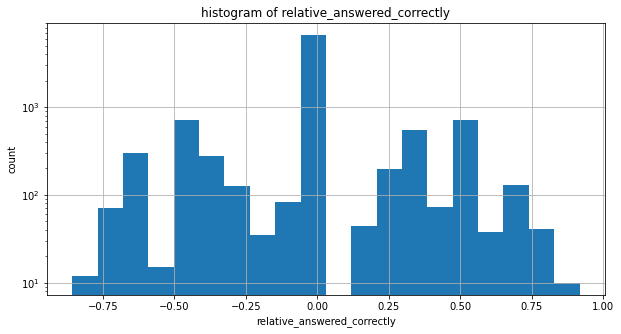

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
train_df['relative_answered_correctly'].hist(bins=20)

# y축은 로그 스케일로 그렸음에 주의하자
plt.yscale('log')

plt.grid('False')
plt.title('histogram of relative_answered_correctly')
plt.xlabel('relative_answered_correctly');
plt.ylabel('count');

##### `과거 (prior)` feature 생성
> 주어진 데이터 이전의 (prior) 데이터들의 통계값을 활용하는 feature를 생성한다

- 이전 문제 정답률
- 이전 문제 상대적인(relative) 정답률
- 각 문제 종류별로 이전에 몇번 풀었는지
- 각 파트별로 이전에 몇번 풀었는지
- 각 태그별로 이전에 몇번 풀었는지

In [ ]:
# 이전 문제 정답 횟수
train_df['prior_ac_count'] = train_df.groupby('user_id')['answered_correctly'].cumsum().shift(fill_value=0)

# 이전에 푼 문제 수
train_df['content_type_id'] = 1 - train_df['content_type_id']
train_df['prior_quest_count'] = train_df.groupby('user_id')['content_type_id'].cumsum().shift(fill_value=0)
train_df['content_type_id'] = 1 - train_df['content_type_id']

# 이전 문제 정답률
train_df['prior_ac_accuracy'] = (train_df['prior_ac_count'] / train_df['prior_quest_count']).fillna(0)

In [ ]:
# 이전 문제 상대적인(relative) 정답률
train_df['prior_relative_ac_sum'] = train_df.groupby('user_id')['relative_answered_correctly'].cumsum().shift(fill_value=0)
train_df['prior_relative_accuracy'] = (train_df['prior_relative_ac_sum'] / train_df['prior_quest_count']).fillna(0)

In [ ]:
# 각 문제 종류별로 이전에 몇번 풀었는지
# 1번 문제 3번 풀었다 / 3번 문제 1번 풀었다 ..etc
# clip(0, 255)는 메모리를 위해 uint8 데이터 타입을 쓰기 위함
train_df['prior_content_id_frequency'] = train_df.groupby(['user_id', 'content_id']).cumcount().clip(0, 255)

# 각 파트별로 이전에 몇번 풀었는지
train_df['prior_part_frequency'] = train_df.groupby(['user_id', 'part']).cumcount()

# 각 태그별로 이전에 몇번 풀었는지
train_df['prior_tags_frequency'] = train_df.groupby(['user_id', 'tags']).cumcount()

In [ ]:
train_df.iloc[:, -8:].sample(3)

,prior_ac_count,prior_quest_count,prior_ac_accuracy,prior_relative_ac_sum,prior_relative_accuracy,prior_content_id_frequency,prior_part_frequency,prior_tags_frequency
6135,2816,4115,0.684326,2.511652,0.000610,0,516,3
2707,579,803,0.721046,-9.036833,-0.011254,0,273,2
4362,1643,2392,0.686873,-6.621681,-0.002768,1,733,2


In [ ]:
user_start_id = train_df['user_id'].diff() > 0
features = ['prior_ac_accuracy',
            'prior_ac_count',
            'prior_quest_count',
            'prior_relative_ac_sum',
            'prior_relative_accuracy',
            'lag_time']
 
# 각 학생의 첫 row는 prior과 lagtime feature의 값을 0으로 초기화한다
train_df.loc[user_start_id, features] = 0

In [ ]:
train_df.iloc[94:100, :]['user_id']

94    2746
95    2746
96    5382
97    5382
98    5382
99    5382
Name: user_id, dtype: int64

In [ ]:
# 5382 학생의 첫 row가 True로 표시되는 것을 볼 수 있다
user_start_id[94:100]

94    False
95    False
96     True
97    False
98    False
99    False
Name: user_id, dtype: bool

##### `바로전 (previous)` feature 생성
> 주어진 데이터 바로 이전의 (previous) 데이터 활용하는 feature를 생성한다

- 각 문제 종류별 마지막으로 푼 시점으로부터 지난 시간
- 각 문제 종류별 마지막으로 풀었을때 정답 여부

In [ ]:
# 각 문제 종류별 마지막으로 푼 시간
prev_timestamp_ac = train_df.groupby(['user_id', 'content_id'])[['timestamp']].shift()        

# 각 문제 종류별 마지막으로 푼 시점으로부터 지난 시간
# 해당 문제 종류를 마지막으로 푼 시점으로부터 시간이 오래 지날수록 문제를 맞추기 힘들 것이다
train_df['diff_time_btw_content_ids'] = (train_df['timestamp'] - prev_timestamp_ac['timestamp'])

# nan값은 [ diff_time_btw_content_ids ] 데이터 중 최대값으로 imputation을 한다
max_diff_time_btw_content_ids = train_df['diff_time_btw_content_ids'].max()
train_df['diff_time_btw_content_ids'] = train_df['diff_time_btw_content_ids'].fillna(max_diff_time_btw_content_ids)          

In [ ]:
# 15018817초는 약 173일이다
max_diff_time_btw_content_ids

15018817.0

In [ ]:
# 각 문제 종류별 마지막으로 풀었을때 정답 여부
prev_correct_ac = train_df.groupby(['user_id', 'content_id'])[['answered_correctly']].shift()        
train_df['prev_answered_correctly'] = prev_correct_ac['answered_correctly'].fillna(0)

In [ ]:
train_df['prev_answered_correctly'].value_counts()

0.0    9585
1.0     415
Name: prev_answered_correctly, dtype: int64

#### 🟡 트랜스폼 (Transform)
> 로그 스케일링! skew한 분포를 normal 분포로!

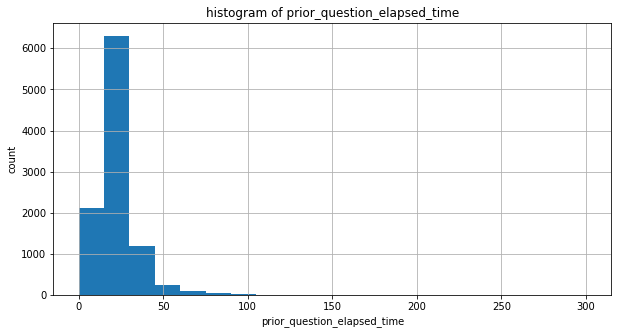

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
train_df['prior_question_elapsed_time'].hist(bins=20)

plt.grid('False')
plt.title('histogram of prior_question_elapsed_time')
plt.xlabel('prior_question_elapsed_time');
plt.ylabel('count');

In [ ]:
import numpy as np

log1p_cols = ['timestamp',
              'prior_question_elapsed_time',
              'prior_part_frequency',
              'prior_tags_frequency',
              'prior_content_id_frequency',
              'diff_time_btw_content_ids',
              'lag_time']

train_df[log1p_cols] = np.log1p(train_df[log1p_cols])

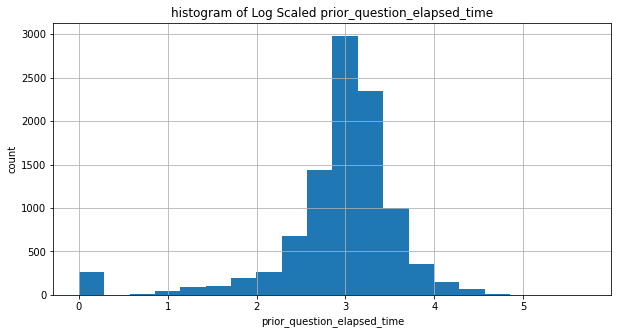

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
train_df['prior_question_elapsed_time'].hist(bins=20)

plt.grid('False')
plt.title('histogram of Log Scaled prior_question_elapsed_time')
plt.xlabel('prior_question_elapsed_time');
plt.ylabel('count');

#### 🟡 범주형 / 수치형 feature 데이터 타입 변환

In [ ]:
cont_cols = ['timestamp',
             'content_type_id',
             'prior_question_elapsed_time',
             'prior_question_had_explanation',
             'prior_content_id_frequency',
             'prior_part_frequency',
             'prior_tags_frequency',
             'prior_ac_accuracy',
             'accuracy_avg_by_part',
             'accuracy_avg_by_content_id',
             'accuracy_avg_by_tags',
             'lag_time',
             'prior_relative_ac_sum',
             'prior_relative_accuracy',
             'diff_time_btw_content_ids',
             'prev_answered_correctly',
             'relative_answered_correctly',
             'answered_correctly']

cate_cols = ['content_id', 'tags', 'type_of', 'part'] 

train_df[cate_cols] = train_df[cate_cols].astype(np.int16)
train_df[cont_cols] = train_df[cont_cols].astype(np.float32)     

#### 🟡 전처리가 끝나고 우리에게 남은 것
> 긴 전처리 과정이 끝나고 3개의 pandas DataFrame에서 출발하여 우리는 훈련에 필요한 데이터들을 얻었다. 이는 다음과 같다.

- `train_df` : 핵심 훈련 데이터. feature engineering을 통해 feature수가 많이 증가했다.
- `cate2id_dict` : 각 범주형 feature를 embedding이 가능하도록 index로 바꿔주는 dictionary

**column 이름**
- `offset` : 범주형 feature들의 값들의 총 갯수
- `cate_cols` : 범주형 feature들의 column 이름
- `cont_cols` : 수치형 feature들의 column 이름

**훈련 데이터셋 sequence 정보**
- `question_row_ids_by_user_id` : 훈련셋의 sequence 데이터들의 `train_df`에서의 indices
- `start_row_id_by_user_id` : 훈련셋의 각 sequence 데이터들의 `train_df`에서의 첫 row의 index

In [ ]:
print(f"훈련 데이터셋 shape : {train_df.shape}")
print(f"category 값들의 총 갯수 : {offset}")
print(f"category feature들의 column 이름 : {cate_cols}")
print(f"continuous feature들의 column 이름 : {cont_cols}")

훈련 데이터셋 shape : (10000, 29)
category 값들의 총 갯수 : 15549
category feature들의 column 이름 : ['content_id', 'tags', 'type_of', 'part']
continuous feature들의 column 이름 : ['timestamp', 'content_type_id', 'prior_question_elapsed_time', 'prior_question_had_explanation', 'prior_content_id_frequency', 'prior_part_frequency', 'prior_tags_frequency', 'prior_ac_accuracy', 'accuracy_avg_by_part', 'accuracy_avg_by_content_id', 'accuracy_avg_by_tags', 'lag_time', 'prior_relative_ac_sum', 'prior_relative_accuracy', 'diff_time_btw_content_ids', 'prev_answered_correctly', 'relative_answered_correctly', 'answered_correctly']


In [ ]:
print(f"category feature들의 index : {cate2id_dict}")

category feature들의 index : {'type2id': {'concept': 1, 'solving question': 2, 'intention': 3, 'starter': 4}, 'part2id': {5: 5, 1: 6, 6: 7, 2: 8, 7: 9, 3: 10, 4: 11}, 'tags2id': {'51 131 162 38': 12, '131 36 81': 13, '131 101 162 92': 14, '131 149 162 29': 15, '131 5 162 38': 16, '131 149 162 81': 17, '10 94 162 92': 18, '61 110 162 29': 19, '131 13 162 92': 20, '10 164 81': 21, '131 36 38': 22, '51 131 81': 23, '51 131 92': 24, '131 5 29': 25, '131 101 38': 26, '61 110 81': 27, '131 99 92': 28, '131 93 162 29': 29, '61 110 92': 30, '10 70 162 81': 31, '131 149 162 38': 32, '9 10 162 81': 33, '131 5 92': 34, '9 10 29': 35, '9 10 38': 36, '9 10 81': 37, '131 104 162 92': 38, '131 104 92': 39, '131 13 162 81': 40, '131 40 162 81': 41, '131 93 162 38': 42, '9 10 92': 43, '131 5 81': 44, '131 40 81': 45, '10 70 162 92': 46, '10 94 38': 47, '131 104 38': 48, '131 93 162 81': 49, '131 130 92': 50, '131 13 162 29': 51, '10 164 162 81': 52, '9 10 162 92': 53, '131 187 81': 54, '131 36 162 81': 5

In [ ]:
print(f"train셋 sequence 데이터들의 indices : {question_row_ids_by_user_id}\n")
print(f"train셋 각 sequence 데이터들의 첫 row의 index : {start_row_id_by_user_id}")

train셋 sequence 데이터들의 indices : user_id
115      [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
124      [46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 5...
2746     [76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 8...
5382     [96, 97, 98, 99, 100, 101, 102, 103, 104, 105,...
8623     [224, 225, 226, 227, 228, 229, 230, 231, 232, ...
8701     [336, 337, 338, 339, 340, 341, 342, 343, 344, ...
12741    [353, 354, 355, 356, 357, 358, 359, 360, 361, ...
13134    [624, 625, 626, 627, 628, 629, 630, 631, 632, ...
24418    [1874, 1875, 1876, 1877, 1878, 1879, 1880, 188...
24600    [8338, 8339, 8340, 8341, 8342, 8343, 8344, 834...
32421    [8388, 8389, 8390, 8391, 8392, 8393, 8394, 839...
40828    [8418, 8419, 8420, 8421, 8422, 8423, 8424, 842...
44331    [8511, 8512, 8513, 8514, 8515, 8516, 8517, 851...
45001    [8805, 8806, 8807, 8808, 8809, 8810, 8811, 881...
46886    [8835, 8836, 8837, 8838, 8839, 8840, 8841, 884...
50132    [8880, 8881, 8882, 8883, 8884, 8885, 8886, 888...
51285    [8954, 

### 📗 CFG (Configuration) class
> 모든 설정 값을 관리하는 CFG 클래스다. 이를 통해 다양한 실험을 손쉽게 관리가능하다. 우리는 input, output에 목적을 두고 있는만큼 모델과 데이터셋에 관련된 configuration 값들만을 사용한다. 

In [ ]:
class CFG:
    seed=7
    device='cpu'

    batch_size=16

    dropout=0.2
    emb_size=100
    hidden_size=128
    nlayers=2
    nheads=8
  
    seq_len=32
    target_size=1


In [ ]:
CFG.total_cate_size = offset
CFG.cate_cols = cate_cols
CFG.cont_cols = cont_cols
CFG.start_row_id_by_user_id = start_row_id_by_user_id

CFG.cate_vocab_size = offset

CFG.cate_col_size = len(cate_cols)
CFG.cont_col_size = len(cont_cols)

### 📗 데이터셋 및 데이터 로더 (Dataset and DataLoader)
> 전처리에서 생성한 데이터들을 토대로 훈련에 바로 사용할 수 있는 데이터셋을 만들자. 우리는 여기서 범주형, 수치형 데이터로 나눠 출력한다! 아래를 살펴보면서 이렇게 출력된 데이터를 어떻게 embedding할 수 있을지 잠시 고민해보자!

#### 🟡 데이터 증강 (Data Augmentation)을 위한 index 목록
> 따로 augmentation이라고 표현하진 않았지만 여기서 사용되는 데이터셋 코드에는 augmentation이 적용되어있다. 이를 사용하기 위한 index 목록을 만들기 위해 아래와 같은 과정을 거친다.

훈련에 사용할 sequence들의 index목록을 다시 정리하자

In [ ]:
# 이 sequence들의 index들을 그대로 사용하지 않는다
question_row_ids_by_user_id

user_id
115      [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
124      [46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 5...
2746     [76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 8...
5382     [96, 97, 98, 99, 100, 101, 102, 103, 104, 105,...
8623     [224, 225, 226, 227, 228, 229, 230, 231, 232, ...
8701     [336, 337, 338, 339, 340, 341, 342, 343, 344, ...
12741    [353, 354, 355, 356, 357, 358, 359, 360, 361, ...
13134    [624, 625, 626, 627, 628, 629, 630, 631, 632, ...
24418    [1874, 1875, 1876, 1877, 1878, 1879, 1880, 188...
24600    [8338, 8339, 8340, 8341, 8342, 8343, 8344, 834...
32421    [8388, 8389, 8390, 8391, 8392, 8393, 8394, 839...
40828    [8418, 8419, 8420, 8421, 8422, 8423, 8424, 842...
44331    [8511, 8512, 8513, 8514, 8515, 8516, 8517, 851...
45001    [8805, 8806, 8807, 8808, 8809, 8810, 8811, 881...
46886    [8835, 8836, 8837, 8838, 8839, 8840, 8841, 884...
50132    [8880, 8881, 8882, 8883, 8884, 8885, 8886, 888...
51285    [8954, 8955, 8956, 8957, 8958, 8959, 89

In [ ]:
train_user_id_row_id_list = [(user_id, row_id)
                             for user_id, row_ids in question_row_ids_by_user_id.items()
                             for row_id in row_ids]
train_user_id_row_id_list[:10]

[(115, 0),
 (115, 1),
 (115, 2),
 (115, 3),
 (115, 4),
 (115, 5),
 (115, 6),
 (115, 7),
 (115, 8),
 (115, 9)]

In [ ]:
# row가 10,000개인데 sequence 데이터의 갯수가 9763개다! 꽤나 늘어났음을 알 수 있다.
len(train_user_id_row_id_list)

9763

In [ ]:
# configuration에 등록!
CFG.train_user_id_row_id_list = train_user_id_row_id_list

위와 같이 처리하는 이유는 각 학생의 sequence안에서 다양한 길이의 데이터를 사용하기 위함이다. 예시를 들자면 다음과 같다.

``` python
학생 A : [1, 2, 3, 4, 5]
```

이 경우에 `train_user_id_row_id_list`는 다음과 같이 표현된다.
``` python
[(A, 0),
 (A, 1),
 (A, 2),
 (A, 3),
 (A, 4)]
```

우리는 `start_row_id_by_user_id`를 통해 학생 A의 시작 `row_id`를 알고 있고 위의 `train_user_id_row_id_list`를 sequence가 끝나는 위치의 `row_id`라고 하면 다음과 같은 5개의 sequence 데이터를 훈련에 사용할 수 있다.

``` python
[1,     <pad>, <pad>, <pad>, <pad>]
[1,     2,     <pad>, <pad>, <pad>]
[1,     2,     3,     <pad>, <pad>]
[1,     2,     3,     4,     <pad>]
[1,     2,     3,     4,     5    ]
```
    

#### 🟡 코드

In [ ]:
train_df[cate_cols]

,content_id,tags,type_of,part
0,7718,1072,0,5
1,7742,1054,0,5
2,2154,92,0,6
3,9886,77,0,6
4,9948,92,0,6
...,...,...,...,...
9995,3150,355,0,8
9996,2836,412,0,8
9997,3271,277,0,8
9998,2737,144,0,8


In [ ]:
train_df[cont_cols]

,timestamp,content_type_id,prior_question_elapsed_time,prior_question_had_explanation,prior_content_id_frequency,prior_part_frequency,prior_tags_frequency,prior_ac_accuracy,accuracy_avg_by_part,accuracy_avg_by_content_id,accuracy_avg_by_tags,lag_time,prior_relative_ac_sum,prior_relative_accuracy,diff_time_btw_content_ids,prev_answered_correctly,relative_answered_correctly,answered_correctly
0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.640435,1.000000,0.578947,0.000000,0.000000,0.000000,16.524815,0.0,0.000000,1.0
1,4.043051,0.0,3.637586,0.0,0.0,0.693147,0.000000,1.000000,0.640435,1.000000,0.750000,4.043051,0.000000,0.000000,16.524815,0.0,0.000000,1.0
2,4.779123,0.0,4.025352,0.0,0.0,0.000000,0.000000,1.000000,0.754146,1.000000,0.785714,4.143135,0.000000,0.000000,16.524815,0.0,0.000000,1.0
3,4.882802,0.0,2.995732,0.0,0.0,0.693147,0.000000,1.000000,0.754146,1.000000,0.750000,2.639057,0.000000,0.000000,16.524815,0.0,0.000000,1.0
4,4.927254,0.0,2.484907,0.0,0.0,1.098612,0.693147,1.000000,0.754146,1.000000,0.785714,1.945910,0.000000,0.000000,16.524815,0.0,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,14.869191,0.0,2.944439,1.0,0.0,4.828314,0.000000,0.670692,0.703837,0.500000,0.666667,4.718499,-7.367785,-0.008088,16.524815,0.0,-0.500000,0.0
9996,14.869221,0.0,2.944439,1.0,0.0,4.836282,0.693147,0.669956,0.703837,1.000000,0.600000,4.454347,-7.867785,-0.008627,16.524815,0.0,0.000000,1.0
9997,14.869254,0.0,2.890372,1.0,0.0,4.844187,0.000000,0.670318,0.703837,0.333333,0.500000,4.564348,-7.867785,-0.008618,16.524815,0.0,0.666667,1.0
9998,14.869279,0.0,2.890372,1.0,0.0,4.852030,0.000000,0.670678,0.703837,1.000000,0.650000,4.290460,-7.201118,-0.007879,16.524815,0.0,0.000000,1.0


In [ ]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class RiiidDataset(Dataset):
    def __init__(self, df, cfg, max_seq_len=100, max_content_len=1000):        
        
        self.max_seq_len = max_seq_len
        self.max_content_len = max_content_len
        
        self.user_id_row_id_list = cfg.train_user_id_row_id_list
        self.start_row_id_by_user_id = cfg.start_row_id_by_user_id

        self.cate_cols = cfg.cate_cols
        self.cont_cols = cfg.cont_cols
        
        self.cate_features = df[self.cate_cols].values
        self.cont_features = df[self.cont_cols].values

    def __getitem__(self, idx):
        
        user_id, end_row_id = self.user_id_row_id_list[idx]
        end_row_id += 1
        
        start_row_id = self.start_row_id_by_user_id[user_id]
        start_row_id = max(end_row_id - self.max_seq_len, start_row_id) # lower bound
        seq_len = end_row_id - start_row_id

        # 0으로 채워진 output tensor 제작                  
        cate_feature = torch.zeros(self.max_seq_len, len(self.cate_cols), dtype=torch.long)
        cont_feature = torch.zeros(self.max_seq_len, len(self.cont_cols), dtype=torch.float)
        mask = torch.zeros(self.max_seq_len, dtype=torch.int16)
       
        # tensor에 값 채워넣기
        cate_feature[-seq_len:] = torch.ShortTensor(self.cate_features[start_row_id:end_row_id])
        cont_feature[-seq_len:] = torch.HalfTensor(self.cont_features[start_row_id:end_row_id])
        mask[-seq_len:] = 1        
            
        # answered_correctly가 cont_feature[-1]에 위치한다
        target = torch.FloatTensor([cont_feature[-1, -1]])

        # answered_correctly 및 relative_answered_correctly는
        # data leakage가 발생할 수 있으므로 0으로 모두 채운다
        cont_feature[-1, -1] = 0
        cont_feature[-1, -2] = 0
        
        return cate_feature, cont_feature, mask, target
        
    def __len__(self):
        return len(self.user_id_row_id_list)


In [ ]:
train_db = RiiidDataset(train_df, CFG, max_seq_len=CFG.seq_len)
train_loader = DataLoader(train_db, batch_size=CFG.batch_size, shuffle=True,
                          drop_last=False, pin_memory=True)    

In [ ]:
# sequence 데이터 하나의 shape을 살펴보자
for cate_x, cont_x, mask, target in train_db:
    print(f"category size : {cate_x.size()}")
    print(f"continous size : {cont_x.size()}")
    print(f"mask size : {mask.size()}")
    print(f"target size : {target.size()}")
    break

category size : torch.Size([32, 4])
continous size : torch.Size([32, 18])
mask size : torch.Size([32])
target size : torch.Size([1])


In [ ]:
# 배치 단위로 주어지는 데이터를 살펴보자
for cate_x, cont_x, mask, target in train_loader:
    print(f"category size : {cate_x.size()}")
    print(f"continous size : {cont_x.size()}")
    print(f"mask size : {mask.size()}")
    print(f"target size : {target.size()}")
    break

category size : torch.Size([16, 32, 4])
continous size : torch.Size([16, 32, 18])
mask size : torch.Size([16, 32])
target size : torch.Size([16, 1])


### 📗 Transformer Input / Output 구현
> transformer에 입력시킬 input을 구현하고 transformer를 거친 output을 우리가 원하는 최종 출력값으로 바꾼다.

In [ ]:
import torch.nn as nn

# 입력값
for cate_x, cont_x, mask, target in train_loader:
    print(f"category size : {cate_x.size()}")
    print(f"continous size : {cont_x.size()}")
    print(f"mask size : {mask.size()}\n")
    break

category size : torch.Size([16, 32, 4])
continous size : torch.Size([16, 32, 18])
mask size : torch.Size([16, 32])



#### 🟡 Category Embedding
> 범주형 feature를 임베딩하는 과정을 살펴보자!


In [ ]:
cate_x.size()

torch.Size([16, 32, 4])

In [ ]:
# 임베딩 크기
CFG.emb_size

100

In [ ]:
batch_size = cate_x.size(0)

# 범주형 하나당 100개로 임베딩된다!
# [16, 32, 4] -> [16, 32, 4, 100]
cate_emb = nn.Embedding(CFG.total_cate_size, CFG.emb_size, padding_idx=0)
cate_embed_x = cate_emb(cate_x)

cate_embed_x.size()

torch.Size([16, 32, 4, 100])

`n_rows_per_step`을 이용하여 sequence 길이를 조절할 수 있다. 현재 해당 값은 **2**로 우리는 sequence의 길이가 2배만큼 줄여질 것을 알 수 있다.

In [ ]:
# sequence 길이를 몇 배 줄일 것인지
# 메모리 절약의 의도가 있다
CFG.n_rows_per_step = 2

- 일반적인 경우 `[16, 32, 400]`

In [ ]:
cate_embed_normal_x = cate_embed_x.view(batch_size, CFG.seq_len, -1)
cate_embed_normal_x.size()

torch.Size([16, 32, 400])

- sequence 길이를 줄여 메모리 절약 `[16, 16, 800]`

In [ ]:
half_seq_len = cate_x.size(1) // CFG.n_rows_per_step

# transformer input은 3차원이고 마지막 차원은 hidden 값이다.
# sequence의 각 위치에 카테고리별로 임베딩되어있는 것을 하나로 합치자!
# [16, 32, 4, 100] -> [16, 16, 800]
cate_embed_x = cate_embed_x.view(batch_size, half_seq_len, -1)
cate_embed_x.size()

torch.Size([16, 16, 800])

In [ ]:
# 이후에 우리가 원하는 hidden_size의 절반으로 projection한다!
# 이렇게 하는 이유는 반은 category로 반은 continous으로 hidden 값을 채우기 위해서이다
# [16, 16, 800] -> [16, 16, 128]
cate_proj = nn.Sequential(nn.Linear(CFG.emb_size * CFG.cate_col_size * CFG.n_rows_per_step, CFG.hidden_size),
                          nn.LayerNorm(CFG.hidden_size))     
cate_embed_x = cate_proj(cate_embed_x)
cate_embed_x.size()

torch.Size([16, 16, 128])

#### 🟡 Continuous Embedding
> 수치형 feature를 임베딩하는 과정을 살펴보자!


In [ ]:
cont_x.size()

torch.Size([16, 32, 18])

In [ ]:
cont_bn = nn.BatchNorm1d(CFG.cont_col_size)

# batchnorm 1d 적용
cont_bn_x = cont_bn(cont_x.view(-1, cont_x.size(-1)))
cont_bn_x.size()

torch.Size([512, 18])

In [ ]:
# batchnorm 적용 이후 원래 사이즈 복구
cont_bn_x = cont_bn_x.view(batch_size, -1, cont_x.size(-1))
cont_bn_x.size()

torch.Size([16, 32, 18])

In [ ]:
# cate에서 사용한 half_seq_len 그대로 사용
cont_bn_x = cont_bn_x.view(batch_size, half_seq_len, -1)
cont_bn_x.size()

torch.Size([16, 16, 36])

In [ ]:
# 범주형과는 다르게 embedding없이 바로 projection을 통해 원하는 사이즈로 줄인다
# 여기서는 embedding이라고 부른다
# [16, 16, 36] -> [16, 16, 128]
cont_emb = nn.Sequential(nn.Linear(CFG.cont_col_size * CFG.n_rows_per_step, CFG.hidden_size),
                         nn.LayerNorm(CFG.hidden_size))
cont_embed_x = cont_emb(cont_bn_x)
cont_embed_x.size()

torch.Size([16, 16, 128])

#### 🟡 범주형 / 수치형 embedding tensor concat
> Transformer에 입력값으로 주려면 범주형 / 수치형으로 embedding된 2개의 tensor를 하나로 합쳐야 한다. 이를 통해 우리는 많은 feature들이 포함된 데이터를 성공적으로 하나의 입력값으로 만들 수 있다!

In [ ]:
cate_embed_x.size(), cont_embed_x.size()

(torch.Size([16, 16, 128]), torch.Size([16, 16, 128]))

In [ ]:
seq_emb = torch.cat([cate_embed_x, cont_embed_x], 2)
seq_emb.size()

torch.Size([16, 16, 256])

In [ ]:
comb_proj = nn.Sequential(nn.ReLU(),
                          nn.Linear(CFG.hidden_size*2, CFG.hidden_size),
                          nn.LayerNorm(CFG.hidden_size))

# concat한 sequence를 projection을 통해 원하는 사이즈로 변환한다
# 여기서는 embedding이라고 부른다
# [16, 16, 256] -> [16, 16, 128]
seq_emb = comb_proj(seq_emb)
seq_emb.size()

torch.Size([16, 16, 128])

#### 🟡 Encoder
> 이제 완성된 입력값을 모델에 넣어보자!

In [ ]:
!pip install -q transformers

     |████████████████████████████████| 2.0MB 25.3MB/s 
     |████████████████████████████████| 870kB 45.6MB/s 
     |████████████████████████████████| 3.3MB 39.6MB/s 


In [ ]:
try:
    from transformers.modeling_bert import BertConfig, BertEncoder, BertModel    
except:
    from transformers.models.bert.modeling_bert import BertConfig, BertEncoder, BertModel   

config = BertConfig(3, # not used
                    hidden_size=CFG.hidden_size,
                    num_hidden_layers=CFG.nlayers,
                    num_attention_heads=CFG.nheads,
                    intermediate_size=CFG.hidden_size,
                    hidden_dropout_prob=CFG.dropout,
                    attention_probs_dropout_prob=CFG.dropout)

encoder = BertEncoder(config)   

In [ ]:
# Bert Encoder를 거친 tensor의 크기는 동일하게 나온다
# [16, 16, 128] -> [16, 16, 128]
encoded_layers = encoder(seq_emb)
sequence_output = encoded_layers[-1]
sequence_output.size()

torch.Size([16, 16, 128])

In [ ]:
# 우리가 필요한건 Bert의 마지막 query다
# [16, 16, 128] -> [16, 128]
sequence_output = sequence_output[:, -1]
sequence_output.size()

torch.Size([16, 128])

#### 🟡 분류 단계
> 이제 우리는 최종 분류를 해야한다! 이걸 위해서 우리는 출력의 크기를 클래스 숫자인 1로 변환한다!

In [ ]:
def get_reg():
    return nn.Sequential(nn.Linear(CFG.hidden_size, CFG.hidden_size),
                         nn.LayerNorm(CFG.hidden_size),
                         nn.Dropout(CFG.dropout),
                         nn.ReLU(),
                         nn.Linear(CFG.hidden_size, CFG.target_size))

reg_layer = get_reg()

In [ ]:
# 😍 우리는 원하는 결과값을 얻었다 😍
# [16, 128] -> [16, 1]
pred_y = reg_layer(sequence_output)
pred_y.size()

torch.Size([16, 1])

#### 🟡 클래스로 만들자!
> 우리는 위에서 단계별로 입력값의 변화를 살펴보았다. 이제 이를 하나의 모델로 구축하자.

In [ ]:
!pip install -q transformers

In [ ]:
CFG.n_rows_per_step = 2

In [ ]:
import torch.nn as nn

try:
    from transformers.modeling_bert import BertConfig, BertEncoder, BertModel    
except:
    from transformers.models.bert.modeling_bert import BertConfig, BertEncoder, BertModel   

class TransformerModel(nn.Module):
    def __init__(self, cfg):
        super(TransformerModel, self).__init__()
        self.cfg = cfg

        cate_col_size = len(cfg.cate_cols)
        cont_col_size = len(cfg.cont_cols)

        # category
        self.cate_emb = nn.Embedding(cfg.total_cate_size, cfg.emb_size, padding_idx=0)
        self.cate_proj = nn.Sequential(
            nn.Linear(cfg.emb_size * cfg.cate_col_size * cfg.n_rows_per_step, cfg.hidden_size),
            nn.LayerNorm(cfg.hidden_size),
        )

        # continuous
        self.cont_bn = nn.BatchNorm1d(cfg.cont_col_size)
        self.cont_emb = nn.Sequential(
            nn.Linear(cfg.cont_col_size*cfg.n_rows_per_step, cfg.hidden_size),
            nn.LayerNorm(cfg.hidden_size),
        )

        # combination
        self.comb_proj = nn.Sequential(
            nn.ReLU(),
            nn.Linear(cfg.hidden_size*2, cfg.hidden_size),
            nn.LayerNorm(cfg.hidden_size),
        )
        
        self.config = BertConfig( 
            3, # not used
            hidden_size=cfg.hidden_size,
            num_hidden_layers=cfg.nlayers,
            num_attention_heads=cfg.nheads,
            intermediate_size=cfg.hidden_size,
            hidden_dropout_prob=cfg.dropout,
            attention_probs_dropout_prob=cfg.dropout,
        )
        self.encoder = BertEncoder(self.config)        
        
        def get_reg():
            return nn.Sequential(
            nn.Linear(cfg.hidden_size, cfg.hidden_size),
            nn.LayerNorm(cfg.hidden_size),
            nn.Dropout(cfg.dropout),
            nn.ReLU(),            
            nn.Linear(cfg.hidden_size, cfg.target_size),
        )     
        self.reg_layer = get_reg()
        
    def forward(self, cate_x, cont_x, mask):        
        batch_size = cate_x.size(0)
        half_seq_len = cate_x.size(1) // self.cfg.n_rows_per_step
        
        # category
        cate_emb = self.cate_emb(cate_x).view(batch_size, half_seq_len, -1)
        cate_emb = self.cate_proj(cate_emb)

        # continuous
        cont_x = self.cont_bn(cont_x.view(-1, cont_x.size(-1))).view(batch_size, -1, cont_x.size(-1))
        cont_emb = self.cont_emb(cont_x.view(batch_size, half_seq_len, -1))        
        
        # combination
        seq_emb = torch.cat([cate_emb, cont_emb], 2)        
        seq_emb = self.comb_proj(seq_emb)   
        
        mask, _ = mask.view(batch_size, half_seq_len, -1).max(2)
        
        encoded_layers = self.encoder(seq_emb, attention_mask=mask)
        sequence_output = encoded_layers[0]
        sequence_output = sequence_output[:, -1]        
        
        pred_y = self.reg_layer(sequence_output)

        return pred_y


In [ ]:
# 모델 생성
model = TransformerModel(CFG)

for cate_x, cont_x, mask, target in train_loader:
    print(f"category size : {cate_x.size()}")
    print(f"continous size : {cont_x.size()}")
    print(f"mask size : {mask.size()}\n")

    output = model(cate_x, cont_x, mask)
    
    print(f"output size : {output.size()}")
    print(f"target size : {target.size()}")
    break

category size : torch.Size([16, 32, 4])
continous size : torch.Size([16, 32, 18])
mask size : torch.Size([16, 32])

output size : torch.Size([16, 1])
target size : torch.Size([16, 1])


## 💎 [Predicting Molecular Properties](https://www.kaggle.com/c/champs-scalar-coupling/overview)
**Can you measure the magnetic interactions between a pair of atoms?**

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/14313/logos/header.png?t=2019-05-16-16-54-31&quot" width=700>

**살펴보면 좋은 핵심들**
> 앞서 살펴본 2개의 대회로 인해 이제 input에서 output까지의 흐름에 익숙해졌을 것이다. 여기서도 마찬가지지만 한가지 다른 점은 classification이 아닌 regression이라는 점이다. 하지만 달라지는 점은 크게 없다는 것을 알 수 있을 것이다 😄
1. **Postional Encoding을 사용하지 않는 Transformer**
    - 해당 솔루션은 Position Encoding을 사용하지 않는다! 이 점에 주의해서 살펴보자!
2. **pseudo-invariance를 위한 Data Augmentation**
    - 어렵게 써놨는데 간단하다. 그냥 분자가 어떤 위치 혹은 각도로 기울어져 있던 상관없이 같은 분자면 동일하게 취급하는 모델을 만들기 위해, 분자를 랜덤하게 회전시키고 이동시켜 입력으로 넣어주는 것이다.
    - `좌표값`이 입력으로 주어지기 때문에 가능한 방법이다
3. **원자쌍의 type별로 다른 prediction layer**
    - 모든 원자쌍에 하나의 예측 layer를 사용하지 않고 원자쌍 type별로 전부 다른 예측 layer를 사용할 수 있다!
    - 아이디어는 간단하지만 구현은 헷갈릴 수 있으니 관심이 있다면 코드와 함께 찬찬히 살펴보자!


**molecule 3등 솔루션**
- [설명](https://www.kaggle.com/c/champs-scalar-coupling/discussion/106572)

In [ ]:
import pandas as pd

# Molecular 데이터셋 path 설정
MOLECULE_PATH = os.path.join(DATA_PATH, 'MOLECULE')

# 데이터셋 불러오기

# 사용되는 데이터
train_df = pd.read_csv(os.path.join(MOLECULE_PATH, 'train.csv'))
structures_df = pd.read_csv(os.path.join(MOLECULE_PATH, 'structures.csv'))
scalar_coupling_contributions_df = pd.read_csv(os.path.join(MOLECULE_PATH, 'scalar_coupling_contributions.csv'))

# 사용되지 않는 데이터
dipole_moments_df = pd.read_csv(os.path.join(MOLECULE_PATH, 'dipole_moments.csv'))
magnetic_shielding_tensors_df = pd.read_csv(os.path.join(MOLECULE_PATH, 'magnetic_shielding_tensors.csv'))
mulliken_charges_df = pd.read_csv(os.path.join(MOLECULE_PATH, 'mulliken_charges.csv'))
potential_energy_df = pd.read_csv(os.path.join(MOLECULE_PATH, 'potential_energy.csv'))

### 💍 EDA (Exploratory Data Analysis)
> 간단하게 데이터를 살펴보면서 이 데이터를 어떻게 하면 Transformer input으로 바꿀 수 있을지 생각해보자!

In [ ]:
# 분자의 원자간 정보가 순서대로 나열되어있다
train_df.head(5)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074


In [ ]:
# 분자의 sequence길이는 최대 86으로 나온다
# 현재 데이터셋은 일부만 사용하고 있기 때문에 이 정보는 정확하지 않다
train_df.groupby('molecule_name')['molecule_name'].count().max()

86

In [ ]:
dipole_moments_df.sample(5)

,molecule_name,X,Y,Z
254,dsgdb9nsd_000430,0.7597,0.7839,0.5067
32,dsgdb9nsd_000046,1.1002,0.0004,-0.8486
188,dsgdb9nsd_000315,0.0000,0.0000,-1.3233
197,dsgdb9nsd_000336,1.1789,2.4546,0.1522
298,dsgdb9nsd_000504,-0.7192,1.4672,0.9349


In [ ]:
magnetic_shielding_tensors_df.sample(5)

,molecule_name,atom_index,XX,YX,ZX,XY,YY,ZY,XZ,YZ,ZZ
2197,dsgdb9nsd_000328,10,36.1474,5.5743,2.7494,5.5494,27.9723,1.3464,2.3431,1.1450,25.7354
3269,dsgdb9nsd_000463,10,26.9226,-0.1653,0.5198,-0.4942,28.5572,3.2975,0.0050,4.3791,27.0792
191,dsgdb9nsd_000036,8,25.2682,-1.3958,-0.0005,4.6763,25.2517,-0.0017,-0.0019,0.0004,19.9489
3514,dsgdb9nsd_000500,0,-246.7658,248.8456,33.6247,253.7201,127.3477,89.5720,-1.0867,118.1157,-185.7073
2934,dsgdb9nsd_000418,5,176.7337,6.7771,4.1656,7.4062,202.3019,6.2802,12.0829,0.1747,159.7987


In [ ]:
mulliken_charges_df.sample(5)

,molecule_name,atom_index,mulliken_charge
952,dsgdb9nsd_000135,9,0.106369
644,dsgdb9nsd_000101,4,-0.417642
2895,dsgdb9nsd_000410,8,0.143792
631,dsgdb9nsd_000099,2,-0.093519
3434,dsgdb9nsd_000484,5,-0.648309


In [ ]:
potential_energy_df.sample(5)

,molecule_name,potential_energy
100,dsgdb9nsd_000143,-226.176329
256,dsgdb9nsd_000433,-271.765505
0,dsgdb9nsd_000001,-40.523680
305,dsgdb9nsd_000513,-268.034214
178,dsgdb9nsd_000293,-308.913030


In [ ]:
scalar_coupling_contributions_df.head(10)

,molecule_name,atom_index_0,atom_index_1,type,fc,sd,pso,dso
0,dsgdb9nsd_000001,1,0,1JHC,83.0224,0.254579,1.25862,0.272010
1,dsgdb9nsd_000001,1,2,2JHH,-11.0347,0.352978,2.85839,-3.433600
2,dsgdb9nsd_000001,1,3,2JHH,-11.0325,0.352944,2.85852,-3.433870
3,dsgdb9nsd_000001,1,4,2JHH,-11.0319,0.352934,2.85855,-3.433930
4,dsgdb9nsd_000001,2,0,1JHC,83.0222,0.254585,1.25861,0.272013
5,dsgdb9nsd_000001,2,3,2JHH,-11.0317,0.352932,2.85856,-3.433950
6,dsgdb9nsd_000001,2,4,2JHH,-11.0324,0.352943,2.85853,-3.433870
7,dsgdb9nsd_000001,3,0,1JHC,83.0241,0.254634,1.25856,0.272012
8,dsgdb9nsd_000001,3,4,2JHH,-11.0319,0.352943,2.85856,-3.433930
9,dsgdb9nsd_000001,4,0,1JHC,83.0243,0.254628,1.25856,0.272012


In [ ]:
structures_df.head(10)

,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397
5,dsgdb9nsd_000002,0,N,-0.040426,1.024108,0.062564
6,dsgdb9nsd_000002,1,H,0.017257,0.012545,-0.027377
7,dsgdb9nsd_000002,2,H,0.915789,1.358745,-0.028758
8,dsgdb9nsd_000002,3,H,-0.520278,1.343532,-0.775543
9,dsgdb9nsd_000003,0,O,-0.034360,0.977540,0.007602


### 💍 전처리 (Preprocessing)
> train과 관련된 데이터셋이 7개로 나뉘어져 주어졌다! 이를 합치는 것은 물론 데이터의 품질을 개선시키고 훈련에 바로 사용할 수 없는 feature들을 어떻게 훈련에 사용할 수 있게 바꿀 수 있을지 생각해보자!

#### 🔵 특성 공학 (Feature Engineering)
> 우리의 학습을 더욱 쉽게 하기 위한 새로운 feature들을 생성하자! 주로 수치형 feature를 생성한다

- `is_coupled` feature 생성
- `nearest_atom_index` feature 추가
- 가장 가까운 이웃 원자의 `원자 종류` feature 생성
- `type` feature 추가

##### `is_coupled` feature 생성
> coupled되어있는 원자에 1을 표시한다. `structure_df`에 feature로 생성한다.

In [ ]:
# train_df 각 row의 2개의 atom index를 한줄로 정리한다
merged_df = pd.concat([train_df[['molecule_name', 'atom_index_0']].rename({'atom_index_0':'atom_index'}, axis=1), 
                       train_df[['molecule_name', 'atom_index_1']].rename({'atom_index_1':'atom_index'}, axis=1)], axis=0)
merged_df.sample(5)

,molecule_name,atom_index
2910,dsgdb9nsd_000150,8
3127,dsgdb9nsd_000158,10
7374,dsgdb9nsd_000394,7
7626,dsgdb9nsd_000399,3
8165,dsgdb9nsd_000432,2


In [ ]:
# 한번이라도 row에 등장한 atom index에 is_coupled를 1로 표시한다
merged_df = merged_df.sort_values('molecule_name').reset_index(drop=True)
merged_df = merged_df.drop_duplicates()
merged_df['is_coupled'] = 1

merged_df.sample(5)

,molecule_name,atom_index,is_coupled
3263,dsgdb9nsd_000097,0,1
15051,dsgdb9nsd_000397,2,1
5998,dsgdb9nsd_000154,5,1
13439,dsgdb9nsd_000373,0,1
12428,dsgdb9nsd_000345,4,1


In [ ]:
# structure_df의 내용을 확인해보자
structures_df.head(3)

,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277


In [ ]:
# structure_df에 is_coupled feature를 추가한다
structures_extra_df = structures_df.merge(merged_df, how='left',
                                          on=['molecule_name', 'atom_index'])
structures_extra_df = structures_extra_df.fillna(0)
structures_extra_df.sample(5)

,molecule_name,atom_index,atom,x,y,z,is_coupled
1647,dsgdb9nsd_000236,10,H,-1.825002,-0.485310,-0.858831,1.0
3175,dsgdb9nsd_000452,4,C,0.604899,3.371559,0.048226,1.0
713,dsgdb9nsd_000106,9,H,0.868487,0.489053,2.106871,1.0
3196,dsgdb9nsd_000454,3,C,-0.820149,3.379451,0.095774,1.0
2043,dsgdb9nsd_000299,10,H,-1.146477,-1.751285,-0.478185,1.0


##### `nearest_atom_index` feature 생성
> 각 분자의 원자들의 가장 가까운 이웃 원자의 index를 feature로 생성한다

- [sklearn.neighbors.NearestNeighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)

In [ ]:
from sklearn.neighbors import NearestNeighbors

def nearest_atom(mol_df):
    mol_pos = mol_df[['x', 'y', 'z']].values

    model = NearestNeighbors(n_neighbors=len(mol_pos), algorithm='ball_tree')
    model.fit(mol_pos)
    distances, indices = model.kneighbors(mol_pos)

    return indices[:, 1]

5개의 원자로 이루어진 분자는 다음과 같이 `[x, y, z]` 정보를 가진다

```python
# mol_pos
[[-1.26981359e-02  1.08580416e+00  8.00099580e-03]
 [ 2.15041600e-03 -6.03131760e-03  1.97612040e-03]
 [ 1.01173084e+00  1.46375116e+00  2.76574800e-04]
 [-5.40815069e-01  1.44752661e+00 -8.76643715e-01]
 [-5.23813635e-01  1.43793264e+00  9.06397294e-01]]
 ```

`distances`는 각 원자로의 거리를 표시한다. 첫번째는 자기 자신이기 때문에 거리가 0이다.
```python
# distances
[[0.         1.09194638 1.09194754 1.09195162 1.09195306]
 [0.         1.09195306 1.78311976 1.7831475  1.78315669]
 [0.         1.09195162 1.78311976 1.78314839 1.78315766]
 [0.         1.09194638 1.7831475  1.78314787 1.78315766]
 [0.         1.09194754 1.78314787 1.78314839 1.78315669]]
 ```

`indices`는 각 원자로부터 가장 가까운 원자 index를 순서대로 나열한다. 첫번째는 자기 자신이다.
```python
# indices
[[0 3 4 2 1]
 [1 0 2 3 4]
 [2 0 1 4 3]
 [3 0 1 4 2]
 [4 0 3 2 1]]
 ```

우리가 원하는 것은 두번째 열로 자기 자신으로부터 가장 가까원 원자의 index이다. 즉 `indices`로부터 두번째 열을 출력한다.
```python
indices[:, 1] -> [3, 0, 0, 0, 0]
```

In [ ]:
import numpy as np

# 분자 이름들
mol_names = structures_extra_df['molecule_name'].unique()

# structure정보를 분자별로 모아놓는다
structures_extra_group = structures_extra_df.groupby('molecule_name')

nearest_indices = []
for mol_name in mol_names:
    # 각 분자의 원자들의 가장 가까운 이웃 원자의 index를 찾는다
    nearest_indices.append(nearest_atom(structures_extra_group.get_group(mol_name)))

nearest_indices = np.concatenate(nearest_indices)
structures_extra_df['nearest_atom_index'] = nearest_indices

In [ ]:
structures_extra_df.head(5)

,molecule_name,atom_index,atom,x,y,z,is_coupled,nearest_atom_index
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001,1.0,3
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976,1.0,0
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277,1.0,0
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644,1.0,0
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397,1.0,0


##### 가장 가까운 이웃 원자의 `원자 종류` feature 생성
> `nearest_atom_index`를 이용하여서 해당 index에 해당하는 원자의 종류를 feature로 추가한다. 원자 종류란 `H`, `C`와 같은 것을 말한다.

In [ ]:
structures_nn_df = structures_extra_df.merge(structures_extra_df[['molecule_name', 'atom_index', 'atom']], 
                                             how='left',
                                             left_on=['molecule_name', 'nearest_atom_index'],
                                             right_on=['molecule_name', 'atom_index'], suffixes=('_1', '_0'))
structures_nn_df.head(5)

,molecule_name,atom_index_1,atom_1,x,y,z,is_coupled,nearest_atom_index,atom_index_0,atom_0
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001,1.0,3,3,H
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976,1.0,0,0,C
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277,1.0,0,0,C
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644,1.0,0,0,C
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397,1.0,0,0,C


In [ ]:
# nearest_atom_index와 atom_index_0가 동일하므로 atom_index_0을 삭제한다
structures_nn_df = structures_nn_df.drop('atom_index_0', axis=1)

# nearest_atom_index를 atom_index_9으로 변환한다
structures_nn_df = structures_nn_df.rename({'nearest_atom_index':'atom_index_0'}, axis=1)
structures_nn_df.head(5)

,molecule_name,atom_index_1,atom_1,x,y,z,is_coupled,atom_index_0,atom_0
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001,1.0,3,H
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976,1.0,0,C
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277,1.0,0,C
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644,1.0,0,C
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397,1.0,0,C


##### `type` feature 생성
> 원자와 가장 가까운 원자 정보를 활용하여 `type`을 생성한다

In [ ]:
# type 추가
structures_nn_df['type'] = '1J' + structures_nn_df['atom_0'].str.cat(structures_nn_df['atom_1'])
structures_nn_df[['atom_0', 'atom_1', 'type']].head(5)

,atom_0,atom_1,type
0,H,C,1JHC
1,C,H,1JCH
2,C,H,1JCH
3,C,H,1JCH
4,C,H,1JCH


#### 🔵 coupled가 되지 않은 원자 정보를 `train_df`에 추가
> `train_df`에는 coupled된 원자 정보만 나와있다. 우리는 coupled되지 않은 원자들을 `train_df`에 추가하기 위해 `train_df` 양식에 맞춰 정보를 생성하고 싶다. 우리가 지금까지 위에서 한 feature engineering은 지금을 위한 것이다.
<br><br>
coupling이 되어있지 않은 원자와 해당 원자의 가장 가까운 원자를 하나의 쌍으로 `train_df`에 추가한다.

In [ ]:
non_couple_df = structures_nn_df[structures_nn_df['is_coupled']==0]
non_couple_df.head(5)

,molecule_name,atom_index_1,atom_1,x,y,z,is_coupled,atom_index_0,atom_0,type
9,dsgdb9nsd_000003,0,O,-0.034360,0.977540,0.007602,0.0,1,H,1JHO
16,dsgdb9nsd_000006,1,O,0.002314,-0.019664,0.002161,0.0,0,C,1JCO
28,dsgdb9nsd_000008,1,O,-0.007970,-0.025045,0.020306,0.0,5,H,1JHO
48,dsgdb9nsd_000011,2,O,0.942288,-0.655070,-0.456826,0.0,1,C,1JCO
55,dsgdb9nsd_000012,2,O,1.071835,-0.652588,-0.011133,0.0,1,C,1JCO


In [ ]:
# train_df에 추가할 필요한 정보만 가져온다
non_couple_df = non_couple_df[['molecule_name', 'atom_index_0', 'atom_index_1', 'type']]
non_couple_df.head(5)

,molecule_name,atom_index_0,atom_index_1,type
9,dsgdb9nsd_000003,1,0,1JHO
16,dsgdb9nsd_000006,0,1,1JCO
28,dsgdb9nsd_000008,5,1,1JHO
48,dsgdb9nsd_000011,1,2,1JCO
55,dsgdb9nsd_000012,1,2,1JCO


In [ ]:
# 만약 이 값을 학습에 쓴다면 큰 로스가 발생하도록 함
non_couple_df['scalar_coupling_constant'] = 1e08

# coupling 되어있는 다른 train_df의 데이터들과 구분하도록
# id를 -1로 설정한다
non_couple_df['id'] = -1

In [ ]:
# train_df의 분자들
train_mol_names = train_df['molecule_name'].unique()

# non_couple_df의 분자가 train_df에 존재할 경우에만 사용한다
non_couple_df = non_couple_df.query('molecule_name in @train_mol_names')

# train_df의 column순서에 맞추어 non_couple_df의 column순서를 변경한다
non_couple_df[train_df.columns]

non_couple_df.head(5)

,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,id
9,dsgdb9nsd_000003,1,0,1JHO,100000000.0,-1
16,dsgdb9nsd_000006,0,1,1JCO,100000000.0,-1
28,dsgdb9nsd_000008,5,1,1JHO,100000000.0,-1
48,dsgdb9nsd_000011,1,2,1JCO,100000000.0,-1
55,dsgdb9nsd_000012,1,2,1JCO,100000000.0,-1


In [ ]:
# non_couple_df를 추가하기 전
print(f"train_df의 shape : {train_df.shape}\n")
train_df.head(5)

train_df의 shape : (9927, 6)



,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074


In [ ]:
# 두개의 데이터셋을 합친다
train_df = pd.concat([non_couple_df, train_df])

# non_couple_df를 추가한 후
print(f"train_df의 shape : {train_df.shape}\n")
train_df.head(5)

train_df의 shape : (10257, 6)



,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,id
9,dsgdb9nsd_000003,1,0,1JHO,100000000.0,-1
16,dsgdb9nsd_000006,0,1,1JCO,100000000.0,-1
28,dsgdb9nsd_000008,5,1,1JHO,100000000.0,-1
48,dsgdb9nsd_000011,1,2,1JCO,100000000.0,-1
55,dsgdb9nsd_000012,1,2,1JCO,100000000.0,-1


In [ ]:
# 분자별로 데이터 정리 후 index를 초기화한다
train_df = train_df.sort_values('molecule_name').reset_index(drop=True)
train_df.iloc[15:25]

,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,id
15,dsgdb9nsd_000002,3,0,1JHN,3.269050e+01,15
16,dsgdb9nsd_000003,1,2,2JHH,-9.946410e+00,16
17,dsgdb9nsd_000003,1,0,1JHO,1.000000e+08,-1
18,dsgdb9nsd_000005,2,0,1JHC,1.712200e+02,17
19,dsgdb9nsd_000005,2,1,2JHN,5.182460e+00,18
20,dsgdb9nsd_000006,0,1,1JCO,1.000000e+08,-1
21,dsgdb9nsd_000006,2,0,1JHC,1.136120e+02,19
22,dsgdb9nsd_000006,3,0,1JHC,1.136130e+02,20
23,dsgdb9nsd_000007,5,6,2JHH,-1.170050e+01,41
24,dsgdb9nsd_000007,4,1,2JHC,-2.377160e+00,35


#### 🔵 데이터셋 합치기
> 데이터셋을 하나로 합치자!

- `train_df`와 `scalar_coupling_contributions_df` 합치기
- `train_df`와 `structure_df` 합치기

##### `train_df`와 `scalar_coupling_contributions_df` 합치기

In [ ]:
train_df.sample(3)

,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,id
1690,dsgdb9nsd_000097,5,6,2JHH,-11.4041,1627
2458,dsgdb9nsd_000131,5,2,3JHC,1.9518,2374
3312,dsgdb9nsd_000161,5,8,3JHH,6.3751,3201


In [ ]:
scalar_coupling_contributions_df.sample(3)

,molecule_name,atom_index_0,atom_index_1,type,fc,sd,pso,dso
7106,dsgdb9nsd_000387,11,4,3JHC,2.728580,0.000806,0.206190,-0.376593
8936,dsgdb9nsd_000460,6,2,3JHC,3.606870,-0.041648,-0.137716,0.095688
6865,dsgdb9nsd_000376,13,2,2JHC,-0.568441,0.057185,0.095737,-0.060616


In [ ]:
train_df = train_df.merge(scalar_coupling_contributions_df, how='left')
train_df.head(5)

,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,id,fc,sd,pso,dso
0,dsgdb9nsd_000001,1,0,1JHC,84.8076,0,83.0224,0.254579,1.25862,0.272010
1,dsgdb9nsd_000001,3,4,2JHH,-11.2543,8,-11.0319,0.352943,2.85856,-3.433930
2,dsgdb9nsd_000001,3,0,1JHC,84.8093,7,83.0241,0.254634,1.25856,0.272012
3,dsgdb9nsd_000001,2,4,2JHH,-11.2548,6,-11.0324,0.352943,2.85853,-3.433870
4,dsgdb9nsd_000001,4,0,1JHC,84.8095,9,83.0243,0.254628,1.25856,0.272012


##### `train_df`와 `structure_df` 합치기

In [ ]:
structures_df.head(3)

,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277


In [ ]:
# 합치기 전에 structure_df의 각 x, y, z에서 평균값을 뺀다
structures_df[['x', 'y', 'z']] -= structures_df.groupby('molecule_name')[['x', 'y', 'z']].transform('mean')
structures_df.head(3)

,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.000009,0.000008,-4.582000e-07
1,dsgdb9nsd_000001,1,H,0.014840,-1.091828,-6.025334e-03
2,dsgdb9nsd_000001,2,H,1.024420,0.377955,-7.724879e-03


In [ ]:
def add_extra_features(df, extra_features):
    # structure_df.columns[2:]는 4가지 feature를 말한다
    # atom, x, y, z
    feature_cols = extra_features.columns[2:]

    # atom 0의 structure 데이터
    left = df.merge(extra_features, how='left',
                    left_on=['molecule_name', 'atom_index_0'],
                    right_on=['molecule_name', 'atom_index'])[feature_cols].add_suffix('_0')

    # atom 1의 structure 데이터
    right = df.merge(extra_features, how='left',
                     left_on=['molecule_name', 'atom_index_1'],
                     right_on=['molecule_name', 'atom_index'])[feature_cols].add_suffix('_1')

    # train_df에 atom 0 / atom 1의 [atom, x, y, z] 데이터를 추가한다
    df = pd.concat([df, left, right], axis=1)

    return df

In [ ]:
train_df = add_extra_features(train_df, structures_df)
train_df.sample(3)

,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,id,fc,sd,pso,dso,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1
934,dsgdb9nsd_000059,7,3,2JHC,16.577200,912,11.674900,0.909814,5.175870,-1.183330,H,-2.469717,-1.919446,0.013572,C,-0.517512,-0.771225,0.000965
1050,dsgdb9nsd_000066,5,0,1JHC,80.536100,999,78.825500,0.182599,0.889028,0.638934,H,0.932881,1.634295,0.549877,C,-0.082904,1.230262,0.587086
3724,dsgdb9nsd_000194,7,1,2JHC,0.142735,3590,0.283828,0.133282,-0.052671,-0.221705,H,-0.679143,2.472143,0.547511,C,-0.011491,0.648235,0.046776


#### 🔵 `type`별 column 정규화 (Normalize)
> 각 `type`별로 아래 5가지 feature들에 대해 정규화를 따로 진행한다

- scalar_coupling_constant
- fc
- sd
- pso
- dso

In [ ]:

COUPLING_TYPE = ['1JHC', '1JHN', '2JHC', '2JHH', '2JHN', '3JHC', '3JHH', '3JHN']
COL_STATS = {}

def normalize_cols(df, cols):
    global COL_STATS
    
    df = df.copy()
    groups = df.groupby('type').groups

    # type별로 정규화를 진행한다
    for coupling_type in COUPLING_TYPE:
        
        # train_df에서 특정 coupling_type의 df 데이터만을 가져온다
        coupling_type_df = df.loc[groups[coupling_type]]
        
        # 특정 type의 각 column에 대해 정규화를 진행한다
        for col in cols:
            key = f'{coupling_type}_{col}'

            # column의 정규화 데이터가 없으면 생성한다
            if key not in COL_STATS:
                COL_STATS[key] = [coupling_type_df[col].mean(),
                                  coupling_type_df[col].std(),
                                  coupling_type_df[col].min(),
                                  coupling_type_df[col].max()]

            # column의 정규화를 진행한다
            coupling_type_df[col] -= COL_STATS[key][0]
            coupling_type_df[col] /= COL_STATS[key][1]
            
            # train_df 값을 업데이트 한다
            df.loc[groups[coupling_type], col] = coupling_type_df[col]

    return df


In [ ]:
train_df = normalize_cols(train_df, ['scalar_coupling_constant', 'fc', 'sd', 'pso', 'dso'])
train_df.head(5)

,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,id,fc,sd,pso,dso,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1
0,dsgdb9nsd_000001,1,0,1JHC,-0.482134,0,-0.490818,0.362658,1.523426,-3.002758,H,0.014840,-1.091828,-0.006025,C,-0.000009,0.000008,-4.582000e-07
1,dsgdb9nsd_000001,3,4,2JHH,-0.151841,8,-0.065130,-0.575208,1.077899,-1.636011,H,-0.528126,0.361730,-0.884645,H,-0.511125,0.352136,8.983958e-01
2,dsgdb9nsd_000001,3,0,1JHC,-0.482055,7,-0.490740,0.363044,1.523309,-3.002747,H,-0.528126,0.361730,-0.884645,C,-0.000009,0.000008,-4.582000e-07
3,dsgdb9nsd_000001,2,4,2JHH,-0.151965,6,-0.065251,-0.575208,1.077846,-1.635906,H,1.024420,0.377955,-0.007725,H,-0.511125,0.352136,8.983958e-01
4,dsgdb9nsd_000001,4,0,1JHC,-0.482046,9,-0.490731,0.363002,1.523309,-3.002747,H,-0.511125,0.352136,0.898396,C,-0.000009,0.000008,-4.582000e-07


#### 🔵 `train_df` NaN값 채우기
> 빈 값이 있다면 채운다

In [ ]:
train_df = train_df.fillna(1e08)

#### 🔵 원하는 `type`값만 선별해서 사용
> 데이터에서 원하는 특정 `type`값인 데이터만 선별한다

In [ ]:
# 우리가 사용하기 원하는 type!
types = ['1JHC', '1JHN', '2JHC', '2JHH', '2JHN', '3JHC', '3JHH', '3JHN']

In [ ]:
# 특정한 type을 포함하는 분자들
mol_names_for_specific_type = train_df[train_df['type'].isin(types)]['molecule_name'].unique()
mol_names_for_specific_type[:10]

array(['dsgdb9nsd_000001', 'dsgdb9nsd_000002', 'dsgdb9nsd_000003',
       'dsgdb9nsd_000005', 'dsgdb9nsd_000006', 'dsgdb9nsd_000007',
       'dsgdb9nsd_000008', 'dsgdb9nsd_000009', 'dsgdb9nsd_000010',
       'dsgdb9nsd_000011'], dtype=object)

In [ ]:
print(f"기존 분자 수 : {train_df['molecule_name'].nunique()}")

# 특정한 type을 포함하는 분자들만 선별해서 남긴다
train_df = train_df.query('molecule_name in @mol_names_for_specific_type')
train_df = train_df.reset_index(drop=True)

# 우리는 기존 type을 모두 사용하고 있기 때문에 변하지 않는 것이 정상이다
print(f"특정 타입을 포함하는 분자 수 : {train_df['molecule_name'].nunique()}")

기존 분자 수 : 309
특정 타입을 포함하는 분자 수 : 309


#### 🔵 전처리가 끝나고 우리에게 남은 것
> 긴 전처리 과정이 끝나고 7개의 pandas DataFrame에서 출발하여 우리는 훈련에 필요한 데이터들을 얻었다. 이는 다음과 같다.

- `train_df` : 핵심 훈련 데이터. feature engineering을 통해 feature수가 많이 증가했다.

In [ ]:
print(f"훈련 데이터셋 shape : {train_df.shape}")

훈련 데이터셋 shape : (10257, 18)


In [ ]:
train_df.sample(5)

,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,id,fc,sd,pso,dso,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1
3038,dsgdb9nsd_000151,8,0,2JHC,0.031296,2965,0.037874,-0.148694,-0.015666,-0.011393,H,-0.550998,-0.223358,1.326968,C,-0.394458,1.800652,0.565242
9553,dsgdb9nsd_000475,13,3,1JHC,-0.680647,9257,-0.688380,-0.325705,0.991782,-0.832485,H,-1.121148,0.176951,-2.359700,C,-0.197432,0.024366,-1.790931
8376,dsgdb9nsd_000426,9,2,1JHC,-0.249868,8115,-0.223313,0.278253,-1.294713,0.566363,H,-1.537179,-1.238152,1.199403,C,-1.207604,-0.519019,0.446789
5885,dsgdb9nsd_000311,16,0,3JHC,0.652513,5742,0.612047,-0.363625,-0.814338,1.050626,H,0.386440,0.510189,1.498594,C,-1.168826,2.066260,-0.187301
5361,dsgdb9nsd_000287,8,9,3JHH,1.524180,5176,1.566497,-0.283827,1.054382,-1.139081,H,0.285783,1.899112,0.657789,H,1.363532,-0.727811,-0.509272


### 💍 CFG (Configuration) class
> 모든 설정 값을 관리하는 CFG 클래스다. 이를 통해 다양한 실험을 손쉽게 관리가능하다. 우리는 input, output에 목적을 두고 있는만큼 모델과 데이터셋에 관련된 configuration 값들만을 사용한다. 

In [ ]:
class CFG:
    seed=7
    device='cpu'

    batch_size=16
    dropout=0.2

    hidden_size=768
    nlayers=2
    nheads=8
  
    max_seq_length=135
    num_attention_heads=4
    num_hidden_layers=1
    target_size=1


### 💍 데이터셋 및 데이터 로더 (Dataset and DataLoader)
> 전처리에서 생성한 데이터들을 토대로 훈련에 바로 사용할 수 있는 데이터셋을 만들자. 우리는 여기서 범주형, 수치형 데이터로 나눠 출력한다! 아래를 살펴보면서 이렇게 출력된 데이터를 어떻게 embedding할 수 있을지 잠시 고민해보자!

In [ ]:
# cate2idx
type2idx = {'3JHC':0, '2JHC':1, '1JHC':2, '3JHH':3, '2JHH':4,
            '3JHN':5, '2JHN':6, '1JHN':7, '1JHO':8, '1JCO':9,
            '1JOC':9, '1JCN':10, '1JNC':10, '1JNO':11, '1JON':11,
            '1JCC':12, '1JNN':13, '1JCF':14, '1JFC':14}
atom2idx = {'C':0, 'H':1, 'N':2, 'O':3, 'F':4}

In [ ]:
import torch
from torch.utils.data import Dataset

class MolDB(Dataset):
    def __init__(self, df, max_ncouplings):
        self.df = df

        # sequence index 목록
        self.mol_indices = list(df.groupby('molecule_name').groups.values())
        self.max_ncouplings = max_ncouplings        

        # 범주형 mapping
        self.type = df['type'].map(type2idx).values
        self.atom0 = df['atom_0'].map(atom2idx).values
        self.atom1 = df['atom_1'].map(atom2idx).values
        
    def __len__(self):
        return len(self.mol_indices)  
    
    def __getitem__(self, idx):
        # sequence index 목록
        indices = self.mol_indices[idx]
        rows = self.df.iloc[indices]        
        
        # natomes
        natomes = len(rows)
        
        # atom0 / atom1
        atom0 = torch.LongTensor(self.max_ncouplings).zero_()
        atom1 = torch.LongTensor(self.max_ncouplings).zero_()

        atom0[:natomes] = torch.LongTensor(self.atom0[indices])
        atom1[:natomes] = torch.LongTensor(self.atom1[indices])
        
        # type
        typ = torch.LongTensor(self.max_ncouplings).zero_()
        typ[:natomes] = torch.LongTensor(self.type[indices])       
        
        # xyz0
        xyz0 = torch.FloatTensor(self.max_ncouplings, 3).zero_()        
        xyz0[:natomes, :] = torch.FloatTensor(rows[['x_0','y_0','z_0']].values)

        # xyz1
        xyz1 = torch.FloatTensor(self.max_ncouplings, 3).zero_()
        xyz1[:natomes, :] = torch.FloatTensor(rows[['x_1','y_1','z_1']].values)
        
        # target
        target = torch.FloatTensor(self.max_ncouplings, 5).zero_()
        target[:natomes, :] = torch.FloatTensor(rows[['scalar_coupling_constant', 'fc', 'sd', 'pso', 'dso']].values)
        
        # mask
        mask = torch.ByteTensor(self.max_ncouplings).zero_()
        mask[:natomes] = 1
        
        return atom0, atom1, typ, xyz0, xyz1, mask, target, natomes


In [ ]:
train_db = MolDB(train_df, CFG.max_seq_length)

In [ ]:
# sequence 데이터 하나의 shape을 살펴보자
for atom0, atom1, typ, xyz0, xyz1, mask, target, natomes in train_db:
    print(f"atom0 size : {atom0.size()}")
    print(f"atom1 size : {atom1.size()}")
    print(f"type size : {typ.size()}")
    print(f"xyz0 size : {xyz0.size()}")
    print(f"xyz1 size : {xyz1.size()}")
    print(f"mask size : {mask.size()}")
    print(f"target size : {target.size()}")
    print(f"natomes : {natomes}")
    break

atom0 size : torch.Size([135])
atom1 size : torch.Size([135])
type size : torch.Size([135])
xyz0 size : torch.Size([135, 3])
xyz1 size : torch.Size([135, 3])
mask size : torch.Size([135])
target size : torch.Size([135, 5])
natomes : 10


**데이터 증강 (Data Augmentation)할 때 Noise 추가**
> 모델을 pseudo-invariance하게 만들고자, 데이터 증강시에 rotational과 translational noise를 추가하였다. 어렵게 써놨는데 간단하다. 그냥 분자가 어떤 위치 혹은 각도로 기울어져 있던 상관없이 같은 분자면 동일하게 취급하는 모델을 만들기 위해, 분자를 랜덤하게 회전시키고 이동시켜 입력으로 넣어주는 것이다.

- Translational noise
    - 축 : Gaussian noise (mean: 0, std: 2)
- Rotational noise: 회전 변환
    - 축 : translational noise 벡터
    - 각도 : Gaussian noise (mean: 0, std: 3.14/2)

In [ ]:
from torch.utils.data import DataLoader
import math


def rotation_matrix(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = np.asarray(axis) + 1e-8
    axis = axis / (math.sqrt(np.dot(axis, axis)))
    
    a = math.cos(theta / 2.0)
    b, c, d = -axis * math.sin(theta / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d

    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])


# 리팩토링 전
class AugmentedMolDB(Dataset):
    def __init__(self, db, batch_size, times=1):
        loader = DataLoader(db, batch_size=batch_size, shuffle=False)

        # 각 bunches는 MolDB가 주는 8종류의 output을 말한다
        # atom0, atom1, typ, xyz0, xyz1, mask, target, natomes
        bunches = [[] for _ in range(8)]

        # 각 output종류별로 데이터를 분리해서 모으는 과정
        for i, batch in enumerate(loader):
            for j in range(len(batch)):
                bunches[j].append(batch[j].clone())

        bunches = [torch.cat(bunch) for bunch in bunches]
                
        self.bunches = bunches
        self.times = times
        self.nsamples = len(self.bunches[-1])        
    
    def __getitem__(self, idx):
        idx = idx % self.nsamples
        atom0, atom1, typ, xyz0, xyz1, mask, target, natomes = db

        # augmentation
        trans_noise = np.random.normal(0, 2, 3)
        rot_noise = np.random.normal(0, 3.14/2)

        rot_noise = torch.FloatTensor(rotation_matrix(trans_noise, rot_noise)).transpose(0, 1)
        trans_noise = torch.FloatTensor(trans_noise)            
        
        bunches = [bunch[idx] for bunch in self.bunches]
        
        xyz0 = bunches[3]
        xyz1 = bunches[4]

        xyz0 = torch.matmul(xyz0, rot_noise) + trans_noise
        xyz1 = torch.matmul(xyz1, rot_noise) + trans_noise        

        bunches[3] = xyz0
        bunches[4] = xyz1
        
        return bunches
        
    def __len__(self):
        return self.nsamples * self.times

# 리팩토링 후
class AugmentedMolDB(Dataset):
    def __init__(self, db, batch_size, times=1):
 
        self.db = db
        self.times = times
        self.n_samples = len(self.db)
    
    def __getitem__(self, idx):
        idx = idx % self.n_samples
        atom0, atom1, typ, xyz0, xyz1, mask, target, natomes = self.db[idx]

        # augmentation
        trans_noise = np.random.normal(0, 2, 3)
        rot_noise = np.random.normal(0, 3.14/2)

        rot_noise = torch.FloatTensor(rotation_matrix(trans_noise, rot_noise)).transpose(0, 1)
        trans_noise = torch.FloatTensor(trans_noise)            
        
        xyz0 = torch.matmul(xyz0, rot_noise) + trans_noise
        xyz1 = torch.matmul(xyz1, rot_noise) + trans_noise   
        
        return  atom0, atom1, typ, xyz0, xyz1, mask, target, natomes
        
    def __len__(self):
        return self.n_samples * self.times


In [ ]:
train_db = AugmentedMolDB(train_db, CFG.batch_size, 10)

# sequence 데이터 하나의 shape을 살펴보자
for atom0, atom1, typ, xyz0, xyz1, mask, target, natomes in train_db:
    print(f"atom0 size : {atom0.size()}")
    print(f"atom1 size : {atom1.size()}")
    print(f"type size : {typ.size()}")
    print(f"xyz0 size : {xyz0.size()}")
    print(f"xyz1 size : {xyz1.size()}")
    print(f"mask size : {mask.size()}")
    print(f"target size : {target.size()}")
    print(f"natomes : {natomes}")
    break

atom0 size : torch.Size([135])
atom1 size : torch.Size([135])
type size : torch.Size([135])
xyz0 size : torch.Size([135, 3])
xyz1 size : torch.Size([135, 3])
mask size : torch.Size([135])
target size : torch.Size([135, 5])
natomes : 10


In [ ]:
# time에 10을 입력한만큼 10배가 증가된 데이터셋의 크기를 볼 수 있다
print(f"데이터 증강이 적용된 데이터셋의 크기 : {len(train_db)}")

데이터 증강이 적용된 데이터셋의 크기 : 3090


In [ ]:
train_loader = DataLoader(train_db, batch_size=CFG.batch_size,
                          shuffle=True, pin_memory=True)

In [ ]:
# 배치 단위로 주어지는 데이터를 살펴보자
for atom0, atom1, typ, xyz0, xyz1, mask, target, natomes in train_loader:
    print(f"atom0 size : {atom0.size()}")
    print(f"atom1 size : {atom1.size()}")
    print(f"type size : {typ.size()}")
    print(f"xyz0 size : {xyz0.size()}")
    print(f"xyz1 size : {xyz1.size()}")
    print(f"mask size : {mask.size()}")
    print(f"target size : {target.size()}")
    print(f"natomes : {natomes}")
    break

atom0 size : torch.Size([16, 135])
atom1 size : torch.Size([16, 135])
type size : torch.Size([16, 135])
xyz0 size : torch.Size([16, 135, 3])
xyz1 size : torch.Size([16, 135, 3])
mask size : torch.Size([16, 135])
target size : torch.Size([16, 135, 5])
natomes : tensor([22, 60, 40, 38, 41, 27, 66,  7, 42, 36, 24, 41, 49, 32, 27, 21])


### 💍 Transformer Input / Output 구현
> transformer에 입력시킬 input을 구현하고 transformer를 거친 output을 우리가 원하는 최종 출력값으로 바꾼다.




#### 🔵 Category Embedding
> 범주형 feature를 임베딩하는 과정을 살펴보자!

- atom
- type

##### atom

In [ ]:
atom0.size(), atom1.size()

(torch.Size([16, 135]), torch.Size([16, 135]))

In [ ]:
from torch import nn

atom_emb = nn.Embedding(5, 64)

# atom0 / atom1
atom0_embed = atom_emb(atom0)
atom1_embed = atom_emb(atom1)

# [16, 135] -> [16, 135, 64]
atom0_embed.size(), atom1_embed.size()

(torch.Size([16, 135, 64]), torch.Size([16, 135, 64]))

##### type

In [ ]:
typ.size()

torch.Size([16, 135])

In [ ]:
type_emb = nn.Embedding(15, 64)

# type
type_embed = type_emb(atom1)

# [16, 135] -> [16, 135, 64]
type_embed.size()

torch.Size([16, 135, 64])

#### 🔵 Continuous Embedding
> 수치형 feature를 임베딩하는 과정을 살펴보자!

- xyz
- dist


##### xyz
> `nn.Embedding`이 아닌 `nn.Linear`를 사용한다!

In [ ]:
xyz0.size(), xyz1.size()

(torch.Size([16, 135, 3]), torch.Size([16, 135, 3]))

In [ ]:
pos_emb = nn.Linear(3, 256, bias=False)

# xyz0 / xyz1
xyz0_embed = pos_emb(xyz0)
xyz1_embed = pos_emb(xyz1)

# [16, 135, 3] -> [16, 135, 256]
xyz0_embed.size(), xyz1_embed.size()

(torch.Size([16, 135, 256]), torch.Size([16, 135, 256]))

##### dist
> `xyz0`와 `xyz1`의 차이로 원자간 거리를 가리키며 `distance`의 약자다

In [ ]:
diff = xyz0 - xyz1
diff.size()

torch.Size([16, 135, 3])

In [ ]:
dist = diff.norm(dim=2, keepdim=True)
dist.size()

torch.Size([16, 135, 1])

In [ ]:
# distance 예시
print(f'xyz0 : {xyz0[0, 0, :]}')
print(f'xyz1 : {xyz1[0, 0, :]}\n')
print(f'difference : {diff[0, 0, :]}')
print(f'distance : {dist[0, 0, :]}')

xyz0 : tensor([ 0.8477,  1.3730, -1.5572])
xyz1 : tensor([ 1.9948, -0.3017, -0.8617])

difference : tensor([-1.1470,  1.6747, -0.6955])
distance : tensor([2.1457])


In [ ]:
# bias가 없는 linear transformation이다
dist_emb = nn.Linear(1, 64, bias=False)

# distance
dist_embed = dist_emb(dist)

# [16, 135, 1] -> [16, 135, 64]
dist_embed.size()

torch.Size([16, 135, 64])

#### 🔵 범주형 / 수치형 embedding tensor concat
> Transformer에 입력값으로 주려면 범주형 / 수치형으로 embedding된 2개의 tensor를 하나로 합쳐야 한다. 이를 통해 우리는 많은 feature들이 포함된 데이터를 성공적으로 하나의 입력값으로 만들 수 있다!

<img src="https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F1155353%2Fac01c25bcce0d2e5e1638b6f6bd2c952%2Ffig_2.png?generation=1567130820868426&alt=media" width=700>

해당 그림에 표시된 이름과 현재 우리가 사용하는 feature 이름의 매칭은 다음과 같다

**Atom1**
- Atomic Change Embedding - `mu0` 현재 우리에게 주어진 데이터에는 값이 없다
- Position Embedding - `xyz0`
- Atomic Number Embedding - `atom0` H, C 와 같은 원소기호를 숫자로 바꾸어 놓은 것

**Atom2**
- Atomic Change Embedding - `mu1` 현재 우리에게 주어진 데이터에는 값이 없다
- Position Embedding - `xyz1`
- Atomic Number Embedding - `atom1` H, C 와 같은 원소기호를 숫자로 바꾸어 놓은 것

**기타**
- Distance Embedding - `dist` 두 원자 간의 거리
- Type Embedding - `type` 두 원자의 type


In [ ]:
atom_pairs = torch.cat([atom0_embed, atom1_embed, type_embed,
                        xyz0_embed, xyz1_embed, dist_embed], 2)

# [16, 135, 768]
atom_pairs.size()

torch.Size([16, 135, 768])

#### 🔵 Encoder
> 이제 완성된 입력값을 모델에 넣어보자!

<img src="https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F1155353%2F9d825e9c577db8b951a18cb9827e683b%2Ffig_1.png?generation=1567130786795298&alt=media" width=300>

In [ ]:
# 데이터셋은 sequence형태지만 순서가 중요하지 않다!
# 그렇기 때문에 positional Encoding을 하지 점에 주목하자!
encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(CFG.hidden_size,
                                                           CFG.num_attention_heads,
                                                           CFG.max_seq_length,
                                                           CFG.dropout),
                                CFG.num_hidden_layers)

In [ ]:
print(f'atom pairs before permute : {atom_pairs.size()}')

# nn.TransformerEncoderLayer 모델은 입력을 다음의 순서로 받는다
# (seq_len, batch_size, hidden_dim)
# 그렇기 때문에 permute를 해주어야 한다
atom_pairs = atom_pairs.permute(1,0,2)

print(f'atom pairs after permute : {atom_pairs.size()}')

atom pairs before permute : torch.Size([16, 135, 768])
atom pairs after permute : torch.Size([135, 16, 768])


In [ ]:
# Encoder을 거친 sequence의 크기는 동일하다
# [135, 16, 768] -> [135, 16, 768]
encoded_layers = encoder(atom_pairs)
encoded_layers.size()

torch.Size([135, 16, 768])

#### 🔵 분류 단계
> 이제 우리는 최종 분류를 해야한다! 여기서 우리는 원자쌍 type별로 다른 예측 layer를 생성하여 예측해볼 것이다!

<img src="https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F1155353%2F939a6ff0e4a6848477a655a2bfc6ad54%2Ffig_3.png?generation=1567130847675121&alt=media" width=500>

In [ ]:
def get_reg_layer(output_size):
    return nn.Sequential(# 1st
                         nn.Linear(CFG.hidden_size, CFG.hidden_size),
                         nn.LayerNorm(CFG.hidden_size),
                         nn.LeakyReLU(),
                         nn.Dropout(CFG.dropout),
                         
                         # 2nd
                         nn.Linear(CFG.hidden_size, CFG.hidden_size),
                         nn.LayerNorm(CFG.hidden_size),
                         nn.LeakyReLU(),
                         nn.Dropout(CFG.dropout),
                         
                         # Feed Forward
                         nn.Linear(CFG.hidden_size, output_size))


# 각 원자쌍 type별로 예측을 나눠서 하기 위해
# 각 output 값을 판단하는 최종 레이어를 여러 개 생성한다
# 여기는 range(9)이므로 15개의 타입 중에서 6개는 고유의 예측 레이어를 할당받지 못하는 셈이다
# 다시 말해 나머지 6개의 type은 다른 type의 예측 레이어를 공유해서 사용해야 한다
reg_layers_fc = nn.ModuleList([get_reg_layer(1) for _ in range(9)])
reg_layers_sd = nn.ModuleList([get_reg_layer(1) for _ in range(9)])
reg_layers_pso = nn.ModuleList([get_reg_layer(1) for _ in range(9)])
reg_layers_dso = nn.ModuleList([get_reg_layer(1) for _ in range(9)])
reg_layers1 = nn.ModuleList([get_reg_layer(1) for _ in range(9)])

우리가 예측해야하는 output은 다음의 5가지 값이다
- sc : scalar coupling
- fc
- sd
- pso
- dso

각 output마다 type별로 여러 번의 예측을 한 이후 이를 종합하여 결정을 내린다

**원자쌍 type별 예측을 위한 사전작업**
> `.view()`를 통해 다음 2가지 데이터를 변환한다. (batch_size, seq_len, ...)으로 되어있는 부분을 type별 예측을 더욱 편리하게 하기 위해 (batch_size * seq_len, ...)으로 데이터를 일자로 나열한다. 이렇게 나열할 경우 batch와 무관하게 모든 데이터를 한번에 처리할 수 있다.
- `typ` : 원자쌍 type 데이터
- `encoded_layers` : 원자쌍 sequence 데이터

`typ` - 원자쌍 type 데이터

In [ ]:
# 배치 사이즈 정보 저장
batch_size = typ.size(0)

typ.size()

torch.Size([16, 135])

In [ ]:
# [16, 135] -> [2160]
typ = typ.view(-1)
typ.size()

torch.Size([2160])

In [ ]:
encoded_layers.size()

torch.Size([135, 16, 768])

`encoded_layers` - 원자쌍 sequence 데이터

In [ ]:
print(f'encoded layers before permute : {encoded_layers.size()}')

# nn.TransformerEncoderLayer 모델은 출력을 다음의 순서로 준다
# (seq_len, batch_size, hidden_dim)
# 그렇기 때문에 permute를 해주어야 한다
encoded_layers = encoded_layers.permute(1,0,2)

print(f'encoded layers after permute : {encoded_layers.size()}')

encoded layers before permute : torch.Size([135, 16, 768])
encoded layers after permute : torch.Size([16, 135, 768])


In [ ]:
# 메모리를 다시 정렬한다
encoded_layers = encoded_layers.contiguous()

# [16, 135, 768] -> [2160, 768]
encoded_layers = encoded_layers.view(-1, encoded_layers.size(-1))
encoded_layers.size()

torch.Size([2160, 768])

> 아래의 과정은 길지만 아이디어는 단순하다
- ❌ sequence의 모든 원자쌍에 대한 예측을 하나의 최종 layer로 예측하는 것이 아니라
- ✔️ 원자쌍 type별로 다른 최종 layer를 사용하여 예측하는 것이다.

In [ ]:
# 각 output의 예측값들을 모으는 list

# type별 sequence index를 저장
org_indices = []

# sc - scalar coupling
type_output1 = []

type_output_fc = []
type_output_sd = []
type_output_pso = []
type_output_dso = []

# sequence의 모든 위치를 한번에 예측하지 않고
# type별로 예측을 나눠서 한다
for i in range(15):

    # type에 해당하는 sequence의 위치 bool로 표시
    # [True, False, True, ..., False, True]
    typ_bool = (typ == i)

    # 만약 해당 sequence에 특정 type이 없으면 다음 type으로 넘어간다
    if typ_bool.sum() == 0:
        continue

    # type에 해당하는 sequence index를 저장
    org_indices.append(typ_bool.nonzero().view(-1))

    # 우리가 생성한 출력 layer가 9개이므로
    # type이 8를 벗어나면 type과 무관하게 마지막 출력 레이어를 반복하여 예측에 사용한다 
    if i > 8:
        i = 8

    # 예측 또 예측!
    type_output_fc.append(reg_layers_fc[i](encoded_layers[typ_bool]))
    type_output_sd.append(reg_layers_sd[i](encoded_layers[typ_bool]))
    type_output_pso.append(reg_layers_pso[i](encoded_layers[typ_bool]))
    type_output_dso.append(reg_layers_dso[i](encoded_layers[typ_bool]))
    type_output1.append(reg_layers1[i](encoded_layers[typ_bool]))

# type별로 나뉘어진 sequence index를 순서대로 concat
org_indices = torch.cat(org_indices)

# type별로 예측한 최종 결과값들 순서대로 concat
type_output1 = torch.cat(type_output1)
type_output_fc = torch.cat(type_output_fc)
type_output_sd = torch.cat(type_output_sd)
type_output_pso = torch.cat(type_output_pso)
type_output_dso = torch.cat(type_output_dso)

In [ ]:
# 예측 결과물들을 sequence 원래 위치로 복구한다
_, rev_indices = org_indices.sort()

print(f'예측값이 원래 있어야 할 index : {org_indices}')
print(f'복구 시키기 위한 새로운 index : {rev_indices}')

예측값이 원래 있어야 할 index tensor([   7,    9,   12,  ..., 2044,  441, 1249])
복구 시키기 위한 새로운 index tensor([1726, 1959, 1727,  ..., 1723, 1724, 1725])


In [ ]:
# 예측값 원래 위치 복구
type_output1 = type_output1[rev_indices]
type_output_fc = type_output_fc[rev_indices]
type_output_sd = type_output_sd[rev_indices]
type_output_pso = type_output_pso[rev_indices]
type_output_dso = type_output_dso[rev_indices]

In [ ]:
# 크기 복구
print(f'type_output1 before resize : {type_output1.size()}')

# 배치 사이즈와 sequence로 다시 표현한다
pred1 = type_output1.view(batch_size, -1, type_output1.size(-1))

print(f'type_output1  fter resize : {pred1.size()}')

# 이하 동일
pred_fc = type_output_fc.view(batch_size, -1, type_output_fc.size(-1))
pred_sd = type_output_sd.view(batch_size, -1, type_output_sd.size(-1))
pred_pso = type_output_sd.view(batch_size, -1, type_output_pso.size(-1))
pred_dso = type_output_sd.view(batch_size, -1, type_output_dso.size(-1))

type_output1 before resize : torch.Size([2160, 1])
type_output1  fter resize : torch.Size([16, 135, 1])


In [ ]:
# 다섯 개의 결과를 모두 concat한다!
pred5 = torch.cat([pred1, pred_fc, pred_sd, pred_pso, pred_dso], -1)

In [ ]:
# 우리는 원하는 출력값을 얻었다!
print(f"prediction size 1 : {pred1.size()}")
print(f"prediction size 5 : {pred5.size()}")

prediction size 1 : torch.Size([16, 135, 1])
prediction size 5 : torch.Size([16, 135, 5])


#### 🔵 클래스로 만들자!
> 우리는 위에서 단계별로 입력값의 변화를 살펴보았다. 이제 이를 하나의 모델로 구축하자.

In [ ]:
class TransformerModel(nn.Module):
    def __init__(self, cfg):
        super(TransformerModel, self).__init__()

        self.cfg = cfg
        self.hsize=64
        self.atom_emb = nn.Embedding(5, 64)
        self.type_emb = nn.Embedding(15, 64)
        self.pos_emb = nn.Linear(3, 256, bias=False)
        self.dist_emb = nn.Linear(1, 64, bias=False)  

        self.attn = nn.TransformerEncoder(nn.TransformerEncoderLayer(cfg.hidden_size, 
                                                                     cfg.num_attention_heads,
                                                                     cfg.max_seq_length, 
                                                                     cfg.dropout), 
                                          cfg.num_hidden_layers)

        def get_reg_layer(output_size):
            return  nn.Sequential(
                nn.Linear(cfg.hidden_size, cfg.hidden_size),
                nn.LayerNorm(cfg.hidden_size),            
                nn.LeakyReLU(),
                nn.Dropout(cfg.dropout),
                nn.Linear(cfg.hidden_size, cfg.hidden_size),
                nn.LayerNorm(cfg.hidden_size),            
                nn.LeakyReLU(),
                nn.Dropout(cfg.dropout),
                nn.Linear(cfg.hidden_size, output_size),
            )

        self.reg_layers_fc = nn.ModuleList([get_reg_layer(1) for _ in range(9)])
        self.reg_layers_sd = nn.ModuleList([get_reg_layer(1) for _ in range(9)])
        self.reg_layers_pso = nn.ModuleList([get_reg_layer(1) for _ in range(9)])
        self.reg_layers_dso = nn.ModuleList([get_reg_layer(1) for _ in range(9)])
        self.reg_layers1 = nn.ModuleList([get_reg_layer(1) for _ in range(9)])
    
    def init_weights(self, module):
        """ Initialize the weights.
        """
        if isinstance(module, (nn.Linear, nn.Embedding)):
            # Slightly different from the TF version which uses truncated_normal for initialization
            # cf https://github.com/pytorch/pytorch/pull/5617
            module.weight.data.normal_(mean=0.0, std=self.cfg.initializer_range)
        elif isinstance(module, BertLayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        if isinstance(module, nn.Linear) and module.bias is not None:
            module.bias.data.zero_()

    def forward(self, atom0, atom1, typ, xyz0, xyz1, mask):
        atom0_emb = self.atom_emb(atom0)
        atom1_emb = self.atom_emb(atom1)
        type_emb = self.type_emb(typ)
        xyz0_emb = self.pos_emb(xyz0)
        xyz1_emb = self.pos_emb(xyz1)
        dist_emb = self.dist_emb((xyz0 - xyz1).norm(dim=2, keepdim=True))
                
        atom_pairs = torch.cat([atom0_emb, atom1_emb, type_emb, 
                                xyz0_emb, xyz1_emb, dist_emb], 2)
        
        mask = mask.to(torch.bool)
        extended_attention_mask = mask.unsqueeze(1).unsqueeze(2)
        extended_attention_mask = extended_attention_mask.to(dtype=next(self.parameters()).dtype) # fp16 compatibility
        extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0
        encoded_layers = self.attn(atom_pairs.permute(1,0,2) , src_key_padding_mask=mask) #, mask = extended_attention_mask) #, src_key_padding_mask=head_mask)

        sequence_output = encoded_layers
        batch_size = typ.size(0)
        typ = typ.view(-1)
        sequence_output = sequence_output.view(-1, sequence_output.size(-1))
         
        org_indices = []
        type_output1 = []
        type_output_fc = []
        type_output_sd = []
        type_output_pso = []
        type_output_dso = []

        for i in range(15):
            typ_bool = (typ == i)
            if typ_bool.sum() == 0:
                continue    
            org_indices.append(typ_bool.nonzero().view(-1))
            
            if i > 8:
                i = 8            
            type_output_fc.append(self.reg_layers_fc[i](sequence_output[typ_bool]))        
            type_output_sd.append(self.reg_layers_sd[i](sequence_output[typ_bool]))        
            type_output_pso.append(self.reg_layers_pso[i](sequence_output[typ_bool]))        
            type_output_dso.append(self.reg_layers_dso[i](sequence_output[typ_bool]))        
            type_output1.append(self.reg_layers1[i](sequence_output[typ_bool]))

        org_indices = torch.cat(org_indices)
        _, rev_indices = org_indices.sort()

        type_output1 = torch.cat(type_output1)
        type_output_fc = torch.cat(type_output_fc)
        type_output_sd = torch.cat(type_output_sd)
        type_output_pso = torch.cat(type_output_pso)
        type_output_dso = torch.cat(type_output_dso)

        type_output1 = type_output1[rev_indices]
        type_output_fc = type_output_fc[rev_indices]
        type_output_sd = type_output_sd[rev_indices]
        type_output_pso = type_output_pso[rev_indices]
        type_output_dso = type_output_dso[rev_indices]
        
        pred_fc = type_output_fc.view(batch_size, -1, type_output_fc.size(-1))
        pred_sd = type_output_sd.view(batch_size, -1, type_output_sd.size(-1))
        pred_pso = type_output_sd.view(batch_size, -1, type_output_pso.size(-1))
        pred_dso = type_output_sd.view(batch_size, -1, type_output_dso.size(-1))

        pred1 = type_output1.view(batch_size, -1, type_output1.size(-1))
        pred5 = torch.cat([pred1, pred_fc, pred_sd, pred_pso, pred_dso], -1)

        return pred1, pred5


In [ ]:
# 모델 생성
model = TransformerModel(CFG)

for atom0, atom1, typ, xyz0, xyz1, mask, target, natomes in train_loader:
    print(f"atom0 size : {atom0.size()}")
    print(f"atom1 size : {atom1.size()}")
    print(f"type size : {typ.size()}")
    print(f"xyz0 size : {xyz0.size()}")
    print(f"xyz1 size : {xyz1.size()}")
    print(f"mask size : {mask.size()}")
    print(f"target size : {target.size()}")
    print(f"natomes : {natomes}\n")

    pred1, pred5 = model(atom0, atom1, typ, xyz0, xyz1, mask)
    
    print(f"pred1 size : {pred1.size()}")
    print(f"pred5 size : {pred5.size()}")
    break

atom0 size : torch.Size([16, 135])
atom1 size : torch.Size([16, 135])
type size : torch.Size([16, 135])
xyz0 size : torch.Size([16, 135, 3])
xyz1 size : torch.Size([16, 135, 3])
mask size : torch.Size([16, 135])
target size : torch.Size([16, 135, 5])
natomes : tensor([18, 47, 33, 28, 15, 22, 19,  2, 43, 17, 29, 20, 56, 29, 17, 33])

pred1 size : torch.Size([16, 135, 1])
pred5 size : torch.Size([16, 135, 5])


## 🎯 [Mechanisms of Action (MoA) Prediction](https://www.kaggle.com/c/lish-moa/data)
**Can you improve the algorithm that classifies drugs based on their biological activity?**

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/19988/logos/header.png?t=2020-06-16-17-24-17" width=700>


**살펴보면 좋은 핵심들**
> 우리는 앞서 transformer만 사용하는 예시를 보았다! 하지만 이번 대회에서는 transformer가 사용되지 않고 1DCNN, DNN, TabNet같은 모델들이 강세를 이루었다! 모든 대회에서 transformer가 항상 잘 적용되는 것이 아니기 때문에 다른 모델들도 항상 염두에 두자!

1. **correlation이 강한 feature들**
    - 위 3개 대회와 다르게 여기서는 correlation이 강한 feature들이 많이 등장한다!
    - 서로 correlation이 강한 feature들을 PCA로 어떻게 처리하는지 살펴보고 다른 방식으로는 어떻게 처리할 수 있을지 고민해보자!
    - correlation을 이용하여서 데이터 선별을 하는 과정을 눈여겨보자!


**MOA 2등 솔루션**
- [설명](https://www.kaggle.com/c/lish-moa/discussion/202256)
- [코드](https://github.com/baosenguo/Kaggle-MoA-2nd-Place-Solution)


In [ ]:
import pandas as pd

# Mechanism of Action 데이터셋 path 설정
MOA_PATH = os.path.join(DATA_PATH, 'MOA')

# 데이터셋 불러오기
train_drug_df = pd.read_csv(os.path.join(MOA_PATH, 'train_drug.csv'))
train_features_df = pd.read_csv(os.path.join(MOA_PATH, 'train_features.csv'))
train_targets_nonscored_df = pd.read_csv(os.path.join(MOA_PATH, 'train_targets_nonscored.csv'))
train_targets_scored_df = pd.read_csv(os.path.join(MOA_PATH, 'train_targets_scored.csv'))

### 🏹 EDA (Exploratory Data Analysis)
> 간단하게 데이터를 살펴보면서 이 데이터를 어떻게 하면 Transformer input으로 바꿀 수 있을지 생각해보자!

In [ ]:
train_drug_df.head(5)

,sig_id,drug_id
0,id_000644bb2,b68db1d53
1,id_000779bfc,df89a8e5a
2,id_000a6266a,18bb41b2c
3,id_0015fd391,8c7f86626
4,id_001626bd3,7cbed3131


In [ ]:
# 가장 자주 사용되는 drug 상위 5개
train_drug_df.drug_id.value_counts()[:5]

cacb2b860    1866
87d714366     718
9f80f3f77     246
8b87a7a83     203
5628cb3ee     202
Name: drug_id, dtype: int64

In [ ]:
train_features_df.head(5)

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,...,c-60,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,0.2198,...,0.4805,0.4965,0.3680,0.8427,0.1042,0.1403,0.1758,1.2570,-0.5979,1.2250,-0.0553,0.7351,0.5810,0.9590,0.2427,0.0495,0.4141,0.8432,0.6162,-0.7318,1.2120,0.6362,-0.4427,0.1288,1.4840,0.1799,0.5367,-0.1111,-1.0120,0.6685,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,-1.1520,-0.4201,-0.0958,0.4590,0.0803,0.2250,0.5293,0.2839,-0.3494,0.2883,0.9449,-0.1646,-0.2657,-0.3372,0.3135,-0.4316,0.4773,0.2075,-0.4216,-0.1161,-0.0499,-0.2627,0.9959,-0.2483,0.2655,-0.2102,...,0.4083,0.0319,0.3905,0.7099,0.2912,0.4151,-0.2840,-0.3104,-0.6373,0.2887,-0.0765,0.2539,0.4443,0.5932,0.2031,0.7639,0.5499,-0.3322,-0.0977,0.4329,-0.2782,0.7827,0.5934,0.3402,0.1499,0.4420,0.9366,0.8193,-0.4236,0.3192,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,-0.4797,-0.5631,-0.0366,-1.8300,0.6057,-0.3278,0.6042,-0.3075,-0.1147,-0.0570,-0.0799,-0.8181,-1.5320,0.2307,0.4901,0.4780,-1.3970,4.6240,-0.0437,1.2870,-1.8530,0.6069,0.4290,0.1783,0.0018,-1.1800,...,-0.5477,-0.7576,-0.0444,0.1894,-0.0014,-2.3640,-0.4682,0.1210,-0.5177,-0.0604,0.1682,-0.4436,0.4963,0.1363,0.3335,0.9760,-0.0427,-0.1235,0.0959,0.0690,-0.9416,-0.7548,-0.1109,-0.6272,0.3019,0.1172,0.1093,-0.3113,0.3019,-0.0873,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,-0.8269,-0.3584,-0.8511,-0.5844,-2.5690,0.8183,-0.0532,-0.8554,0.1160,-2.3520,2.1200,-1.1580,-0.7191,-0.8004,-1.4670,-0.0107,-0.8995,0.2406,-0.2479,-1.0890,-0.7575,0.0881,-2.7370,0.8745,0.5787,-1.6740,...,-2.1220,-0.3752,-2.3820,-3.7350,-2.9740,-1.4930,-1.6600,-3.1660,0.2816,-0.2990,-1.1870,-0.5044,-1.7750,-1.6120,-0.9215,-1.0810,-3.0520,-3.4470,-2.7740,-1.8460,-0.5568,-3.3960,-2.9510,-1.1550,-3.2620,-1.5390,-2.4600,-0.9417,-1.5550,0.2431,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,-0.2219,-0.5121,-0.9577,1.1750,0.2042,0.1970,0.1244,-1.7090,-0.3543,-0.5160,-0.3330,-0.2685,0.7649,0.2057,1.3720,0.6835,0.8056,-0.3754,-1.2090,0.2965,-0.0712,0.6389,0.6674,-0.0783,1.1740,-0.7110,...,-0.2274,0.3215,0.1535,-0.4640,-0.5943,0.3973,0.1500,0.5178,0.5159,0.6091,0.1813,-0.4249,0.7832,0.6529,0.5648,0.4817,0.0587,0.5303,0.6376,-0.3966,-1.4950,-0.9625,-0.0541,0.6273,0.4563,0.0698,0.8134,0.1924,0.6054,-0.1824,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [ ]:
train_targets_scored_df.head(5)

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,...,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# y label중 하나의 값 확인
train_targets_scored_df.query('acat_inhibitor != 0').sample(5)

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,...,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
18991,id_cbd4af7b7,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5121,id_37101dd41,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18696,id_c8cb9c227,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9226,id_62fd0235b,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19238,id_ce73e9b77,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
train_targets_nonscored_df.head(5)

,sig_id,abc_transporter_expression_enhancer,abl_inhibitor,ace_inhibitor,acetylcholine_release_enhancer,adenosine_deaminase_inhibitor,adenosine_kinase_inhibitor,adenylyl_cyclase_inhibitor,age_inhibitor,alcohol_dehydrogenase_inhibitor,aldehyde_dehydrogenase_activator,aldose_reductase_inhibitor,alpha_mannosidase_inhibitor,ampk_inhibitor,androgen_biosynthesis_inhibitor,angiotensin_receptor_agonist,antacid,anthelmintic,antihypertensive,antimetabolite,antipruritic,antirheumatic_drug,antiseptic,antispasmodic,antithyroid_agent,antitussive,anxiolytic,ap_inhibitor,apolipoprotein_expression_enhancer,apoptosis_inhibitor,arf_inhibitor,aryl_hydrocarbon_receptor_agonist,aryl_hydrocarbon_receptor_antagonist,aspartic_protease_inhibitor,atherogenesis_inhibitor,atherosclerosis_formation_inhibitor,atp-sensitive_potassium_channel_agonist,atp-sensitive_potassium_channel_inhibitor,atp_channel_activator,atp_channel_blocker,...,thromboxane_synthase_inhibitor,thyroid_hormone_inhibitor,thyroid_hormone_stimulant,thyrotropin_releasing_hormone_receptor_agonist,tie_inhibitor,tissue_transglutaminase_inhibitor,topical_anesthetic,topical_sunscreen_agent,trace_amine_associated_receptor_agonist,trace_amine_associated_receptor_antagonist,trail_modulator,transient_receptor_potential_channel_agonist,triacylglycerol_lipase_inhibitor,tricyclic_antidepressant,tryptophan_hydroxylase_inhibitor,tyrosinase_inhibitor,tyrosine_hydroxylase_inhibitor,tyrosine_phosphatase_inhibitor,ubiquitin-conjugating_enzyme_inhibitor,ubiquitin_ligase_inhibitor,urease_inhibitor,uric_acid_diuretic,uricase_inhibitor,uricosuric,urotensin_receptor_agonist,urotensin_receptor_antagonist,vasoconstrictor,vasodilator,vasopressin_receptor_agonist,vasopressin_receptor_antagonist,ve-cadherin_antagonist,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# y label중 하나의 값 확인
train_targets_nonscored_df.query('abl_inhibitor != 0').sample(5)

,sig_id,abc_transporter_expression_enhancer,abl_inhibitor,ace_inhibitor,acetylcholine_release_enhancer,adenosine_deaminase_inhibitor,adenosine_kinase_inhibitor,adenylyl_cyclase_inhibitor,age_inhibitor,alcohol_dehydrogenase_inhibitor,aldehyde_dehydrogenase_activator,aldose_reductase_inhibitor,alpha_mannosidase_inhibitor,ampk_inhibitor,androgen_biosynthesis_inhibitor,angiotensin_receptor_agonist,antacid,anthelmintic,antihypertensive,antimetabolite,antipruritic,antirheumatic_drug,antiseptic,antispasmodic,antithyroid_agent,antitussive,anxiolytic,ap_inhibitor,apolipoprotein_expression_enhancer,apoptosis_inhibitor,arf_inhibitor,aryl_hydrocarbon_receptor_agonist,aryl_hydrocarbon_receptor_antagonist,aspartic_protease_inhibitor,atherogenesis_inhibitor,atherosclerosis_formation_inhibitor,atp-sensitive_potassium_channel_agonist,atp-sensitive_potassium_channel_inhibitor,atp_channel_activator,atp_channel_blocker,...,thromboxane_synthase_inhibitor,thyroid_hormone_inhibitor,thyroid_hormone_stimulant,thyrotropin_releasing_hormone_receptor_agonist,tie_inhibitor,tissue_transglutaminase_inhibitor,topical_anesthetic,topical_sunscreen_agent,trace_amine_associated_receptor_agonist,trace_amine_associated_receptor_antagonist,trail_modulator,transient_receptor_potential_channel_agonist,triacylglycerol_lipase_inhibitor,tricyclic_antidepressant,tryptophan_hydroxylase_inhibitor,tyrosinase_inhibitor,tyrosine_hydroxylase_inhibitor,tyrosine_phosphatase_inhibitor,ubiquitin-conjugating_enzyme_inhibitor,ubiquitin_ligase_inhibitor,urease_inhibitor,uric_acid_diuretic,uricase_inhibitor,uricosuric,urotensin_receptor_agonist,urotensin_receptor_antagonist,vasoconstrictor,vasodilator,vasopressin_receptor_agonist,vasopressin_receptor_antagonist,ve-cadherin_antagonist,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor
4522,id_30acc3a59,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2214,id_17c4731d7,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17193,id_b92fa0299,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6776,id_48b11c9ba,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18606,id_c7ee1514e,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### 🏹  전처리 (Preprocessing)
> train과 관련된 데이터셋이 4개로 나뉘어져 주어졌다! 이를 합치는 것은 물론 데이터의 품질을 개선시키고 훈련에 바로 사용할 수 없는 feature들을 어떻게 훈련에 사용할 수 있게 바꿀 수 있을지 생각해보자!

#### 🔴 nonscored target 라벨 중 scored target 라벨과 상관관계가 높은 10% 라벨 데이터
- control 집단 데이터 선별
- nonscored target과 scored target 상관관계
- 상관관계를 기반으로 상위 10% nonscored target 라벨 선별

##### control 집단 데이터 선별
> control 집단에 속하는 `nonscored target`과  `scored target` 라벨을 선별한다

In [ ]:
# control 집단이 샘플 id들 
nonctr_id = train_features_df.loc[train_features_df['cp_type'] != 'ctl_vehicle','sig_id'].tolist()
nonctr_id[:5]

['id_000644bb2',
 'id_000779bfc',
 'id_000a6266a',
 'id_0015fd391',
 'id_001626bd3']

In [ ]:
# target scored에서 control 집단에 속하는 샘플들
tmp_con1 = [i in nonctr_id for i in train_targets_scored_df['sig_id']]
tmp_con1[:5]

[True, True, True, True, True]

In [ ]:
# control 집단에 속하는 target scored df 데이터
control_scored_df = train_targets_scored_df.drop('sig_id', axis=1)[tmp_con1].T

# control 집단에 속하는 target nonscored df 데이터
control_nonscored_df = train_targets_nonscored_df.drop('sig_id', axis=1)[tmp_con1].T

In [ ]:
# Transpose가 되어있기 때문에 column이 샘플 정보를 가리킨다
control_scored_df.sample(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,26,27,28,29,30,31,32,33,34,35,36,37,39,41,42,...,23772,23773,23774,23775,23776,23777,23778,23779,23780,23781,23782,23783,23784,23785,23786,23787,23788,23789,23790,23791,23792,23794,23795,23796,23797,23798,23799,23800,23801,23802,23803,23804,23805,23806,23807,23808,23809,23810,23812,23813
ampk_activator,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
aromatase_inhibitor,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
anti-inflammatory,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [ ]:
control_nonscored_df.sample(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,26,27,28,29,30,31,32,33,34,35,36,37,39,41,42,...,23772,23773,23774,23775,23776,23777,23778,23779,23780,23781,23782,23783,23784,23785,23786,23787,23788,23789,23790,23791,23792,23794,23795,23796,23797,23798,23799,23800,23801,23802,23803,23804,23805,23806,23807,23808,23809,23810,23812,23813
gaba_uptake_inhibitor,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
tyrosinase_inhibitor,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
mth1_inhibitor,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
print(f'scored target 라벨 갯수 : {len(control_scored_df.index)}')
print(f'nonscored target 라벨 갯수 : {len(control_nonscored_df.index)}')

scored target 라벨 갯수 : 206
nonscored target 라벨 갯수 : 402


##### nonscored target과 scored target 상관관계
> 샘플 데이터를 기반으로 상관관계 계산

In [ ]:
import numpy as np

# 0으로 나뉘어져 truediv 에러가 발생하는 상황 막기
eps = 1e-8
control_corr = np.corrcoef(control_scored_df, control_nonscored_df + eps)

# 샘플 정보들을 활용하여 target 라벨 간의 correlation 확인
mat_cor = pd.DataFrame(control_corr)
mat_cor

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607
0,1.000000e+00,-7.976497e-04,-9.211725e-04,-2.601732e-03,-3.283066e-03,-1.608358e-03,-1.382705e-03,-1.845378e-03,-6.511891e-04,-3.107188e-03,-3.595343e-03,-1.529057e-03,-4.972972e-04,-1.219097e-03,-6.511891e-04,-6.511891e-04,-1.303448e-03,-1.776540e-03,-1.683975e-03,-1.128510e-03,-1.144103e-03,-1.608358e-03,-4.603973e-04,-1.233553e-03,-6.511891e-04,-6.777946e-04,-6.511891e-04,-7.976497e-04,-1.608358e-03,-1.128510e-03,-9.017567e-04,-1.316986e-03,-1.289770e-03,-4.603973e-04,-1.879350e-04,-6.511891e-04,-1.855007e-03,-8.195258e-04,-1.845378e-03,-4.603973e-04,...,-1.030043e-03,-6.511891e-04,-4.603973e-04,-4.603973e-04,-9.891347e-17,-6.511891e-04,-9.891347e-17,-4.603973e-04,-4.603973e-04,-9.891347e-17,-9.891347e-17,-9.891347e-17,-4.603973e-04,-1.030043e-03,-4.603973e-04,-6.777946e-04,-4.603973e-04,-7.976497e-04,-4.603973e-04,-9.891347e-17,-7.976497e-04,-9.891347e-17,-4.603973e-04,-9.211725e-04,-9.891347e-17,-6.511891e-04,-4.603973e-04,-7.751585e-04,-7.976497e-04,-6.511891e-04,-4.603973e-04,-6.511891e-04,-7.976497e-04,-9.891347e-17,-9.401892e-04,-7.976497e-04,-4.603973e-04,-9.891347e-17,-9.211725e-04,-9.211725e-04
1,-7.976497e-04,1.000000e+00,-9.479003e-04,-2.677221e-03,-3.378324e-03,1.642101e-01,-1.422824e-03,-1.898921e-03,-6.700834e-04,-3.197343e-03,-3.699661e-03,-1.573423e-03,-5.117263e-04,-1.254469e-03,-6.700834e-04,-6.700834e-04,-1.341268e-03,-1.828087e-03,-1.732836e-03,-1.161254e-03,-1.177299e-03,-1.655024e-03,-4.737557e-04,-1.269345e-03,-6.700834e-04,-6.974608e-04,-6.700834e-04,-8.207934e-04,-1.655024e-03,-1.161254e-03,-9.279211e-04,-1.355198e-03,-1.327192e-03,-4.737557e-04,-1.933879e-04,-6.700834e-04,1.420602e-01,-8.433043e-04,-1.898921e-03,-4.737557e-04,...,-1.059930e-03,-6.700834e-04,-4.737557e-04,-4.737557e-04,-1.659282e-16,-6.700834e-04,-1.659282e-16,-4.737557e-04,-4.737557e-04,-1.659282e-16,-1.659282e-16,-1.659282e-16,-4.737557e-04,-1.059930e-03,-4.737557e-04,-6.974608e-04,-4.737557e-04,3.327861e-01,-4.737557e-04,-1.659282e-16,-8.207934e-04,-1.659282e-16,-4.737557e-04,-9.479003e-04,-1.659282e-16,-6.700834e-04,-4.737557e-04,-7.976497e-04,-8.207934e-04,-6.700834e-04,-4.737557e-04,-6.700834e-04,-8.207934e-04,-1.659282e-16,-9.674688e-04,-8.207934e-04,-4.737557e-04,-1.659282e-16,-9.479003e-04,-9.479003e-04
2,-9.211725e-04,-9.479003e-04,1.000000e+00,-3.091812e-03,-3.901487e-03,-1.911319e-03,-1.643161e-03,-2.192985e-03,-7.738515e-04,-3.692479e-03,-4.272586e-03,-1.817081e-03,-5.909715e-04,-1.448735e-03,-7.738515e-04,-7.738515e-04,-1.548975e-03,-2.111182e-03,-2.001180e-03,-1.341084e-03,-1.359614e-03,-1.911319e-03,-5.471208e-04,-1.465913e-03,-7.738515e-04,-8.054685e-04,-7.738515e-04,-9.479003e-04,-1.911319e-03,-1.341084e-03,-1.071618e-03,-1.565062e-03,-1.532719e-03,-5.471208e-04,-2.233357e-04,-7.738515e-04,-2.204428e-03,-9.738972e-04,-2.192985e-03,-5.471208e-04,...,-1.224069e-03,-7.738515e-04,-5.471208e-04,-5.471208e-04,1.496103e-16,-7.738515e-04,1.496103e-16,-5.471208e-04,-5.471208e-04,1.496103e-16,1.496103e-16,1.496103e-16,-5.471208e-04,-1.224069e-03,-5.471208e-04,-8.054685e-04,-5.471208e-04,-9.479003e-04,-5.471208e-04,1.496103e-16,-9.479003e-04,1.496103e-16,-5.471208e-04,-1.094691e-03,1.496103e-16,-7.738515e-04,-5.471208e-04,-9.211725e-04,-9.479003e-04,-7.738515e-04,-5.471208e-04,-7.738515e-04,-9.479003e-04,1.496103e-16,-1.117290e-03,-9.479003e-04,-5.471208e-04,1.496103e-16,-1.094691e-03,-1.094691e-03
3,-2.601732e-03,-2.677221e-03,-3.091812e-03,1.000000e+00,-1.101924e-02,-5.398271e-03,-4.640894e-03,-6.193802e-03,-2.185643e-03,-1.042893e-02,-1.206736e-02,-5.132108e-03,-1.669122e-03,-4.091762e-03,-2.185643e-03,-2.185643e-03,-4.374877e-03,-5.962758e-03,-5.652073e-03,-3.787717e-03,-3.840052e-03,-5.398271e-03,-1.545272e-03,-4.140282e-03,-2.185643e-03,-2.274941e-0

In [ ]:
# scored target 라벨 갯수
n_scored = train_targets_scored_df.shape[1]
n_scored

# non scored target과 scored target 라벨과의 correlation 정보만 가져오기
mat_cor2 = mat_cor.iloc[n_scored - 1:, 0:n_scored - 1]
mat_cor2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205
206,-4.603973e-04,-4.737557e-04,-5.471208e-04,-1.545272e-03,-1.949943e-03,-9.552673e-04,-8.212433e-04,-1.096043e-03,-3.867670e-04,-1.845482e-03,-2.135416e-03,-9.081676e-04,-2.953645e-04,-7.240701e-04,-3.867670e-04,-3.867670e-04,-7.741695e-04,-1.055158e-03,-1.000180e-03,-6.702669e-04,-6.795279e-04,-9.552673e-04,-2.734482e-04,-7.326560e-04,-3.867670e-04,-4.025690e-04,-3.867670e-04,-4.737557e-04,-9.552673e-04,-6.702669e-04,-5.355890e-04,-7.822101e-04,-7.660453e-04,-2.734482e-04,-1.116220e-04,-3.867670e-04,-1.101762e-03,-4.867488e-04,-1.096043e-03,-2.734482e-04,...,-1.135482e-03,-4.867488e-04,-8.363514e-04,-1.675367e-03,-3.867670e-04,-9.150427e-04,-2.734482e-04,-6.608770e-04,-6.795279e-04,-5.584156e-04,-1.724025e-03,-2.264462e-03,-7.411432e-04,-6.702669e-04,-6.702669e-04,-5.584156e-04,-1.835074e-03,-5.584156e-04,-9.420475e-04,-2.734482e-04,-4.867488e-04,-8.657851e-04,-6.117834e-04,-4.867488e-04,-6.795279e-04,-6.117834e-04,-2.953645e-04,-6.702669e-04,-1.261543e-03,-4.737557e-04,-2.734482e-04,-5.584156e-04,-7.741695e-04,-1.998631e-03,-9.552673e-04,-2.734482e-04,-1.461009e-03,-5.694874e-04,-6.976837e-04,-6.117834e-04
207,-9.211725e-04,-9.479003e-04,-1.094691e-03,-3.091812e-03,-3.901487e-03,-1.911319e-03,-1.643161e-03,-2.192985e-03,-7.738515e-04,-3.692479e-03,-4.272586e-03,-1.817081e-03,-5.909715e-04,-1.448735e-03,-7.738515e-04,-7.738515e-04,-1.548975e-03,-2.111182e-03,-2.001180e-03,-1.341084e-03,-1.359614e-03,-1.911319e-03,-5.471208e-04,-1.465913e-03,-7.738515e-04,-8.054685e-04,-7.738515e-04,-9.479003e-04,-1.911319e-03,-1.341084e-03,-1.071618e-03,-1.565062e-03,-1.532719e-03,-5.471208e-04,-2.233357e-04,-7.738515e-04,-2.204428e-03,-9.738972e-04,1.231498e-01,-5.471208e-04,...,-2.271895e-03,-9.738972e-04,-1.673389e-03,-3.352110e-03,-7.738515e-04,-1.830836e-03,-5.471208e-04,-1.322296e-03,-1.359614e-03,-1.117290e-03,-3.449466e-03,-4.530783e-03,-1.482895e-03,-1.341084e-03,-1.341084e-03,-1.117290e-03,-3.671654e-03,-1.117290e-03,4.351126e-01,-5.471208e-04,-9.738972e-04,-1.732281e-03,-1.224069e-03,-9.738972e-04,-1.359614e-03,-1.224069e-03,-5.909715e-04,-1.341084e-03,-2.524122e-03,-9.479003e-04,-5.471208e-04,-1.117290e-03,-1.548975e-03,-3.998904e-03,-1.911319e-03,-5.471208e-04,-2.923218e-03,-1.139442e-03,-1.395940e-03,-1.224069e-03
208,-1.796473e-03,-1.848597e-03,-2.134869e-03,-6.029659e-03,-7.608689e-03,-3.727459e-03,-3.204496e-03,-4.276766e-03,-1.509167e-03,-7.201081e-03,-8.332407e-03,-3.543675e-03,-1.152514e-03,-2.825326e-03,-1.509167e-03,-1.509167e-03,-3.020814e-03,-4.117231e-03,-3.902706e-03,-2.615385e-03,-2.651522e-03,-3.727459e-03,-1.066996e-03,-2.858828e-03,-1.509167e-03,-1.570827e-03,-1.509167e-03,-1.848597e-03,-3.727459e-03,-2.615385e-03,-2.089871e-03,-3.052188e-03,-2.989113e-03,-1.066996e-03,-4.355498e-04,-1.509167e-03,-4.299081e-03,-1.899297e-03,-4.276766e-03,-1.066996e-03,...,-4.430656e-03,-1.899297e-03,-3.263448e-03,-6.537293e-03,-1.509167e-03,-3.570502e-03,-1.066996e-03,-2.578746e-03,-2.651522e-03,-2.178941e-03,-6.727156e-03,-8.835944e-03,-2.891945e-03,-2.615385e-03,-2.615385e-03,-2.178941e-03,-7.160468e-03,-2.178941e-03,-3.675875e-03,-1.066996e-03,-1.899297e-03,-3.378298e-03,-2.387182e-03,-1.899297e-03,-2.651522e-03,-2.387182e-03,-1.152514e-03,-2.615385e-03,-4.922548e-03,-1.848597e-03,-1.066996e-03,-2.178941e-03,-3.020814e-03,-7.798671e-03,-3.727459e-03,-1.066996e-03,-5.700867e-03,-2.222143e-03,-2.722366e-03,-2.387182e-03
209,-4.603973e-04,-4.737557e-04,-5.471208e-04,-1.545272e-03,-1.949943e-03,-9.552673e-04,-8.212433e-04,-1.096043e-03,-3.867670e-04,-1.845482e-03,-2.135416e-03,-9.081676e-04,-2.953645e-04,-7.240701e-04,-3.867670e-04,-3.867670e-04,-7.741695e-04,-1.055158e-03,-1.000180e-03,-6.702669e-04,-6.795279e-04,-9.552673e-04,-2.734482e-04,-7.326560e-04,-3.

우리는 row과 column에 이름을 붙이고 싶다!

In [ ]:
# target 라벨 이름 가져오기
target_cols = train_targets_scored_df.drop('sig_id', axis=1).columns.values.tolist()
target_nonsc_cols = train_targets_nonscored_df.drop('sig_id', axis=1).columns.values.tolist()

In [ ]:
target_cols[:5]

['5-alpha_reductase_inhibitor',
 '11-beta-hsd1_inhibitor',
 'acat_inhibitor',
 'acetylcholine_receptor_agonist',
 'acetylcholine_receptor_antagonist']

In [ ]:
target_nonsc_cols[:5]

['abc_transporter_expression_enhancer',
 'abl_inhibitor',
 'ace_inhibitor',
 'acetylcholine_release_enhancer',
 'adenosine_deaminase_inhibitor']

In [ ]:
# row와 column에 이름 할당하기
mat_cor2.index = target_nonsc_cols
mat_cor2.columns = target_cols

# 이름이 잘 붙여진 것을 확인할 수 있다
mat_cor2

,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,autotaxin_inhibitor,...,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
abc_transporter_expression_enhancer,-4.603973e-04,-4.737557e-04,-5.471208e-04,-1.545272e-03,-1.949943e-03,-9.552673e-04,-8.212433e-04,-1.096043e-03,-3.867670e-04,-1.845482e-03,-2.135416e-03,-9.081676e-04,-2.953645e-04,-7.240701e-04,-3.867670e-04,-3.867670e-04,-7.741695e-04,-1.055158e-03,-1.000180e-03,-6.702669e-04,-6.795279e-04,-9.552673e-04,-2.734482e-04,-7.326560e-04,-3.867670e-04,-4.025690e-04,-3.867670e-04,-4.737557e-04,-9.552673e-04,-6.702669e-04,-5.355890e-04,-7.822101e-04,-7.660453e-04,-2.734482e-04,-1.116220e-04,-3.867670e-04,-1.101762e-03,-4.867488e-04,-1.096043e-03,-2.734482e-04,...,-1.135482e-03,-4.867488e-04,-8.363514e-04,-1.675367e-03,-3.867670e-04,-9.150427e-04,-2.734482e-04,-6.608770e-04,-6.795279e-04,-5.584156e-04,-1.724025e-03,-2.264462e-03,-7.411432e-04,-6.702669e-04,-6.702669e-04,-5.584156e-04,-1.835074e-03,-5.584156e-04,-9.420475e-04,-2.734482e-04,-4.867488e-04,-8.657851e-04,-6.117834e-04,-4.867488e-04,-6.795279e-04,-6.117834e-04,-2.953645e-04,-6.702669e-04,-1.261543e-03,-4.737557e-04,-2.734482e-04,-5.584156e-04,-7.741695e-04,-1.998631e-03,-9.552673e-04,-2.734482e-04,-1.461009e-03,-5.694874e-04,-6.976837e-04,-6.117834e-04
abl_inhibitor,-9.211725e-04,-9.479003e-04,-1.094691e-03,-3.091812e-03,-3.901487e-03,-1.911319e-03,-1.643161e-03,-2.192985e-03,-7.738515e-04,-3.692479e-03,-4.272586e-03,-1.817081e-03,-5.909715e-04,-1.448735e-03,-7.738515e-04,-7.738515e-04,-1.548975e-03,-2.111182e-03,-2.001180e-03,-1.341084e-03,-1.359614e-03,-1.911319e-03,-5.471208e-04,-1.465913e-03,-7.738515e-04,-8.054685e-04,-7.738515e-04,-9.479003e-04,-1.911319e-03,-1.341084e-03,-1.071618e-03,-1.565062e-03,-1.532719e-03,-5.471208e-04,-2.233357e-04,-7.738515e-04,-2.204428e-03,-9.738972e-04,1.231498e-01,-5.471208e-04,...,-2.271895e-03,-9.738972e-04,-1.673389e-03,-3.352110e-03,-7.738515e-04,-1.830836e-03,-5.471208e-04,-1.322296e-03,-1.359614e-03,-1.117290e-03,-3.449466e-03,-4.530783e-03,-1.482895e-03,-1.341084e-03,-1.341084e-03,-1.117290e-03,-3.671654e-03,-1.117290e-03,4.351126e-01,-5.471208e-04,-9.738972e-04,-1.732281e-03,-1.224069e-03,-9.738972e-04,-1.359614e-03,-1.224069e-03,-5.909715e-04,-1.341084e-03,-2.524122e-03,-9.479003e-04,-5.471208e-04,-1.117290e-03,-1

##### 상관관계를 기반으로 상위 10% nonscored target 라벨 선별

- [numpy.quantile](https://numpy.org/devdocs/reference/generated/numpy.quantile.html)

In [ ]:
# nan값은 drop하자
mat_cor2 = mat_cor2.dropna()
mat_cor2.shape

(402, 206)

In [ ]:
# 모든 상관관계를 양수로 만들고 nonscored target 라벨의 상관관계 중 가장 높은 것을 찾는다
mat_cor2_max = mat_cor2.abs().max(axis = 1)
mat_cor2_max[:5]

abc_transporter_expression_enhancer    1.000000e+00
abl_inhibitor                          4.351126e-01
ace_inhibitor                          1.280800e-02
acetylcholine_release_enhancer         1.900003e-01
adenosine_deaminase_inhibitor          3.716165e-16
dtype: float64

In [ ]:
q_n_cut = 0.9

# 분포에서 90% 분위수에 위치한 값을 찾는다
corr_9 = np.quantile(mat_cor2_max, q_n_cut)
corr_9

0.2845407188824464

In [ ]:
# nonscored target중에서 scored target과의 상관관계가 높은
# 10% 정도의 라벨들의 index를 가져온다
target_nonsc_cols2 = mat_cor2_max[mat_cor2_max > corr_9].index.tolist()

print(f'total number of 10% non scored target : {len(target_nonsc_cols2)}\n')
print(f'top 10% of correlation with scored target')
print('-' * 50)

target_nonsc_cols2

total number of 10% non scored target : 41

top 10% of correlation with scored target
--------------------------------------------------


['abc_transporter_expression_enhancer',
 'abl_inhibitor',
 'big1_inhibitor',
 'camp_stimulant',
 'caspase_inhibitor',
 'diacylglycerol_o_acyltransferase_inhibitor',
 'differentiation_inducer',
 'dna_dependent_protein_kinase_inhibitor',
 'dna_methyltransferase_inhibitor',
 'ephrin_inhibitor',
 'gaba_gated_chloride_channel_blocker',
 'gaba_receptor_modulator',
 'gap_junction_modulator',
 'gastrin_inhibitor',
 'glucocorticoid_receptor_antagonist',
 'glutathione_reductase_(nadph)_activators',
 'glycine_receptor_antagonist',
 'heme_oxygenase_activators',
 'hgf_receptor_inhibitor',
 'hiv_protease_inhibitor',
 'hydroxycarboxylic_acid_receptor_agonist',
 'imidazoline_ligand',
 'inosine_monophosphate_dehydrogenase_inhibitor',
 'keap1_ligand',
 'macrophage_inhibitor',
 'macrophage_migration_inhibiting_factor_inhibitor',
 'membrane_permeability_inhibitor',
 'nfkb_activator',
 'niemann-pick_c1-like_1_protein_antagonist',
 'nitric_oxide_scavenger',
 'omega_3_fatty_acid_stimulant',
 'peptidase_inhib

#### 🔴 유전자 및 세포 feature transformation
> 분포를 변화시키자!

- 유전자 및 세포 feature 선별

##### 유전자 및 세포 feature 선별
> 유전자 및 세포에 관련된 feature를 각각 모은다

- `g-` : 유전자(gene) feature
- `c-` : 세포(cell) feature


In [ ]:
feat_dic = {}

GENES = [col for col in train_features_df.columns if col.startswith('g-')]
CELLS = [col for col in train_features_df.columns if col.startswith('c-')]

feat_dic['gene'] = GENES
feat_dic['cell'] = CELLS

feat_dic.keys()

dict_keys(['gene', 'cell'])

In [ ]:
# 유전자
feat_dic['gene'][:5]

['g-0', 'g-1', 'g-2', 'g-3', 'g-4']

In [ ]:
# 세포
feat_dic['cell'][:5]

['c-0', 'c-1', 'c-2', 'c-3', 'c-4']

##### feature transformation

- 유전자 (gene)
- 세포 (cell)

유전자 (gene)
> 분포의 변화가 없다시피 하다

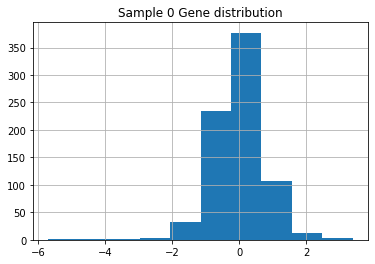

In [ ]:
import matplotlib.pyplot as plt

train_features_df[feat_dic['gene']].iloc[0].hist()
plt.title('Sample 0 Gene distribution')
plt.show()

In [ ]:
# 유전자 (gene)

# 각 샘플별 유전자 feature들의 25%와 75%값의 분위값 가져오기
q2 = train_features_df[feat_dic['gene']].apply(np.quantile, axis=1, q=0.25).copy()
q7 = train_features_df[feat_dic['gene']].apply(np.quantile, axis=1, q=0.75).copy()

In [ ]:
# 샘플별 25% / 75% 분위의 평균값
qmean = (q2 + q7) / 2

# 샘플별로 유전자 feature들의 값에서 평균값 빼기
train_features_df[feat_dic['gene']] = (train_features_df[feat_dic['gene']].T - qmean.values).T

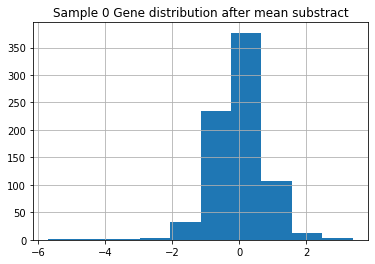

In [ ]:
train_features_df[feat_dic['gene']].iloc[0].hist()
plt.title('Sample 0 Gene distribution after mean substract')
plt.show()

세포 (cell)
> 분포의 변화가 약간씩 눈에 띈다

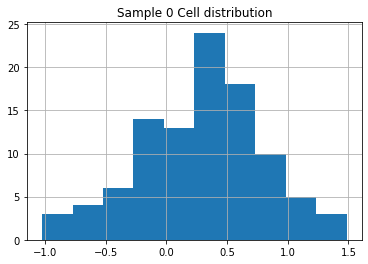

In [ ]:
train_features_df[feat_dic['cell']].iloc[0].hist()
plt.title('Sample 0 Cell distribution')
plt.show()

In [ ]:
# 세포 (cell)

# 각 샘플별 세포 feature들의 25%와 75%값의 분위값 가져오기
q2 = train_features_df[feat_dic['cell']].apply(np.quantile, axis=1, q=0.25).copy()
q7 = train_features_df[feat_dic['cell']].apply(np.quantile, axis=1, q=0.72).copy()

# 샘플별 25% / 75% 분위의 평균값
qmean = (q2 + q7) / 2

# 샘플별로 세포 feature들의 값에서 평균값 빼기
train_features_df[feat_dic['cell']] = (train_features_df[feat_dic['cell']].T - qmean.values).T

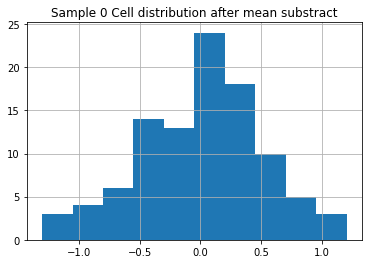

In [ ]:
train_features_df[feat_dic['cell']].iloc[0].hist()
plt.title('Sample 0 Cell distribution after mean substract')
plt.show()

In [ ]:
# 샘플별 절대값의 75% 분위값에 4를 더한 값
qmean2 = train_features_df[feat_dic['cell']].abs().apply(np.quantile, axis=1, q=0.75).copy() + 4

# 샘플별로 세포 feature들의 값에서 방금 구한 값을 나누기
train_features_df[feat_dic['cell']] = (train_features_df[feat_dic['cell']].T / qmean2.values).T.copy()

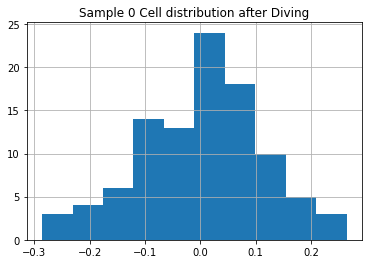

In [ ]:
train_features_df[feat_dic['cell']].iloc[0].hist()
plt.title('Sample 0 Cell distribution after Diving')
plt.show()

#### 🔴 데이터셋 합치기
> 데이터셋을 하나로 합치자!

- `train_features_df`와 `train_targets_scored_df` 합치기
- `train_df`와 `train_targets_nonscored` 합치기

##### `train_features_df`와 `train_targets_scored_df` 합치기
> X 데이터와 y 데이터를 하나로 합하는 것

In [ ]:
train_features_df.sample(3)

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,...,c-60,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
3483,id_2579a8b09,ctl_vehicle,48,D1,-0.520400,-2.253200,-1.220200,0.702800,-2.120200,0.622500,0.669200,-2.145200,0.819900,0.404700,-0.983600,-0.666100,1.209800,0.078200,0.249000,-0.469400,0.237000,0.457100,0.373000,0.460400,1.294800,-1.126200,-0.849600,-0.100200,-0.232100,1.662800,-0.012300,-0.901400,1.473800,1.313800,-0.888700,0.777600,-1.137200,0.495200,-0.558300,-1.356200,...,0.004995,0.052276,-0.000782,-0.051797,-0.219836,0.030293,-0.345807,0.012753,0.250681,0.079326,0.001032,0.123125,-0.011127,0.124021,0.011377,0.110194,-0.196748,-0.089964,0.112550,-0.139727,-0.029168,-0.174452,0.061348,-0.065520,0.152156,0.092049,0.084978,-0.252371,0.236082,0.037113,0.147964,-0.247992,-0.089693,-0.165463,0.023786,0.075864,0.137536,-0.043475,0.149946,0.006955
23043,id_f76ad3bbf,trt_cp,48,D2,-0.723912,0.176687,1.233988,-0.875713,-0.035912,0.110787,0.229487,0.250988,0.064487,-0.205212,-0.043513,-0.069413,0.646288,0.177888,-0.147313,-0.262613,2.683987,0.004687,-0.099113,-0.387713,-0.207412,-0.208813,-0.192513,0.140687,-0.090313,-0.295013,-0.119013,0.266188,-0.467013,0.655988,0.681488,0.412188,0.356587,0.175088,-0.080513,-0.208613,...,0.044597,0.135714,-0.126541,0.140319,-0.005802,-0.131553,0.085058,-0.064683,-0.056565,0.173754,0.178273,-0.202022,-0.200522,-0.069331,0.048774,0.014932,-0.000297,-0.040137,-0.005395,-0.123671,0.015574,0.104720,0.099130,0.010926,0.118600,-0.153036,-0.059242,0.059997,-0.142584,0.145202,-0.061577,0.223917,-0.038509,-0.018910,-0.175419,0.113845,0.082466,-0.072415,0.123997,-0.322611
11866,id_7fc1be8e3,trt_cp,24,D2,0.112100,0.335700,-0.273200,0.695600,0.264800,0.653100,0.060900,0.784500,-0.613900,-0.352900,0.645700,-0.038900,-0.829900,-0.983100,-0.909800,0.277800,1.171900,-1.020100,0.026800,0.607000,-0.429400,-0.052300,-0.741800,0.029900,-0.661700,-0.471700,-0.204800,-0.453900,-1.052100,0.348100,-0.696400,-0.990100,0.366300,0.534300,-0.442600,-0.547400,...,-0.191131,-0.126184,0.101923,-0.093089,-0.272154,0.045957,0.098494,-0.116324,0.030160,0.056546,-0.019611,-0.445989,0.117163,0.110454,0.233275,-0.017982,0.141320,-0.156193,0.012755,-0.040703,-0.063959,0.058154,-0.055128,0.134825,0.356738,-0.054164,-0.036202,0.040877,0.060319,0.022851,0.221378,-0.001735,-0.346104,0.021736,0.105438,-0.349104,0.030332,-0.058365,-0.119968,0.196836


In [ ]:
train_targets_scored_df.sample(3)

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,...,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
14257,id_997d9f25d,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7631,id_51f0722ce,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10933,id_75b14c230,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
train_df = train_features_df.merge(train_targets_scored_df, on='sig_id')
train_df.iloc[:, [0, 1, 2, 3, 5, 6, 7, -3, -2, -1]]

,sig_id,cp_type,cp_time,cp_dose,g-1,g-2,g-3,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,trt_cp,24,D1,0.547612,-0.257988,-0.630888,0,0,0
1,id_000779bfc,trt_cp,72,D1,0.409263,0.299662,0.060963,0,0,0
2,id_000a6266a,trt_cp,48,D1,0.593212,1.565513,-0.064888,0,0,0
3,id_0015fd391,trt_cp,48,D1,-0.219550,-0.236050,0.558350,0,0,0
4,id_001626bd3,trt_cp,72,D2,-0.412262,0.958638,0.680538,0,0,0
...,...,...,...,...,...,...,...,...,...,...
23809,id_fffb1ceed,trt_cp,24,D2,-0.080313,-0.127913,-0.524713,0,0,0
23810,id_fffb70c0c,trt_cp,24,D2,0.339313,-0.382788,0.982013,0,0,0
23811,id_fffc1c3f4,ctl_vehicle,48,D2,0.372700,0.308000,-0.741800,0,0,0
23812,id_fffcb9e7c,trt_cp,24,D1,0.142500,0.349300,0.114500,0,0,0


##### `train_df`와 `train_targets_nonscored` 합치기
> nonscored target 데이터도 함께 합친다!

In [ ]:
# nonscored target 라벨 중 scored target 라벨과 상관관계가 높은 10% 라벨 데이터
target_nonsc_cols2[:5]

['abc_transporter_expression_enhancer',
 'abl_inhibitor',
 'big1_inhibitor',
 'camp_stimulant',
 'caspase_inhibitor']

In [ ]:
# 선별된 column이름들
col_names = ['sig_id'] + target_nonsc_cols2

In [ ]:
train_df = train_df.merge(train_targets_nonscored_df[col_names], on='sig_id')
train_df.iloc[:, [0, 1, 2, 3, 5, 6, 7, -3, -2, -1]]

,sig_id,cp_type,cp_time,cp_dose,g-1,g-2,g-3,sphingosine_1_phosphate_receptor_agonist,steryl_sulfatase_inhibitor,tyrosine_phosphatase_inhibitor
0,id_000644bb2,trt_cp,24,D1,0.547612,-0.257988,-0.630888,0,0,0
1,id_000779bfc,trt_cp,72,D1,0.409263,0.299662,0.060963,0,0,0
2,id_000a6266a,trt_cp,48,D1,0.593212,1.565513,-0.064888,0,0,0
3,id_0015fd391,trt_cp,48,D1,-0.219550,-0.236050,0.558350,0,0,0
4,id_001626bd3,trt_cp,72,D2,-0.412262,0.958638,0.680538,0,0,0
...,...,...,...,...,...,...,...,...,...,...
23809,id_fffb1ceed,trt_cp,24,D2,-0.080313,-0.127913,-0.524713,0,0,0
23810,id_fffb70c0c,trt_cp,24,D2,0.339313,-0.382788,0.982013,0,0,0
23811,id_fffc1c3f4,ctl_vehicle,48,D2,0.372700,0.308000,-0.741800,0,0,0
23812,id_fffcb9e7c,trt_cp,24,D1,0.142500,0.349300,0.114500,0,0,0


#### 🔴 control 그룹만 남기기
> `ctl_vehicle`그룹은 모두 없애고 `trt_cp`그룹만 남긴다

In [ ]:
train_df.shape

(23814, 1123)

In [ ]:
# control 그룹만 남기기
train_df = train_df[train_df['cp_type'] != 'ctl_vehicle'].reset_index(drop=True)

# cp_type feature는 이제 필요없으므로 삭제
train_df = train_df.drop('cp_type', axis=1)
train_df.shape

(21948, 1122)

#### 🔴 target 데이터셋 별도 제작

In [ ]:
# scored target
target_df = train_df[['sig_id'] + target_cols]

# nonscored target
target_ns_df = train_df[['sig_id'] + target_nonsc_cols2]

# scored target 라벨들
target_cols = target_df.drop('sig_id', axis=1).columns.values.tolist()

In [ ]:
target_df.sample(3)

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,...,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
5408,id_3f508059c,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
21038,id_f51cc5902,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
15976,id_ba65433fe,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
target_ns_df.sample(3)

,sig_id,abc_transporter_expression_enhancer,abl_inhibitor,big1_inhibitor,camp_stimulant,caspase_inhibitor,diacylglycerol_o_acyltransferase_inhibitor,differentiation_inducer,dna_dependent_protein_kinase_inhibitor,dna_methyltransferase_inhibitor,ephrin_inhibitor,gaba_gated_chloride_channel_blocker,gaba_receptor_modulator,gap_junction_modulator,gastrin_inhibitor,glucocorticoid_receptor_antagonist,glutathione_reductase_(nadph)_activators,glycine_receptor_antagonist,heme_oxygenase_activators,hgf_receptor_inhibitor,hiv_protease_inhibitor,hydroxycarboxylic_acid_receptor_agonist,imidazoline_ligand,inosine_monophosphate_dehydrogenase_inhibitor,keap1_ligand,macrophage_inhibitor,macrophage_migration_inhibiting_factor_inhibitor,membrane_permeability_inhibitor,nfkb_activator,niemann-pick_c1-like_1_protein_antagonist,nitric_oxide_scavenger,omega_3_fatty_acid_stimulant,peptidase_inhibitor,quorum_sensing_signaling_modulator,reducing_agent,ret_inhibitor,ror_inverse_agonist,sars_coronavirus_3c-like_protease_inhibitor,selective_estrogen_receptor_modulator_(serm),sphingosine_1_phosphate_receptor_agonist,steryl_sulfatase_inhibitor,tyrosine_phosphatase_inhibitor
6660,id_4dc42ed5e,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8680,id_65b892e4d,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12181,id_8e842b24c,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# scored target 라벨들
target_cols[:5]

['5-alpha_reductase_inhibitor',
 '11-beta-hsd1_inhibitor',
 'acat_inhibitor',
 'acetylcholine_receptor_agonist',
 'acetylcholine_receptor_antagonist']

#### 🔴 데이터셋 합치기
> `target_df`와 `train_drug_df` 합치기!

In [ ]:
# target 데이터셋의 샘플들
tar_sig = target_df['sig_id'].tolist()

# target 데이터셋에 샘플이 있는 drug정보만을 남긴다
train_drug_df = train_drug_df.loc[[i in tar_sig for i in train_drug_df['sig_id']]]

# target_df와 train_drug_df 합치기!
target_df = target_df.merge(train_drug_df, on='sig_id', how='left') 

In [ ]:
# drug_id가 feature로 포함된 것을 볼 수 있다!
target_df.iloc[:, [0, 1, 2, 3, -1]].sample(3)

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,drug_id
13696,id_9fd54d933,0,0,0,3e9fc2514
6747,id_4e8bc25b6,0,0,0,2a74be16e
17047,id_c6c44faa6,0,0,0,ee8ba3370


#### 🔴 훈련에 사용할 feature 선별

In [ ]:
feature_cols = []

for key_i in feat_dic.keys():

    value_i = feat_dic[key_i]
    feature_cols += value_i

In [ ]:
feature_cols[:5] + feature_cols[-5:]

['g-0', 'g-1', 'g-2', 'g-3', 'g-4', 'c-95', 'c-96', 'c-97', 'c-98', 'c-99']

#### 🔴 전처리가 끝나고 우리에게 남은 것
> 긴 전처리 과정이 끝나고 4개의 pandas DataFrame에서 출발하여 우리는 훈련에 필요한 데이터들을 얻었다. 이는 다음과 같다.

- `train_df` : 핵심 훈련 데이터
- `target_df` : 핵심 정답 데이터
- `target_ns_df` : nonscored target 라벨 데이터

In [ ]:
print(f"훈련 데이터셋 shape : {train_df.shape}")
print(f"정답 데이터셋 shape : {target_df.shape}")
print(f"nonscored target 라벨 데이터셋 shape : {target_ns_df.shape}")

훈련 데이터셋 shape : (21948, 1122)
정답 데이터셋 shape : (21948, 208)
nonscored target 라벨 데이터셋 shape : (21948, 42)


In [ ]:
train_df.sample(5)

,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,id,fc,sd,pso,dso,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1
3038,dsgdb9nsd_000151,8,0,2JHC,0.031296,2965,0.037874,-0.148694,-0.015666,-0.011393,H,-0.550998,-0.223358,1.326968,C,-0.394458,1.800652,0.565242
9553,dsgdb9nsd_000475,13,3,1JHC,-0.680647,9257,-0.688380,-0.325705,0.991782,-0.832485,H,-1.121148,0.176951,-2.359700,C,-0.197432,0.024366,-1.790931
8376,dsgdb9nsd_000426,9,2,1JHC,-0.249868,8115,-0.223313,0.278253,-1.294713,0.566363,H,-1.537179,-1.238152,1.199403,C,-1.207604,-0.519019,0.446789
5885,dsgdb9nsd_000311,16,0,3JHC,0.652513,5742,0.612047,-0.363625,-0.814338,1.050626,H,0.386440,0.510189,1.498594,C,-1.168826,2.066260,-0.187301
5361,dsgdb9nsd_000287,8,9,3JHH,1.524180,5176,1.566497,-0.283827,1.054382,-1.139081,H,0.285783,1.899112,0.657789,H,1.363532,-0.727811,-0.509272


In [ ]:
# drug_id가 포함되어있다!
target_df.iloc[:, [0, 1, 2, 3, -1]].sample(3)

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,drug_id
4256,id_31ac99501,0,0,0,1b09b35f0
10949,id_7fec7b68a,0,0,0,9f80f3f77
5708,id_42b4bbe9c,0,0,0,5628cb3ee


In [ ]:
# drug_id가 포함되어있지 않다!
target_ns_df.iloc[:, [0, 1, 2, -1]].sample(3)

,sig_id,abc_transporter_expression_enhancer,abl_inhibitor,tyrosine_phosphatase_inhibitor
17563,id_ccb539ad5,0,0,0
13818,id_a14c1e809,0,0,0
17354,id_ca518c59a,0,0,0


### 🏹 데이터셋 및 데이터 로더 (Dataset and DataLoader)
> 전처리에서 생성한 데이터들을 토대로 훈련에 바로 사용할 수 있는 데이터셋을 만들자. 위에서 해오던 sequence 데이터셋과는 다르게 데이터셋이 훨씬 간편해진 것을 알 수 있다!

- Feature Extraction
- 데이터셋 및 데이터 로더

In [ ]:
x_train = train_df[feature_cols]
y_train = train_df[target_cols]

# 훈련에 사용할 feature들만 모아놓은 데이터셋!
x_train.iloc[:, [0, 1, 2, -3, -2, -1]].sample(3)

,g-0,g-1,g-2,c-97,c-98,c-99
3926,2.489375,0.328875,-0.205725,0.030153,0.028633,-0.001099
3067,-0.340862,-0.652662,-0.988262,-0.009164,0.062601,-0.148061
3579,0.035987,0.083087,-1.837213,-0.171816,0.133615,-0.029733


In [ ]:
y_train.iloc[:, [0, -2, -1]].sample(3)

,5-alpha_reductase_inhibitor,vitamin_d_receptor_agonist,wnt_inhibitor
4005,0,0,0
12071,0,0,0
19312,0,0,0


#### 🔴 Feature Extraction
> 여기서는 전처리가 아니라 훈련할 때 데이터에 추가적인 feature extraction을 한다!

- Norm
- PCA

##### Norm

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer


def norm_fit(df, norm_name='zsco'):   
    norm_dic = {'zsco':StandardScaler(),
                'mima':MinMaxScaler(),
                'maxb':MaxAbsScaler(), 
                'robu':RobustScaler(),
                'norm':Normalizer(), 
                'quan':QuantileTransformer(n_quantiles=100,
                                           random_state=0,
                                           output_distribution="normal"),
                'powe':PowerTransformer()}

    # 원하는 normalizer 선택하기
    norm = norm_dic[norm_name]

    # norm 적용하기!
    norm_df = pd.DataFrame(norm.fit_transform(df),
                           index=df.index,
                           columns=df.columns)
    return norm_df

In [ ]:
x_train = norm_fit(x_train, 'quan')

##### PCA

In [ ]:
from sklearn.decomposition import PCA

# 유전자 (Gene) / 세포 (Cell)
# G - Gene
# C - Cell

# feature column 목록
feat_G = feat_dic['gene']
feat_C = feat_dic['cell']

# 사용할 PCA feature 수
n_comp1 = 50
n_comp2 = 15

# 생성한 PCA feature들의 이름에 붙일 prefix
feat_prefix_G = [f'pca_G-{i}' for i in range(n_comp1)]
feat_prefix_C = [f'pca_C-{i}' for i in range(n_comp2)]

# PCA 모델 생성
pca_G = PCA(n_components=n_comp1, random_state=42)
pca_C = PCA(n_components=n_comp2, random_state=42)

In [ ]:
# 유전자 (Gene)
x_pca_G = pca_G.fit_transform(x_train[feat_G])
x_pca_G = pd.DataFrame(x_pca_G, columns=feat_prefix_G)

# 세포 (Cell)
x_pca_C = pca_C.fit_transform(x_train[feat_C])
x_pca_C = pd.DataFrame(x_pca_C, columns=feat_prefix_C)

In [ ]:
# 유전자 (Gene) pca feature 50개
x_pca_G.sample(3)

,pca_G-0,pca_G-1,pca_G-2,pca_G-3,pca_G-4,pca_G-5,pca_G-6,pca_G-7,pca_G-8,pca_G-9,pca_G-10,pca_G-11,pca_G-12,pca_G-13,pca_G-14,pca_G-15,pca_G-16,pca_G-17,pca_G-18,pca_G-19,pca_G-20,pca_G-21,pca_G-22,pca_G-23,pca_G-24,pca_G-25,pca_G-26,pca_G-27,pca_G-28,pca_G-29,pca_G-30,pca_G-31,pca_G-32,pca_G-33,pca_G-34,pca_G-35,pca_G-36,pca_G-37,pca_G-38,pca_G-39,pca_G-40,pca_G-41,pca_G-42,pca_G-43,pca_G-44,pca_G-45,pca_G-46,pca_G-47,pca_G-48,pca_G-49
14390,15.723116,5.222682,-1.828369,4.225969,-11.838449,4.625257,-2.327781,-3.696374,-2.229669,-1.183078,-1.160296,-1.203660,0.230850,1.948699,-4.959633,-3.055006,-6.257620,-0.001364,1.179951,1.266458,-2.876385,-4.715516,-4.107767,-0.130173,1.931990,-1.189328,3.339861,-2.276621,1.614913,-1.435096,-1.533901,-1.131813,-1.731812,0.134108,0.409086,-0.160149,-1.713782,-2.284464,2.929760,-2.250396,-0.570799,-0.753600,2.807816,-1.038775,-1.608810,-0.963541,1.532866,-0.530823,-1.021261,0.464783
10906,15.842439,-3.825169,-5.308466,-2.336164,-5.149017,-3.324212,-5.569426,15.979511,-8.555572,-0.897918,6.341996,-4.429465,-2.703353,-5.525451,5.002669,-0.619571,-0.656867,-1.653776,-2.673471,4.660790,0.909790,1.215670,2.048618,-1.686960,-2.673715,0.298440,1.619401,-1.239656,-2.391873,0.006251,1.921729,3.131089,-0.108869,-0.564049,-0.431799,-0.108857,3.473369,-1.813571,-0.329878,1.836142,3.022695,0.829502,0.375116,2.281421,2.197368,0.246471,-0.930403,0.840180,0.165736,-1.602860
4019,-1.963141,-2.906213,7.009815,-7.768278,0.279193,6.256304,-1.360345,0.414766,1.678518,1.625087,-3.482890,-3.629561,0.458336,-0.385273,-0.249317,-3.079793,-1.888380,0.647245,0.300829,1.273442,-0.653398,-1.320456,-1.008212,0.349595,0.462324,0.526467,0.502787,0.355585,1.531986,-0.229349,1.131751,-1.403303,-0.155393,-0.803719,1.600674,-1.255016,-0.677439,-0.780994,1.733646,-1.691562,-0.641542,-1.540978,2.277105,-0.865569,0.315669,0.713701,0.983588,-0.821135,-1.734312,-2.446250


In [ ]:
# 세포 (Cell) pca feature 15개
x_pca_C.sample(3)

,pca_C-0,pca_C-1,pca_C-2,pca_C-3,pca_C-4,pca_C-5,pca_C-6,pca_C-7,pca_C-8,pca_C-9,pca_C-10,pca_C-11,pca_C-12,pca_C-13,pca_C-14
3012,-0.372158,0.833662,-1.610792,-0.600212,-0.674227,0.965127,-0.197456,1.095799,1.366204,0.230467,-0.265250,-0.933439,0.784342,-1.055317,-1.216490
11664,-0.338218,0.315921,-0.506038,-0.712566,0.464564,0.099491,0.023827,2.041225,-0.768178,-0.102026,0.358103,-0.724692,1.000943,1.156796,2.132578
4905,-0.436672,-1.525229,0.564062,0.084257,-0.698596,-0.159940,-0.046463,-1.522970,0.453744,0.921994,1.765947,1.281138,-0.177135,0.560222,-0.336049


In [ ]:
# 생성한 pca feature 합치기!
x_train = pd.concat([x_train, x_pca_G, x_pca_C], axis = 1)
x_train.shape

(21948, 937)

In [ ]:
x_train

,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,g-36,g-37,g-38,g-39,...,pca_G-25,pca_G-26,pca_G-27,pca_G-28,pca_G-29,pca_G-30,pca_G-31,pca_G-32,pca_G-33,pca_G-34,pca_G-35,pca_G-36,pca_G-37,pca_G-38,pca_G-39,pca_G-40,pca_G-41,pca_G-42,pca_G-43,pca_G-44,pca_G-45,pca_G-46,pca_G-47,pca_G-48,pca_G-49,pca_C-0,pca_C-1,pca_C-2,pca_C-3,pca_C-4,pca_C-5,pca_C-6,pca_C-7,pca_C-8,pca_C-9,pca_C-10,pca_C-11,pca_C-12,pca_C-13,pca_C-14
0,1.107176,0.891024,-0.439644,-0.991474,-0.294230,-1.014278,-1.352480,-0.053778,0.722622,-0.303816,1.563342,0.152455,0.668180,-0.545720,0.298702,-1.079053,-1.121434,0.899873,0.364069,-0.530957,-0.717952,-1.346121,-1.707190,1.242759,0.564394,0.433219,0.287948,0.129054,-0.495308,0.766699,0.415443,-1.127132,-0.067481,-0.410890,-0.240469,0.280377,0.379527,-0.574510,-0.795032,-0.447737,...,-1.612347,0.928214,-1.043469,-0.311092,-0.197346,0.134086,-0.566946,-0.918701,-0.677657,-0.304680,0.436301,0.803232,-2.469676,-1.920515,0.565977,1.193591,-0.208502,0.693917,0.972530,-0.686147,-1.987594,0.152042,0.631871,0.079477,-0.154661,0.073492,1.038188,1.941637,-0.048545,-1.040770,-0.241677,2.199715,0.073949,1.226884,0.326793,-0.887674,0.700866,-0.547343,-1.331632,0.071279
1,0.112548,0.676211,0.265848,0.096628,1.196776,0.701320,0.364328,0.562611,-0.488683,0.853430,-1.248358,-0.579968,-0.171256,0.550236,0.176308,0.392617,0.420694,0.443074,-0.845148,0.502264,1.297141,-0.139774,-0.416316,-0.426556,0.407599,-0.553288,0.711007,0.201323,-0.702308,-0.201674,-0.106924,-0.537948,1.667835,-0.328143,0.332339,-0.258838,0.206587,0.828132,-0.381430,-0.141378,...,1.648397,1.639727,0.820898,0.692626,0.648092,2.718700,-0.363272,0.170822,-0.949669,3.226577,0.129583,-0.356561,1.510975,-1.774983,1.043354,-0.131341,0.473337,-0.469329,-0.466184,-1.136055,1.079787,-0.203692,0.788605,-1.286299,0.258916,-0.459832,-1.227959,-0.152923,-0.850715,-0.310149,0.373252,0.019373,-0.292454,-2.079877,0.185390,1.098318,0.829056,-0.138748,0.519804,-0.297903
2,0.780594,0.960022,1.432537,-0.099445,-0.004170,1.505605,0.294853,0.384153,0.062408,1.273209,-0.643197,-0.756402,-0.072411,-2.253978,0.927380,-0.529424,0.501579,-0.354791,-0.281450,-0.025399,-0.053482,-1.013565,-1.948616,0.555680,0.658179,0.768027,-1.342559,2.390871,-0.016120,1.597691,-1.419492,0.825815,0.759996,0.269322,-0.010898,-1.640025,0.167972,-0.124180,1.667169,1.289192,...,0.411062,-1.474071,-2.078902,-0.463693,0.226095,0.659296,-3.106201,-0.956959,1.125960,-2.366340,1.277692,-3.214775,-1.419533,3.173551,-1.181116,2.153454,1.130464,-0.881503,0.489042,-0.253943,1.199598,3.437646,-0.246990,-1.597285,2.705181,0.258207,0.292578,-0.320469,0.715725,-0.747250,0.201141,0.093540,0.094134,-0.070985,-0.189123,-1.002346,-0.348913,-0.206825,1.572565,-0.949631
3,-0.698074,-0.247879,-0.410969,0.821924,2.344649,-0.824631,-2.282473,0.353568,-0.102129,-1.341987,-0.989691,-0.463492,-1.089332,-0.744048,-1.734422,1.442446,-0.167246,-0.992395,0.315576,-2.118410,2.092315,-1.329637,-1.083962,-1.026768,-1.380621,0.085280,-1.000206,0.280591,-0.354787,-1.228039,-0.944466,0.190964,-2.052533,1.124163,0.814341,-2.108148,-1.383707,-1.019390,1.386981,-0.663192,...,-0.777173,1.411730,-1.102683,-1.329913,0.605063,2.478366,2.213943,-3.684297,-1.313573,2.126053,-3.580636,0.693332,-3.053591,5.418486,-0.450402,-0.693295,-1.775648,1.519574,-0.700323,0.267930,-0.785862,-1.302499,1.086646,0.925574,1.135746,5.841947,6.938491,-1.109030,-3.855538,-0.297167,1.251915,-0.690401,-0.679820,-0.734029,0.174291,-1.648725,1.845066,-0.665734,2.170844,-0.233437
4,-0.474699,-0.507883,0.953071,0.982123,1.439793,-0.869868,-0.350621,-0.236035,-1.028651,0.853806,-0.357801,-0.718854,-1.228491,1.166437,0.333994,0.323027,-0.014615,-1.535674,-0.880117,-0.723471,-0.437764,-0.310542,1.020087,0.483874,1.694152,1.043923,1.151907,-0.618437,-1.512936,0.359268,-0.157351,0.834167,1.116046,-0.110757,1.481424,-1.014319,-1.317155,1.665069,0.749713,-0.227807

#### 🔴 데이터셋 및 데이터 로더
> feature extraction이 적용된 데이터를 데이터셋 및 데이터로더로 만들자!

In [ ]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class TrainDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return (self.features.shape[0])

    def __getitem__(self, idx):
        dct = {'x' : torch.tensor(self.features.iloc[idx, :], dtype=torch.float),
               'y' : torch.tensor(self.targets.iloc[idx, :], dtype=torch.float)}

        return dct

In [ ]:
train_dataset = TrainDataset(x_train, y_train)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
# Dataset
for dct in train_dataset:
    print(f"x size : {dct['x'].size()}")
    print(f"y size : {dct['y'].size()}")
    break

x size : torch.Size([937])
y size : torch.Size([206])


In [ ]:
# Dataloader
for dct in trainloader:
    print(f"x size : {dct['x'].size()}")
    print(f"y size : {dct['y'].size()}")
    break

x size : torch.Size([32, 937])
y size : torch.Size([32, 206])


### 🏹 모델
> 이번 대회 예시는 Transformer가 아닌 다른 모델의 사용을 보여준다! 여기서는 `1D CNN` 모델을 사용하며 Sequence 모델이 아닌만큼 이해하기가 훨씬 수월할 것이다!

<img src="https://www.googleapis.com/download/storage/v1/b/kaggle-forum-message-attachments/o/inbox%2F1851802%2Ffdf0f6ba40f129524fecc26235fd38c5%2F1D-CNN.jpg?generation=1607494535889507&alt=media" width=1000>


**출처 - https://www.kaggle.com/c/lish-moa/discussion/202256**

In [ ]:
# 위 그림을 보면서 아래의 x_train이 어떻게 처리되는지 살펴보자!
x_train.shape

(21948, 937)

In [ ]:
from torch import nn
import torch.nn.functional as F

class CNN1D(nn.Module):
    def __init__(self, num_features, num_targets, hidden_size):
        super(CNN1D, self).__init__()
        cha_1 = 256
        cha_2 = 512
        cha_3 = 512

        cha_1_reshape = int(hidden_size / cha_1)
        cha_po_1 = int(hidden_size / cha_1 / 2)
        cha_po_2 = int(hidden_size / cha_1 / 2 / 2) * cha_3

        self.cha_1 = cha_1
        self.cha_2 = cha_2
        self.cha_3 = cha_3
        self.cha_1_reshape = cha_1_reshape
        self.cha_po_1 = cha_po_1
        self.cha_po_2 = cha_po_2

        self.batch_norm1 = nn.BatchNorm1d(num_features)
        self.dropout1 = nn.Dropout(0.1)
        self.dense1 = nn.utils.weight_norm(nn.Linear(num_features, hidden_size))

        self.batch_norm_c1 = nn.BatchNorm1d(cha_1)
        self.dropout_c1 = nn.Dropout(0.1)
        self.conv1 = nn.utils.weight_norm(nn.Conv1d(cha_1,cha_2, kernel_size = 5, stride = 1, padding=2,  bias=False),dim=None)

        self.ave_po_c1 = nn.AdaptiveAvgPool1d(output_size = cha_po_1)

        self.batch_norm_c2 = nn.BatchNorm1d(cha_2)
        self.dropout_c2 = nn.Dropout(0.1)
        self.conv2 = nn.utils.weight_norm(nn.Conv1d(cha_2,cha_2, kernel_size = 3, stride = 1, padding=1, bias=True),dim=None)

        self.batch_norm_c2_1 = nn.BatchNorm1d(cha_2)
        self.dropout_c2_1 = nn.Dropout(0.3)
        self.conv2_1 = nn.utils.weight_norm(nn.Conv1d(cha_2,cha_2, kernel_size = 3, stride = 1, padding=1, bias=True),dim=None)

        self.batch_norm_c2_2 = nn.BatchNorm1d(cha_2)
        self.dropout_c2_2 = nn.Dropout(0.2)
        self.conv2_2 = nn.utils.weight_norm(nn.Conv1d(cha_2,cha_3, kernel_size = 5, stride = 1, padding=2, bias=True),dim=None)

        self.max_po_c2 = nn.MaxPool1d(kernel_size=4, stride=2, padding=1)

        self.flt = nn.Flatten()

        self.batch_norm3 = nn.BatchNorm1d(cha_po_2)
        self.dropout3 = nn.Dropout(0.2)
        self.dense3 = nn.utils.weight_norm(nn.Linear(cha_po_2, num_targets))

    def forward(self, x):

        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = F.celu(self.dense1(x), alpha=0.06)

        x = x.reshape(x.shape[0],self.cha_1,
                        self.cha_1_reshape)

        x = self.batch_norm_c1(x)
        x = self.dropout_c1(x)
        x = F.relu(self.conv1(x))

        x = self.ave_po_c1(x)

        x = self.batch_norm_c2(x)
        x = self.dropout_c2(x)
        x = F.relu(self.conv2(x))
        x_s = x

        x = self.batch_norm_c2_1(x)
        x = self.dropout_c2_1(x)
        x = F.relu(self.conv2_1(x))

        x = self.batch_norm_c2_2(x)
        x = self.dropout_c2_2(x)
        x = F.relu(self.conv2_2(x))
        x =  x * x_s

        x = self.max_po_c2(x)

        x = self.flt(x)

        x = self.batch_norm3(x)
        x = self.dropout3(x)
        x = self.dense3(x)

        return x

In [ ]:
# hyperparameter
num_features = len(feature_cols) + n_comp1 + n_comp2
num_targets = len(target_cols)

hidden_size = 4096

print(f'num_features : {num_features}')
print(f'num_targets : {num_targets}')

num_features : 937
num_targets : 206


In [ ]:
# 모델 생성
model = CNN1D(num_features, num_targets, hidden_size)

for dct in trainloader:
    print(f"x size : {dct['x'].size()}")
    print(f"y size : {dct['y'].size()}\n")

    y = model(dct['x'])
    
    print(f"prediction size : {y.size()}")
    break

x size : torch.Size([32, 937])
y size : torch.Size([32, 206])

prediction size : torch.Size([32, 206])


### 🏹 기타
- 전체 구조
- 결과
- 모델 간 상관관계

#### 🔴 전체 구조

![moa model](https://github.com/baosenguo/Kaggle-MoA-2nd-Place-Solution/raw/main/.fig/flowchart.jpg)

**출처 - https://www.kaggle.com/c/lish-moa/discussion/202256**


#### 🔴 결과


![moa model result](https://www.googleapis.com/download/storage/v1/b/kaggle-forum-message-attachments/o/inbox%2F1851802%2F81016106a1046153d07cdfbdc8c43173%2Fperformance.jpg?generation=1607494441438421&alt=media)

**출처 - https://www.kaggle.com/c/lish-moa/discussion/202256**

#### 🔴 모델 간 상관관계


![blending correlation](https://www.googleapis.com/download/storage/v1/b/kaggle-forum-message-attachments/o/inbox%2F1851802%2F992b5b32870f4571ad9cf9eb632c5443%2Fcorrelation%20between%20single%20models.jpg?generation=1607494569218486&alt=media)

**출처 - https://www.kaggle.com/c/lish-moa/discussion/202256**